
# Conversational Agent for Medical Question-Answering Using RAG and LLM

- **Components Used**: `InMemoryDocumentStore`, `InMemoryEmbeddingRetriever`, `ChatPromptBuilder`, `OllamaChatGenerator`, `DocumentMRREvaluator`, `FaithfulnessEvaluator`, `SASEvaluator`, `SentenceTransformersDocumentEmbedder`
- **Prerequisites**:
  - Ollama installed with `mistral` models pulled (`ollama pull mistral`).
  - Python packages: `haystack-ai`, `datasets`, `sentence-transformers`.
- **Goal**: Build and evaluate a Retrieval-Augmented Generation (RAG) pipeline for answering medical questions using the PubMed QA dataset, with a local LLM (`mistral`) via Ollama and Haystack's evaluation metrics (MRR, SAS, Faithfulness).


## Overview

This notebook demonstrates how to create a conversational agent for medical question-answering using a local LLM (`mistral`) and Haystack's RAG pipeline. Unlike typical setups that rely on cloud-based models like OpenAI's GPT, this project uses a fully local setup with Ollama, making it cost-effective and privacy-focused. We use the PubMed QA dataset, which provides labeled questions, contexts, and answers, to build and evaluate our pipeline.


### Key Features
- **RAG Pipeline**: Combines retrieval (using several embedding models) and generation (using `mistral`).
- **Evaluation Metrics**:
  - **Document MRR**: Measures retrieval accuracy by ranking relevant documents.
  - **Semantic Answer Similarity (SAS)**: Evaluates semantic similarity between predicted and ground truth answers.
  - **Faithfulness**: Ensures generated answers are grounded in the retrieved contexts.
- **Local Setup**: Uses Ollama both LLM, ensuring no external API dependencies.


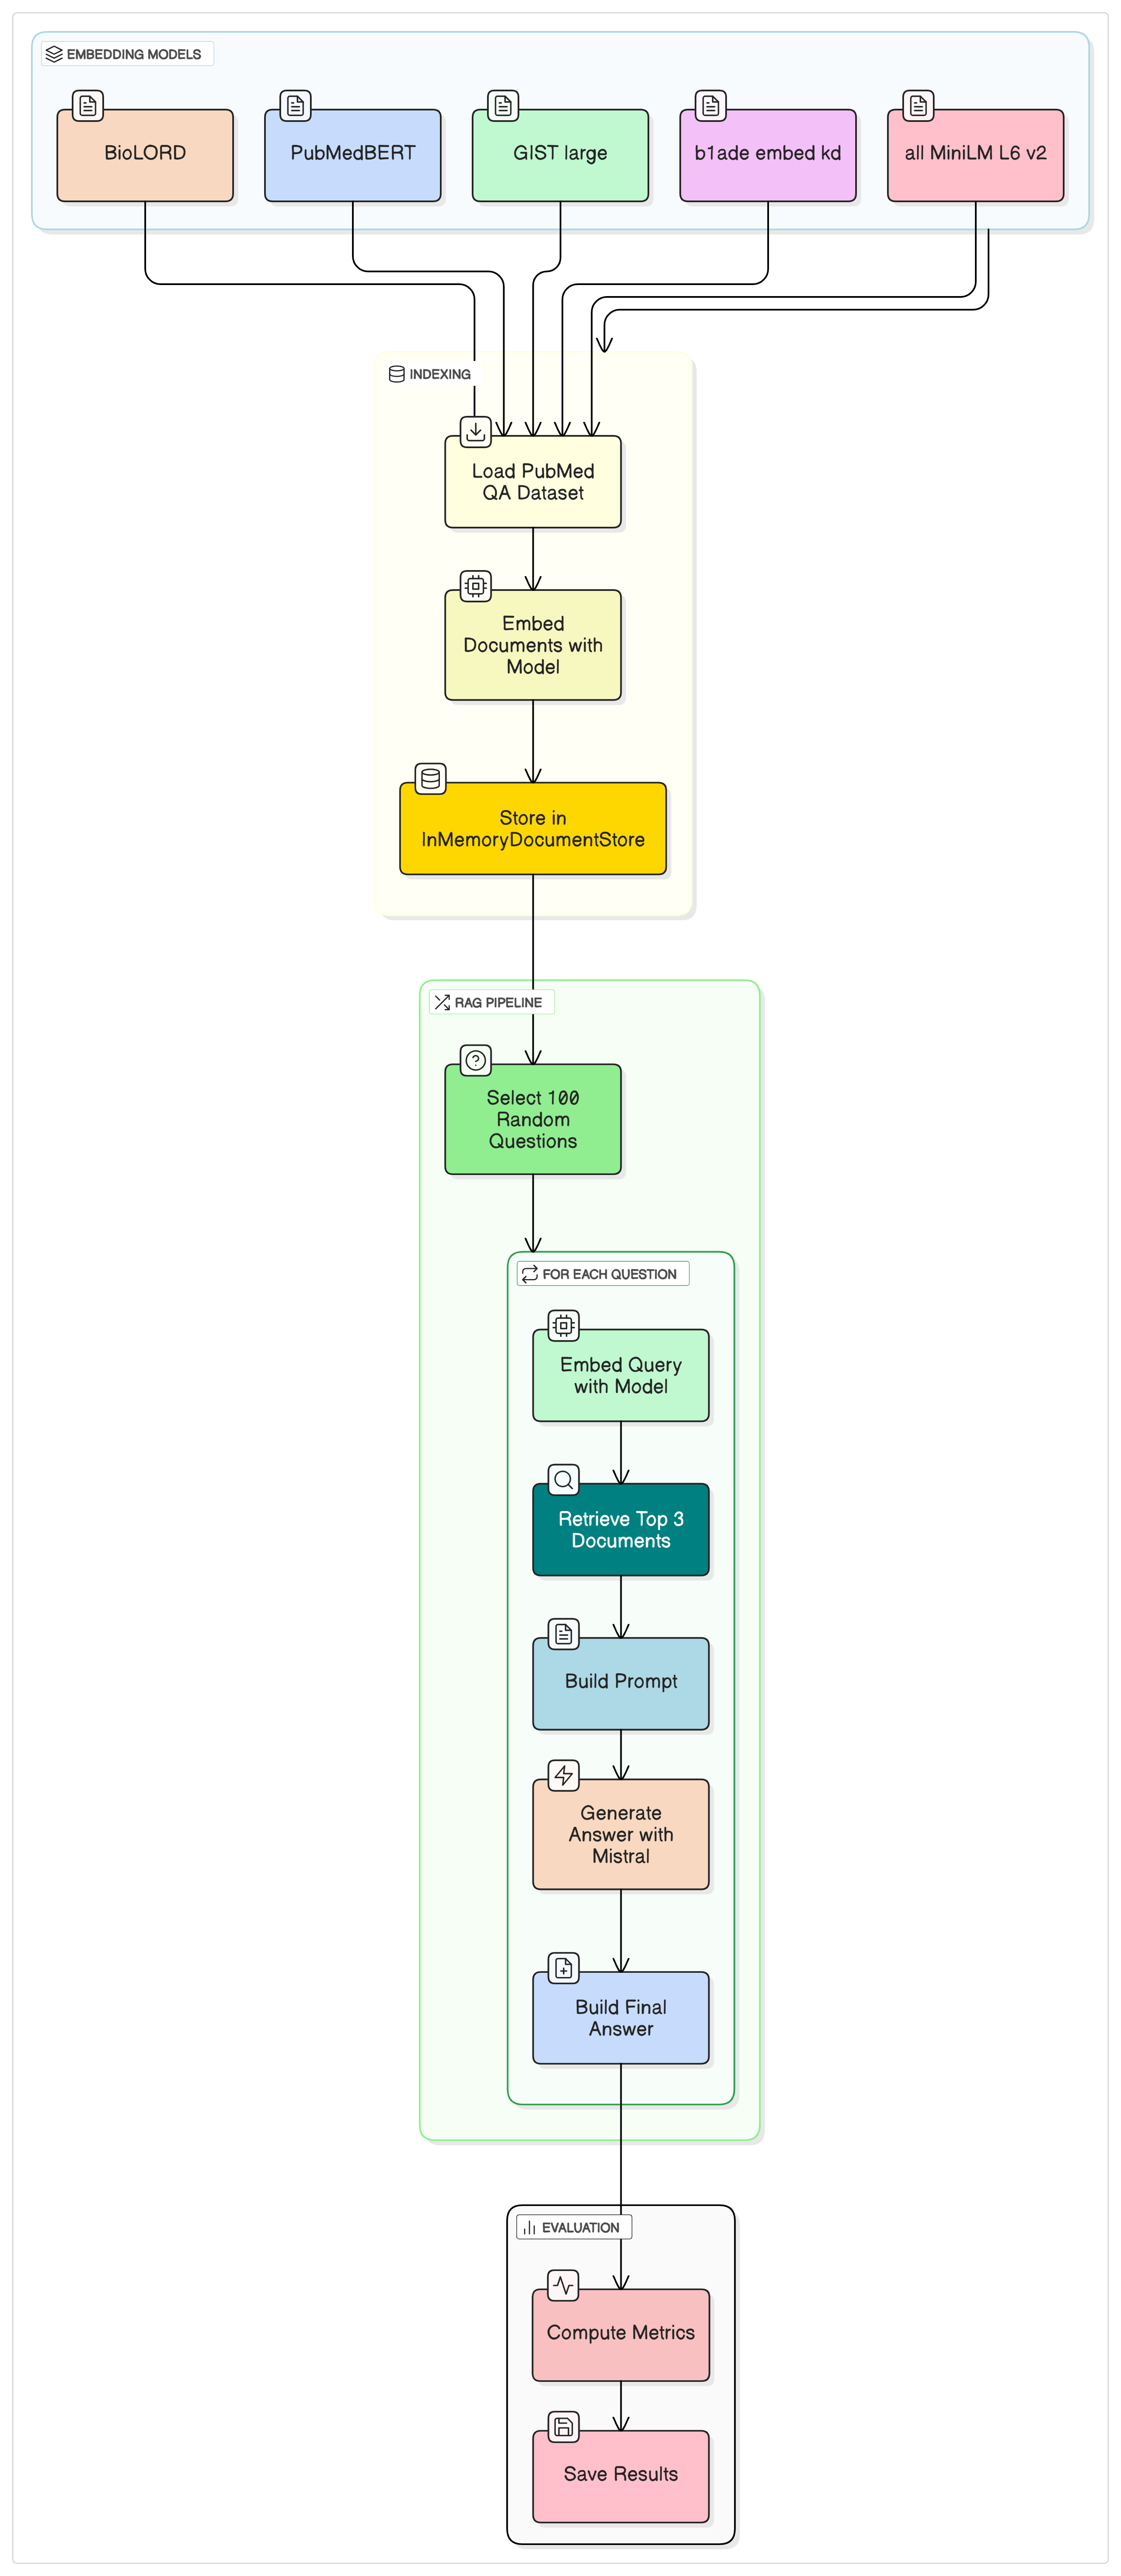

> 📺 This notebook is designed for research purpose, combining local LLM usage with advanced RAG evaluation for medical QA.


## Check Cuda

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name()

'NVIDIA L4'

## Installing Dependencies

Install the required Python packages for Haystack, datasets, and sentence-transformers (for SAS evaluation).

In [ ]:
%%bash
pip install haystack-ai
pip install "datasets>=2.6.1"
pip install "sentence-transformers>=3.0.0"

In [ ]:
# Ensure Ollama is running with the required models
ollama pull mistral:latest

In [ ]:
!pip install -r requirements.txt

## Enabling Telemetry

Enable Haystack telemetry to help improve the library. You can opt out by commenting out the following line.


In [1]:
from haystack.telemetry import tutorial_running

tutorial_running("Conversational_Agent_Medical_QA")## Loading the PubMed QA Dataset

## Loading the PubMed QA Dataset

Load the PubMed QA dataset from Hugging Face, selecting the first 10000 rows. Extract documents, questions, and ground truth answers for the RAG pipeline and evaluation.


In [2]:
from datasets import load_dataset
from haystack import Document

In [3]:
# Load the PubMed QA dataset (train split, first 1000 rows)
dataset = load_dataset("vblagoje/PubMedQA_instruction", split="train")
dataset = dataset.select(range(10000))

README.md:   0%|          | 0.00/498 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/986k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/272458 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
# Extract documents, questions, and ground truth answers
all_documents = [Document(content=doc["context"]) for doc in dataset]
all_questions = [doc["instruction"] for doc in dataset]
all_ground_truth_answers = [doc["response"] for doc in dataset]

In [5]:
print(f"Loaded {len(all_documents)} documents, {len(all_questions)} questions, and {len(all_ground_truth_answers)} answers.")

Loaded 10000 documents, 10000 questions, and 10000 answers.


## Creating the Indexing Pipeline

Build an indexing pipeline to embed and store documents in an `InMemoryDocumentStore` using `SentenceTransformersDocumentEmbedder` via Ollama.

In [6]:
from typing import List
from haystack import Pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

In [7]:
# Initialize the document store
document_store = InMemoryDocumentStore()

#### pubmedbert-base-embeddings

In [8]:
# Initialize the document embedder with SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="NeuML/pubmedbert-base-embeddings")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

#### GIST-large-Embedding-v0

In [ ]:
# Initialize the document embedder with SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="avsolatorio/GIST-large-Embedding-v0")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

#### BioLORD

In [ ]:
# Initialize the document embedder with SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="FremyCompany/BioLORD-2023")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

#### b1ade-embed-kd

In [ ]:
# Initialize the document embedder with SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="w601sxs/b1ade-embed-kd")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

#### all-MiniLM-L6-v2

In [ ]:
# Initialize the document embedder with SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

### Pipeline

In [9]:
# Build the indexing pipeline
indexing = Pipeline()
indexing.add_component(instance=document_embedder, name="document_embedder")
indexing.add_component(instance=document_writer, name="document_writer")
indexing.connect("document_embedder.documents", "document_writer.documents")

🚅 Components
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - document_embedder.documents -> document_writer.documents (List[Document])

In [10]:
# Run the indexing pipeline
indexing.run({"document_embedder": {"documents": all_documents}})

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 10000}}

In [11]:
print(f"Indexed {document_store.count_documents()} documents.")

Indexed 10000 documents.


## Creating the RAG Pipeline

Build the RAG pipeline with retrieval (using `SentenceTransformersDocumentEmbedder` models for query embedding) and generation (using `mistral` via Ollama).

In [12]:
import os
from getpass import getpass
from haystack.components.builders import AnswerBuilder, ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack_integrations.components.generators.ollama import OllamaChatGenerator
from haystack.components.embedders import SentenceTransformersTextEmbedder

In [13]:
# Define the prompt template
template = [
    ChatMessage.from_user(
        """
        You are a medical expert answering questions based on the provided context. Use only the context to answer the question accurately.

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """
    )
]

In [14]:
# Build the RAG pipeline
rag_pipeline = Pipeline()

#### pubmedbert-base-embeddings

In [15]:
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="NeuML/pubmedbert-base-embeddings")
)

#### GIST-large-Embedding-v0

In [ ]:
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="avsolatorio/GIST-large-Embedding-v0")
)

#### BioLORD

In [ ]:
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="FremyCompany/BioLORD-2023")
)

#### b1ade-embed-kd

In [ ]:
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="w601sxs/b1ade-embed-kd")
)

#### all-MiniLM-L6-v2

In [ ]:
rag_pipeline.add_component(
    "query_embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
)

---
### rag_pipeline

In [16]:
rag_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
rag_pipeline.add_component("prompt_builder", ChatPromptBuilder(template=template))
rag_pipeline.add_component("generator", OllamaChatGenerator(model="mistral", url="http://localhost:11434"))
rag_pipeline.add_component("answer_builder", AnswerBuilder())

ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


In [17]:
# Connect the components
rag_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder.prompt", "generator.messages")
rag_pipeline.connect("generator.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")
print("RAG pipeline created successfully.")

RAG pipeline created successfully.


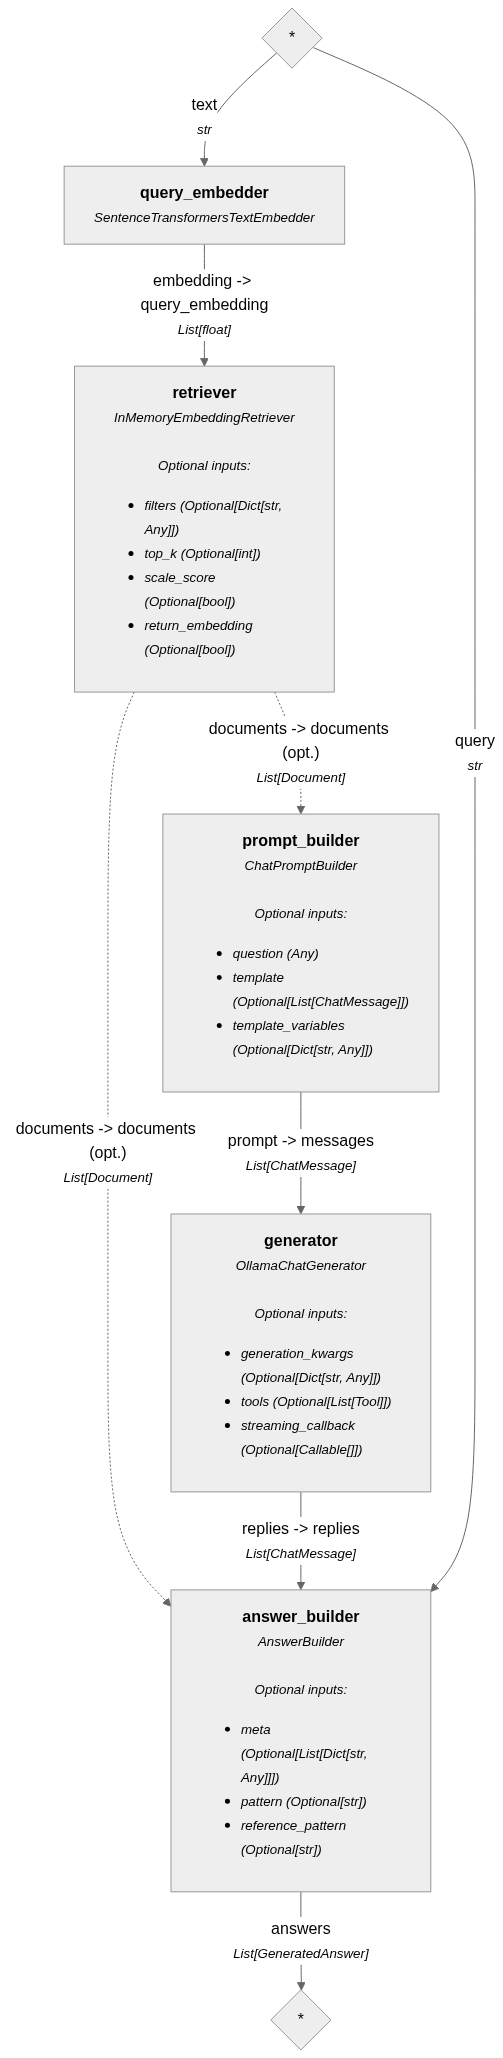

In [18]:
rag_pipeline.show()

## Testing the RAG Pipeline

Test the pipeline with a sample question to ensure it works correctly.

In [19]:
# Sample question
question = "Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?"

In [20]:
# Run the pipeline
response = rag_pipeline.run(
    {
        "query_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question},
    }
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

#### pubmedbert-base-embeddings

In [25]:
# Print the answer
print("Question:", question)
print("Answer:", response["answer_builder"]["answers"][0].data)

Question: Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?
Answer:  Yes, based on the provided context, high levels of procalcitonin (PCT) in the early phase after pediatric liver transplantation are associated with a poor postoperative outcome. Patients with high PCT levels had higher International Normalized Ratio values, suffered more often from primary graft non-function, had a longer stay in the pediatric intensive care unit and on mechanical ventilation. However, there was no correlation between PCT elevation and systemic infection.


#### GIST-large-Embedding-v0

In [ ]:
# Print the answer
print("Question:", question)
print("Answer:", response["answer_builder"]["answers"][0].data)

Question: Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?
Answer:  Yes, according to the provided context, high levels of procalcitonin (PCT) on postoperative day 2 in pediatric liver transplant recipients are associated with a higher International Normalized Ratio value on postoperative day 5, more instances of primary graft non-function, longer stays in the pediatric intensive care unit, and longer duration on mechanical ventilation. However, it is important to note that PCT levels were not correlated with systemic infection.


#### BioLORD

In [ ]:
# Print the answer
print("Question:", question)
print("Answer:", response["answer_builder"]["answers"][0].data)

Question: Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?
Answer:  Yes, according to the provided context, high levels of procalcitonin (PCT) in the early phase after pediatric liver transplantation are associated with a poorer postoperative outcome. Specifically, patients with high PCT levels on postoperative day 2 had higher International Normalized Ratio values on postoperative day 5, suffered more often from primary graft non-function, had a longer stay in the pediatric intensive care unit and on mechanical ventilation. However, it is important to note that there was no correlation between PCT elevation and systemic infection.


#### b1ade-embed-kd

In [ ]:
# Print the answer
print("Question:", question)
print("Answer:", response["answer_builder"]["answers"][0].data)

Question: Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?
Answer:  Yes, based on the provided context, patients with high PCT levels on postoperative day 2 had a higher incidence of primary graft non-function, longer stay in the pediatric intensive care unit, and a longer duration on mechanical ventilation. They also had higher International Normalized Ratio values on postoperative day 5. Therefore, high PCT levels in the early phase after pediatric liver transplantation appear to indicate a poor postoperative outcome.


#### all-MiniLM-L6-v2

In [ ]:
# Print the answer
print("Question:", question)
print("Answer:", response["answer_builder"]["answers"][0].data)

Question: Do high levels of procalcitonin in the early phase after pediatric liver transplantation indicate poor postoperative outcome?
Answer:  Yes, based on the provided context, high levels of procalcitonin (PCT) in the early phase after pediatric liver transplantation are associated with a higher International Normalized Ratio (INR) value on postoperative day 5, a longer stay in the pediatric intensive care unit (p<0.01), and a longer duration of mechanical ventilation (p=0.001). Additionally, patients with high PCT levels had a higher incidence of primary graft non-function (p<0.05). These findings suggest that high levels of PCT in the early phase after pediatric liver transplantation may indicate a poor postoperative outcome. However, it is important to note that there was no correlation between PCT elevation and systemic infection in this study.


## Evaluating the RAG Pipeline
Evaluate the pipeline using MRR, SAS, and Faithfulness metrics on 100 randomly selected questions.


In [21]:
import random

In [22]:
# Set a fixed random seed for reproducibility
random.seed(42)

In [23]:
# Select 100 random questions and corresponding ground truth
questions, ground_truth_answers, ground_truth_docs = zip(
    *random.sample(list(zip(all_questions, all_ground_truth_answers, all_documents)), 100)
)

In [24]:
# Run the RAG pipeline on the selected questions
rag_answers = []
retrieved_docs = []

#### pubmedbert-base-embeddings

In [26]:
for question in questions:
    response = rag_pipeline.run(
        {
            "query_embedder": {"text": question},
            "prompt_builder": {"question": question},
            "answer_builder": {"query": question},
        }
    )
    print(f"Question: {question}")
    print("Answer:", response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")
    rag_answers.append(response["answer_builder"]["answers"][0].data)
    retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is b lymphopenia in uremia related to an accelerated in vitro apoptosis and dysregulation of Bcl-2?
Answer:  Yes, the context indicates that B lymphopenia in uremia is related to an accelerated in vitro apoptosis and dysregulation of Bcl-2. The text states that lymphocytes from pre-dialysis and haemodialysis patients had a higher rate of apoptosis in vitro than those from healthy controls, with the effect being more pronounced in B lymphocytes. Additionally, it mentions a significantly lower in vitro Bcl-2 expression in these patients, suggesting dysregulation of this protein involved in preventing apoptosis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does obstructive sleep apnea syndrome increase pedestrian injury risk in children?
Answer:  Yes, according to the provided context, children with Obstructive Sleep Apnea Syndrome (OSAS) are riskier pedestrians than healthy children of the same age, race, and sex. This implies that OSAS could potentially increase the risk of pedestrian injuries in children. However, it is important to note that this study focused on pedestrian behavior within a virtual reality environment and did not directly measure pedestrian injuries or accidents. Further research would be needed to confirm if this increased risk translates to a higher incidence of real-world pedestrian injuries.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do spinal manipulation force and duration affect vertebral movement and neuromuscular responses?
Answer:  Yes, based on the provided context, both the force and duration of spinal manipulation have a significant impact on vertebral movement (displacement) and neuromuscular responses. Increasing the force amplitude results in a larger displacement and acceleration response, while decreasing the thrust pulse duration leads to reduced vertebral displacement but increased segmental acceleration. The normalized electromyographic responses also increase with increasing force amplitude, and are affected by mechanical excitation pulse duration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does polymyxin B prevent increased sympathetic activity and alveolar macrophage tumor necrosis factor release in parenterally fed rats?
Answer:  Yes, according to the provided context, polymyxin B appears to decrease urinary norepinephrine excretion (a measure of sympathetic activity) and alveolar macrophage tumor necrosis factor production in parenterally fed rats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is better life expectancy in women with BRCA2 compared with BRCA1 mutations attributable to lower frequency and later onset of ovarian cancer?
Answer:  Based on the provided context, it is not entirely accurate to say that better life expectancy in women with BRCA2 compared to BRCA1 mutations is attributable to a lower frequency and later onset of ovarian cancer. While there is a significant reduction in life expectancy for BRCA1 carriers compared to BRCA2 (P = 0.0002), this effect was mainly due to an increased death rate from ovarian cancer (P = 0.04) in BRCA1 carriers, not necessarily a lower frequency or later onset of ovarian cancer in BRCA2 carriers. The text does mention that Kaplan-Meier analysis revealed a better long-term survival from early-stage ovarian cancer in BRCA2 carriers, but it doesn't indicate a lower incidence or later onset of the disease.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does cognitive executive performance influence functional outcome in euthymic type I bipolar disorder outpatients?
Answer:  Yes, cognitive executive performance does appear to influence functional outcome in euthymic Type I bipolar disorder outpatients. The study indicates that patients with Bipolar Disorder Type I reached poorer scores in mental flexibility, plan implementing, set-shifting, and fluency tasks when compared to non-psychiatric patients (p<0.05). Additionally, better use of leisure time, higher competence for independent living, and holding a skilled type of profession were significantly associated with a better performance on planning, set-shifting, and fluency tasks within the EutBDI group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does lung-targeted RNA interference against angiopoietin-2 ameliorate multiple organ dysfunction and death in sepsis?
Answer:  Yes, the laboratory and animal research suggest that lung-targeted RNA interference against angiopoietin-2 can ameliorate multiple organ dysfunction and improve survival in sepsis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do identification of two metallothioneins as novel inhalative coffee allergens cof a 2 and cof a 3?
Answer:  Yes, identification of two metallothioneins as novel inhalative coffee allergens Cof a 2 and Cof a 3 was found in the provided context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are cDKN2A ( p16 ) and HRAS frequently mutated in vulvar squamous cell carcinoma?
Answer:  Yes, cDKN2A (p16) and HRAS are frequently mutated in vulvar squamous cell carcinomas (VSCCs). In the provided context, it was stated that of 107 VSCCs, 14 (or approximately 13%) had a mutation in cDKN2A(p16), and 10 (approximately 9%) had a mutation in HRAS. Therefore, both genes are fairly common targets for mutations in VSCCs.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is microRNA miR-155 a biomarker of early pancreatic neoplasia?
Answer:  Yes, according to the provided context, microRNA miR-155 can be considered a potential biomarker of early pancreatic neoplasia. It was found to be significantly overexpressed in intraductal papillary mucinous neoplasms (IPMNs), a non-invasive precursor lesion of pancreatic cancer, compared to matched controls and normal ducts. Additionally, miR-155 upregulation was observed in 60% of IPMN-associated pancreatic juice samples compared to none from disease controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is visceral adiposity index ( VAI ) related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome?
Answer:  Yes, visceral adiposity index (VAI) is related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome (PCOS). According to the provided context, VAI significantly positively correlates with body weight, fasting glucose, insulin, homeostasis model assessment (HOMA) score, white blood cells, platelets, uric acid, free testosterone, estradiol, total cholesterol, γ-GT, SGPT. Furthermore, a significant inverse correlation between VAI and SHBG, Matsuda index, and menstrual cycles per year was documented. Women with PCOS and menstrual disorders had significantly higher VAI and HOMA indices when compared to PCOS without menstrual disorders.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are stress and inflammatory biomarkers and symptoms associated with bioimpedance measures?
Answer:  Yes, according to the provided context, stress and inflammatory biomarkers (such as high sensitivity CRP, interleukin-6, cortisol) and medically unexplained symptoms are associated with body composition measurements by a dual frequency bioimpedance device (BIA-ACC). Specifically, total body extracellular water correlated positively with serum hsCRP and 8 p.m. salivary cortisol, but negatively with 8 a.m. salivary cortisol. Phase angle also correlated positively with 8 a.m. and negatively with 8 p.m. salivary cortisol and serum hsCRP. Additionally, both 8 a.m. and 8 p.m. salivary cortisol and serum hsCRP were associated with the presence of medically unexplained symptoms and BIA-ACC measurements.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does different approaches for interpretation and reporting of immunohistochemistry analysis result in the bone tissue - a review?
Answer:  Based on the provided context, it appears that the article does not directly discuss the application of immunohistochemistry (IHC) in bone tissue. Instead, it focuses on the interpretation and reporting of IHC results in non-small-cell lung cancer (NSCLC), specifically for the detection of anaplastic lymphoma kinase (ALK) gene rearrangements.

However, the context does mention that IHC is a widely accepted method in both clinical and experimental parts of medical science, including bone tissue. It also suggests that there is a lack of standardization in the post-analytical stage of IHC, which could potentially affect the interpretation and reporting of results in various tissues, including bone.

But to specifically answer your question about a review focusing on different approaches for interpretation and reporting of IHC analysis results

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is bRAF mutation status an independent prognostic factor for resected stage IIIB and IIIC melanoma : implications for melanoma staging and adjuvant therapy?
Answer:  Yes, the BRAF mutation status is an independent prognostic factor for resected stage IIIB and IIIC melanoma. Patients with BRAF mutations have a higher 3-year recurrence rate and shorter median recurrence-free (RFS) and disease-specific survival (DSS) compared to BRAF wild-type patients. This finding suggests that the knowledge of BRAF status may guide adjuvant use of BRAF/MEK inhibitors along with established and future therapies for these patients. However, it's important to note that the impact of BRAF tumor mutations on overall survival in advanced melanoma can be influenced by factors such as the pattern of visceral involvement, presence of brain metastases, and serum lactate dehydrogenase level.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does group B streptococcal beta-hemolysin/cytolysin directly impair cardiomyocyte viability and function?
Answer:  Yes, Group B Streptococcus beta-hemolysin/cytolysin does directly impair cardiomyocyte viability and function. Exposure to either wild-type GBS or beta h/c extracts significantly reduced both the rate and extent of contractility in HL-1 cardiomyocytes, induced necrotic and apoptotic cell death, and was associated with a loss of detectable calcium transients and mitochondrial membrane polarization. These effects were abrogated by the beta h/c inhibitor, dipalmitoyl phosphatidylcholine (DPPC).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the performance of prostate specific antigen for predicting prostate cancer maintained after a prior negative prostate biopsy?
Answer:  No, according to the provided context, the performance of prostate specific antigen (PSA) for predicting prostate cancer is not significantly improved after a prior negative prostate biopsy. The C-statistics for PSA in the first and second biopsies were both above 0.5 (indicating some predictive value), but there was no statistically significant difference between the two.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does angiotensin AT2 receptor stimulation cause neuroprotection in a conscious rat model of stroke?
Answer:  Yes, angiotensin AT2 receptor stimulation appears to cause neuroprotection in a conscious rat model of stroke, as demonstrated by the reduction in cortical infarct volume, improved motor deficit on the ledged beam test, increased neuronal survival, and minimized loss of AT2R expression in the infarcted region.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does spent culture medium from virulent Borrelia burgdorferi increase permeability of individually perfused microvessels of rat mesentery?
Answer:  Yes, spent culture medium from virulent Borrelia burgdorferi (B31-A3) increases the permeability of individually perfused microvessels in rat mesentery.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does first registry result from the newly approved ACURATE TA™ TAVI system†?
Answer:  Yes, the data provided is from the first registry of the newly approved ACURATE TA™ transcatheter aortic valve system. The patients included in this post-market, multicentre registry were treated using the device and their outcomes are discussed in the context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is n-chlorotaurine an effective antiviral agent against adenovirus in vitro and in the Ad5/NZW rabbit ocular model?
Answer:  Yes, N-chlorotaurine is an effective antiviral agent against adenovirus in both in vitro experiments and in the Ad5/NZW rabbit ocular model.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does vagus Nerve Stimulation During Rehabilitative Training improve Forelimb Recovery After Chronic Ischemic Stroke in Rats?
Answer:  Yes, the study indicates that Vagus Nerve Stimulation (VNS) during rehabilitative training can improve forelimb recovery after chronic ischemic stroke in rats. The Paired VNS group displayed an 86% recovery of strength compared to 47% for the Rehab group and 42% for the Delayed VNS group. This improvement was sustained even after the cessation of stimulation, suggesting lasting benefits.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a Novel Swine Model of Spontaneous Hypertension With Sympathetic Hyperactivity respond Well to Renal Denervation?
Answer:  Yes, the novel swine model of spontaneous hypertension with sympathetic hyperactivity responds well to renal denervation. In the provided study, it was observed that three months after the procedure, blood pressure was significantly reduced in the ablation group compared to the sham group. The BP (113.8 ± 14.4/79.4 ± 11.7 mm Hg) was sharply reduced in the ablation group compared with sham group (192.4 ± 10.5/141.2 ± 5.9 mm Hg, P < 0.01). Renal nerves were substantially destroyed, while renal arteries and function were not significantly affected by ablation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is an increased arginase activity associated with corpus cavernosum impairment induced by hypercholesterolemia?
Answer:  Yes, an increased arginase activity is associated with corpus cavernosum impairment induced by hypercholesterolemia. The study shows that total arginase activity and arginase type II protein expression were increased in the corpus cavernosum of hypercholesterolemic mice compared with wild-type mice. Long-term treatment with a selective arginase inhibitor normalized this alteration, suggesting that arginase activity contributes to the impairment observed in these mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is common variation in the NOS1AP gene associated with reduced glucose-lowering effect and with increased mortality in users of sulfonylurea?
Answer:  Yes, common variation in the NOS1AP gene is associated with an increased mortality risk and potentially a reduced glucose-lowering effect in users of sulfonylurea.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sUMOylation of the α-kleisin subunit of cohesin required for DNA damage-induced cohesion?
Answer:  Yes, SUMOylation of the α-kleisin subunit of cohesin is required for DNA damage-induced cohesion. The study shows that Mcd1 (Scc1) SUMOylation-deficient alleles fail to establish damage-induced cohesion both at DNA double-strand breaks and undamaged chromosomes.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ Tongxinluo improve vascular endothelial function in patients with type 2 diabetes ]?
Answer:  Yes, Tongxinluo improves vascular endothelial function in patients with type 2 diabetes. The study showed that flow-mediated dilation significantly increased from (8.19 +/- 0.71)% to (12.47 +/- 0.98)% after 4 weeks of Tongxinluo therapy, compared to the baseline level (P < 0.05). Additionally, plasma NO levels were significantly increased and plasma ET levels significantly reduced post 4 week Tongxinluo therapy, whereas these parameters remained unchanged in the placebo group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does effect of curing regime on the cytotoxicity of resin-modified glass-ionomer lining cement applied to an odontoblast-cell line?
Answer:  The study does not provide information on whether the effect of curing regime influences the cytotoxicity of both resin-modified glass-ionomer lining cements (Fuji Lining LC and Vitrebond) when applied to an odontoblast-cell line. However, it was noted that Fuji Lining LC showed increased cytotoxicity in the absence of light-curing, while this was not observed for Vitrebond, suggesting a potential effect related to curing regimes. The length of light-curing (15, 30 or 45 s) did not influence the toxicity of both lining materials when they were applied on the odontoblast-cell line MDPC-23.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do a simplified method of preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery?
Answer:  Yes, the context provides a solution for preventing implant hex drive from accidental ingestion or aspiration during stage two implant recovery. The dental floss is used to stabilize the hex drive and tied to the operator's finger ring. This method showed excellent grip of the instrument during the uncover time and saved operators time, as it can be easily retrieved if needed.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a DNA microarray facilitate the diagnosis of Bacillus anthracis in environmental samples?
Answer:  Yes, based on the provided context, a DNA microarray does facilitate the diagnosis of Bacillus anthracis in environmental samples as it is used to identify B. anthracis strains among other Bacillus isolates from environmental sources.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do calcium phosphate particulates increase friction in the rat knee joint?
Answer:  Yes, according to the study presented, calcium phosphate particulates (BCP) do appear to increase friction in the rat knee joint as indicated by a 17.6% and 16.0% increase in coefficient of friction (COF) compared to the naïve state and PBS injected (sham) joints, respectively.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does options in pediatric glaucoma after angle surgery have failed?
Answer:  Yes, when angle surgery for congenital glaucoma fails, there are several options for treatment in pediatric patients, including trabeculectomy with or without adjunctive antifibrosis therapy, glaucoma drainage surgery, and cyclodestructive procedures. These options may be chosen based on factors such as age, number of prior procedures, and type of glaucoma.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do dietary gangliosides enhance in vitro lipid uptake in weanling rats?
Answer:  Yes, according to the provided context, feeding a GANG-enriched diet does not alter weight gain or intestinal morphology in weanling rats, but it enhances in vitro intestinal lipid uptake, particularly of stearic acid (18:0) in the ileum and stearic and linoleic acid (18:2) in the jejunum. However, this increase is not associated with a change in the abundance of certain lipid binding proteins.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do thyroid hormones affect recovery from depression during antidepressant treatment?
Answer:  Yes, the levels of thyroid hormones may influence the response to antidepressants in depression. In this study, higher levels of Thyroid Stimulating Hormone (TSH) were correlated with less severe but more resistant forms of depressive disorder, suggesting a possible association with poorer response to antidepressant treatment. On the other hand, high total thyroxine levels were associated with more severe depression, but interestingly, they favored the response to antidepressants. However, a diagnosis of subclinical hypothyroidism (indicated by TSH levels) was overall associated with a poor response to antidepressant treatment.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do hepatotoxin-induced changes in the adult murine liver promote MYC-induced tumorigenesis?
Answer:  Yes, hepatotoxins such as 5-diethoxycarbonyl-1,4-dihydrocollidine (DDC) and carbon tetrachloride (CCl(4)) cooperate with MYC overexpression to greatly accelerate the onset of liver cancer in an adult host. The hepatotoxin-enhanced liver tumors grossly and histologically resemble embryonic and neonatal liver tumors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is adiponectin in umbilical cord blood inversely related to low-density lipoprotein cholesterol but not ethnicity?
Answer:  Yes, according to the provided context, adiponectin in umbilical cord blood is inversely related to low-density lipoprotein cholesterol (LDL-C), but no significant ethnic differences were found in cord adiponectin or lipids with the exception of triglycerides.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a trabecular plate-like phenotype overrepresented in Chinese-American versus Caucasian women?
Answer:  Yes, according to the provided context, a trabecular plate-like phenotype is overrepresented in Chinese-American women compared to Caucasian women. Women with a plate-like phenotype were 25.7 times more likely to be Chinese-American than women with rod-like morphology.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are preoperative white matter lesions independent predictors of long-term survival after internal carotid endarterectomy?
Answer:  Yes, according to the context provided, preoperative white matter lesions (WMLs) are independent predictors of long-term survival after internal carotid endarterectomy. This is based on the results of the study where WMLs remained independently associated with increased long-term mortality (HR 3.83, 95% CI 1.17-12.5; p < 0.05).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does menstrual cycle influence on pain and emotion in women with fibromyalgia?
Answer:  Yes, the menstrual cycle does appear to influence pain and emotions in women with fibromyalgia. Women with fibromyalgia experienced more pain and negative affect during both the follicular and luteal phases compared to women with rheumatoid arthritis and healthy controls. However, all women reported less positive affect during the luteal phase, although this pattern was more pronounced in women with FM and RA than in controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does interferon α-2b gain high sustained response therapy for advanced essential thrombocythemia and polycythemia vera with JAK2V617F positive mutation?
Answer:  Yes, according to the provided context, Interferon α-2b gains a high sustained response therapy for Essential Thrombocythemia (ET) and Polycythemia Verba (PV) with JAK2V617F positive mutation. For ET patients with JAK2V617F(+), there was a greater advantage in overall hematologic response (OHR) to IFN α-2b therapy than those with JAK2V617F(-). Similarly, for PV patients with JAK2V617F(+), IFN had a greater five-year Progression-Free Survival (PFS) than Hydroxyurea (HU). However, the text does not specify if this response is high or advanced.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does psychosocial and lifestyle correlate of premenstrual symptoms among military women?
Answer:  Yes, there are several psychosocial and lifestyle factors that are correlated with the prevalence of premenstrual symptoms in military women. These include younger age, trying to lose weight, heavier drinking, poorer self-perceived health, and overall job stress. Additionally, women reporting premenstrual symptoms were more likely to report other symptoms of menstrual dysfunction, two or more current medical conditions, migraines, and healthcare provider visits in the past year. The study also mentions that taking Depo-Provera and ever being pregnant have a protective effect against premenstrual symptoms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are suicidal adverse events in pediatric randomized , controlled clinical trials of antidepressant drugs associated with active drug treatment : a meta-analysis?
Answer:  Yes, the meta-analysis suggests that there is an association between suicidal adverse events in pediatric randomized controlled clinical trials of antidepressant drugs and active drug treatment. The combined incidence rate ratio across all trials for serious suicidal adverse events was 1.89 (95% Confidence Interval, 1.18-3.04).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the brain in the age of old : the hippocampal formation targeted differentially by diseases of late life?
Answer:  Yes, according to the provided context, the brain in the age of old is targeted differentially by diseases of late life with respect to the hippocampal formation. The text mentions that diabetes and brain infarcts were associated with dysfunction in separate hippocampal subregions. This suggests distinct underlying mechanisms for each disease, implicating blood glucose as a pathogenic mechanism for the subregion linked to diabetes and transient hypoperfusion for the subregion linked to infarcts.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does luteolin alleviate bronchoconstriction and airway hyperreactivity in ovalbumin sensitized mice?
Answer:  Yes, according to the provided context, luteolin does alleviate bronchoconstriction and airway hyperreactivity in ovalbumin-sensitized mice. This was observed when luteolin was administered orally during the entire period of sensitization (0 to 23 days) at a dose of 0.1 mg/kg body weight.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does computer simulation of lumbar flexion show shear of the facet capsular ligament?
Answer:  Yes, according to the provided context, a computer simulation of lumbar flexion does indeed show inhomogeneous in-plane and through-plane shear deformations on both surfaces of the lumbar facet capsular ligament (FCL). This is based on the findings of the first study which states that inhomogeneous shear deformations were prominent throughout the middle body of the FCL on both surfaces during simulated flexion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the correlation between the hyperacusis questionnaire and uncomfortable loudness levels dependent on emotional exhaustion?
Answer:  Yes, the correlation between the hyperacusis questionnaire (HQ) and uncomfortable loudness levels (ULLs) is dependent on emotional exhaustion. The correlations were found to be significant for individuals with intermediate and high emotional exhaustion levels but not with low EE levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gemcitabine induce Radiosensitization Through Inhibition of RAD51-dependent Repair for DNA Double-strand Breaks?
Answer:  Yes, based on the provided context, gemcitabine (GEM) appears to induce radiosensitization through inhibition of RAD51-dependent repair for DNA double-strand breaks. This is supported by the findings that GEM pre-treatment leads to enhanced cell killing effects in radiotherapy, significantly higher numbers of phospho-H2AX foci (a marker of DNA double-strand breaks) after irradiation in treated cells compared to untreated cells, and inhibition of the formation and degradation of RAD51 foci by GEM pre-treatment. Furthermore, the radiosensitizing effect of GEM was suppressed by knockdown of RAD51.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does increasing functional variability in the preparatory phase of the takeoff improve elite springboard diving performance?
Answer:  Yes, increasing functional variability in the preparatory phase of the takeoff seems to improve elite springboard diving performance. The study indicates that a training program designed to encourage movement pattern adaptation under variable takeoff conditions led to an increase in the number of completed dives and a decrease in balked takeoffs, as well as greater consistency in the divers' performance during practice as scored by qualified judges. These findings suggest that functional variability can positively impact elite springboard diving performance.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mechanical unloading improve intracellular Ca2+ regulation in rats with doxorubicin-induced cardiomyopathy?
Answer:  Yes, according to the context provided, mechanical unloading improves intracellular Ca^{2+} regulation in rats with doxorubicin-induced cardiomyopathy. This improvement is indicated by the reduction of the duration of cell shortening and [Ca^{2+}]_{i} transients in cardiomyocytes after mechanical unloading. The levels of sarcoplasmic reticulum Ca^{2+} ATPase (SERCA2a) protein, which regulates intracellular Ca^{2+}, also increased significantly in the unloaded hearts compared to non-unloaded hearts. However, it's important to note that the levels of other intracellular Ca^{2+}-regulatory proteins, such as phospholamban and ryanodine receptor, were not altered after mechanical unloading in doxorubicin-treated hearts.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does carvacrol alleviate ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats?
Answer:  Yes, according to the provided context, carvacrol has been shown to alleviate ischemia reperfusion injury in rat livers. The protective effects of carvacrol are partially attributed to its anti-oxidative activity, which involves the regulation of superoxide dismutase (SOD), catalase (CAT), glutathione (GSH), and malondialdehyde (MDA). Additionally, carvacrol has been demonstrated to modulate the expression of proteins related to apoptosis, such as Bax and Bcl-2, as well as the activation of caspase-3. The context suggests that these mechanisms may be linked to the phosphatidylinositol 3-kinase (PI3K)-Akt pathway, but it does not directly state that carvacrol regulates this pathway. However, the protective effects of remote ischemic postconditioning (RIP) against limb ischemia-reperfusion injury involve the PI3K-Akt pathway, so there may be a connection between carvacrol a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is tumor necrosis factor-α expression in patients with obstructive benign prostatic hyperplasia associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification?
Answer:  Yes, according to the study provided, tumor necrosis factor-α (TNF-α) expression in patients with obstructive benign prostatic hyperplasia (BPH) is associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calculi.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is down-Regulation of microRNA-132 Associated with Poor Prognosis of Colorectal Cancer?
Answer:  Yes, the down-regulation of microRNA-132 is associated with a poor prognosis in colorectal cancer.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sMAC expressed de novo in a subset of cervical cancer tumors?
Answer:  Yes, according to the provided context, sMAC (Smac/Diablo) is expressed de novo in a subset of cervical cancer tumors. Specifically, 13 out of 41 cervical cancer biopsies showed detectable levels of Smac mRNA.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cannabinoid type 1 receptors in human skeletal muscle cells participate in the negative crosstalk between fat and muscle?
Answer:  Yes, the data suggests that cannabinoid type 1 receptors in human skeletal muscle cells do participate in the negative crosstalk between fat and muscle. The study shows an increase of CB1R protein in SkM during differentiation, and incubation with adipocyte-conditioned medium or anandamide impaired insulin-stimulated Akt phosphorylation and glucose uptake, which can be prevented by CB1R antagonists.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does maternal high-fat hypercaloric diet during pregnancy result in persistent metabolic and respiratory abnormalities in offspring?
Answer:  Yes, according to the provided context, a maternal high-fat hypercaloric diet during pregnancy does result in persistent metabolic abnormalities throughout the offspring's development. In addition, these offspring also exhibited respiratory abnormalities such as higher resistance and lower compliance in their respiratory system and increased reactivity to methacholine. Furthermore, newborns from high-fat diet dams were more prone to developing more severe disease after respiratory syncytial virus (RSV) infection.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does preservation of the rectus femoris origin during periacetabular osteotomy compromise acetabular reorientation?
Answer:  No, the modified approach for Periacetabular Osteotomy (PAO) that spares the rectus femoris origin does not compromise acetabular reorientation. The study found that there was no significant difference in acetabular reorientation based on postoperative radiographs between patients who underwent PAO with the standard approach and those who underwent the modified rectus-sparing approach.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does viral challenge reveal further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds?
Answer:  Yes, the study shows that African Americans from disadvantaged backgrounds who display indications of skin-deep resilience (i.e., high in conscientiousness and good psychosocial functioning) are more susceptible to upper respiratory infection following viral challenge compared to their counterparts with lower levels of conscientiousness. This suggests that while these individuals may demonstrate resilience in various aspects of life, they may be less resilient when it comes to certain health-related challenges.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is maternal factor V Leiden mutation associated with HELLP syndrome in Caucasian women?
Answer:  Yes, there is a significant association between maternal heterozygosity for the factor V Leiden mutation and HELLP syndrome in Caucasian women. In the study mentioned, 18.4% of the women in the HELLP group were heterozygous carriers compared to only 6.6% in the control group (OR = 3.19).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does multidimensional endotyping in patients with severe asthma reveal inflammatory heterogeneity in matrix metalloproteinases and chitinase 3-like protein 1?
Answer:  Yes, the multidimensional endotyping of patients with severe asthma reveals inflammatory heterogeneity in matrix metalloproteinases (MMPs) and chitinase 3-like protein 1 (YKL-40). The analysis identifies six clinicopathobiologic clusters, each characterized by distinct patterns of MMP and YKL-40 levels. Severe asthma is associated with increased sputum levels of several MMPs (MMP 1, 3, 8, and 12) and elevated YKL-40 levels, which strongly correlate with neutrophilic asthma. Additionally, MMP-9 release from neutrophils is observed in allergic asthmatic patients upon allergen challenge, suggesting the involvement of these cells in inflammatory conditions associated with MMPs.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do morbidity of early spine surgery in the multiply injured patient?
Answer:  Yes, according to the provided context, the morbidity of early spine surgery in multiply injured patients is higher compared to stable patients. This is evident from the fact that borderline unstable patients had significantly higher operative time, blood loss, PRBCs transfused intra-op, and total PRBCs transfused in theater. However, it's important to note that this study does not establish a cause-and-effect relationship, but rather observes an association between the two variables.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are oxytocin-induced contractions within rat and rabbit ejaculatory tissues mediated by vasopressin V1A receptors and not oxytocin receptors?
Answer:  Yes, the study suggests that oxytocin-induced contractions in rat and rabbit ejaculatory tissues are primarily mediated by vasopressin V1A receptors, as opposed to oxytocin receptors. This is indicated by the fact that the selective oxytocin agonist [Thr4,Gly7]-oxytocin did not contract these tissues, while the V1A antagonist SR49059 potently antagonized the contractions. However, a weak antagonism by the selective oxytocin antagonist L-368899 was also observed, suggesting that there might be some involvement of oxytocin receptors as well, albeit to a lesser extent.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does iL-12 regulate B7-H1 expression in ovarian cancer-associated macrophages by effects on NF-κB signalling?
Answer:  Yes, IL-12 regulates B7-H1 expression in ovarian cancer-associated macrophages through effects on the NF-κB signaling pathway. The upregulation of B7-H1 was observed in monocyte-derived macrophages treated with IL-12 and was accompanied by activation of NF-κB signaling. Moreover, blocking the NF-κB signaling pathway inhibited the upregulation of B7-H1.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is preoperative cerebral blood flow diminished in neonates with severe congenital heart defects?
Answer:  Yes, preoperative cerebral blood flow is substantially diminished in a significant percentage of neonates with severe congenital heart defects. The study mentioned that 5 out of 25 patients had cerebral blood flow measurements of less than 10 mL . 100 g -1 . min -1 , suggesting a substantial reduction compared to the average baseline value. Additionally, a lower baseline cerebral blood flow was associated with periventricular leukomalacia in these neonates (P = .05).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is elevated plasma phospholipid transfer protein activity a determinant of carotid intima-media thickness in type 2 diabetes mellitus?
Answer:  Yes, the text indicates that in type 2 diabetes mellitus patients, there is an independent association between carotid intima-media thickness (IMT) and plasma phospholipid transfer protein (PLTP) activity. However, it's important to note that this relationship was not significant in control subjects.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are pTEN and PDCD4 bona fide targets of microRNA-21 in human cholangiocarcinoma?
Answer:  Yes, PTEN and PDCD4 are bona fide targets of microRNA-21 in human cholangiocarcinoma. The dual luciferase reporter gene assay revealed that endogenous microRNA-21 inhibited the luciferase reporter activities of wild-type PTEN (P<0.01) and PDCD4 (P<0.05), indicating that these genes are direct targets of microRNA-21 in cholangiocarcinoma cells. Furthermore, loss of microRNA-21 function led to a significant increase of PTEN and PDCD4 protein levels in QBC939 cells, supporting the notion that microRNA-21 negatively regulates these targets in this cell line.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gene expression profiling reveal novel TGFbeta targets in adult lung fibroblasts?
Answer:  Yes, the study reveals novel TGFbeta targets in adult lung fibroblasts. Specifically, they focus on genes not previously found to be regulated by TGFbeta in lung fibroblasts or other cell types, including nuclear co-repressor 2, SMAD specific E3 ubiquitin protein ligase 2 (SMURF2), bone morphogenetic protein 4, and angiotensin II receptor type 1 (AGTR1). These targets were confirmed by real time-PCR and Western Blotting.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are the expression of efflux and uptake transporters regulated by statins in Caco-2 and HepG2 cells?
Answer:  Yes, the expression of efflux and uptake transporters is regulated by statins in Caco-2 and HepG2 cells. The specific changes in mRNA levels vary between the two cell types for different transporters after treatment with atorvastatin or simvastatin. For instance, in HepG2 cells, ABCB1, ABCG2, and SLCO2B1 were up-regulated, while in Caco-2 cells, only ABCB1 was significantly down-regulated by atorvastatin, and both ABCB1, ABCC2, SLC22A1, and SLCO2B1 were down-regulated by simvastatin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does epinephrine prevent muscle blood flow increases after perineural injection of tetrodotoxin?
Answer:  Yes, based on the provided context, epinephrine does prevent an increase in muscle blood flow after perineural injection of tetrodotoxin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intracoronary verapamil rapidly terminate reperfusion tachyarrhythmias in acute myocardial infarction?
Answer:  Yes, intracoronary verapamil was effective in rapidly terminating most (except for ventricular fibrillations) reperfusion-induced tachyarrhythmias in acute myocardial infarction.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are excessive reactive oxygen species therapeutic targets for intervertebral disc degeneration?
Answer:  Yes, excessive Reactive Oxygen Species (ROS) are potential therapeutic targets for Intervertebral Disc Degeneration. The provided context shows that ROS contribute to IVD degeneration and the catabolic effects of excessive ROS can be abrogated by antioxidant treatment such as N-acetyl cysteine (NAC), both in vitro and in vivo. Additionally, ROS generating molecules inhibit gene expressions related to disc degeneration, suggesting that reducing ROS levels could potentially slow or reverse the degenerative process.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage reduce hemorrhage progression and mortality?
Answer:  Yes, according to the provided context, rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage appears to reduce hemorrhage progression rates and mortality. In the first study, the 10% mortality rate in the group that received rapid reversal is significantly less than the previous 48% mortality rate seen in similar patients, suggesting a reduction in mortality. However, it's important to note that both deaths in the rapid reversal group occurred more than 10 hours after injury with a severe ICH, which might have influenced the outcome. The second study does not directly address the question of hemorrhage progression and mortality but suggests that achieving full warfarin reversal is associated with a lower risk of anticoagulation reversal failure, which could potentially contribute to reduced he

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does short-hairpin RNA-mediated MTA2 silencing inhibit human breast cancer cell line MDA-MB231 proliferation and metastasis?
Answer:  Yes, the short-hairpin RNA-mediated silencing of MTA2 has been shown to inhibit both the proliferation and metastasis of the human breast cancer cell line MDA-MB231. This is evident from the significantly reduced mRNA and protein levels of MTA2, along with the inhibited cell proliferation and metastasis as assessed by various assays (p<0.05). Additionally, xenograft model studies have demonstrated smaller tumor sizes and lower numbers of metastatic deposits in the lungs of mice infected with Lv-shMTA2 compared to control group mice (p<0.05).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does beta-catenin mediate the apoptosis induction effect of celastrol in HT29 cells?
Answer:  Yes, according to the context provided, beta-catenin appears to mediate the apoptosis induction effect of celastrol in HT29 cells. The treatment of HT29 cells with celastrol resulted in increased nuclear translocation of beta-catenin, and the apoptosis induction effects of celastrol were significantly attenuated by beta-catenin siRNA transfection. This suggests that beta-catenin plays a role in the apoptosis-inducing effect of celastrol on HT29 cells.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mitral regurgitation reduce systemic coagulation activity in patients with rheumatic heart disease?
Answer:  Yes, according to the provided context, severe mitral regurgitation reduces left atrial thrombus formation and consequently, systemic coagulation activity, as indicated by lower D-dimer levels. This is particularly observed in patients with mitral valve disease and severe mitral regurgitation. However, it's important to note that this observation was made in the context of rheumatic heart disease and atrial fibrillation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glutamine restore Tight Junction Protein Claudin-1 Expression in Colonic Mucosa of Patients With Diarrhea-Predominant Irritable Bowel Syndrome?
Answer:  Yes, the study indicates that glutamine can increase the expression of tight junction protein Claudin-1 in colonic mucosa of patients with diarrhea-predominant irritable bowel syndrome. This effect is more pronounced when tight junction protein expression is altered.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intraileal carbohydrate regulate canine postprandial pancreaticobiliary secretion and upper gut motility?
Answer:  Yes, the study suggests that intraileal carbohydrate does regulate canine postprandial pancreaticobiliary secretion and upper gut motility. Carbohydrate infusion in the ileum increased amylase secretion, plasma peptide YY, slowed gastric emptying of liquids and solids, slowed small intestinal transit, and decreased bile acid delivery into the duodenum.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are v600E BRAF mutations alternative early molecular events in a subset of KIT/PDGFRA wild-type gastrointestinal stromal tumours?
Answer:  Yes, v600E BRAF mutations are detected in a subset (4%) of imatinib-naive high-risk intestinal GISTs that lack KIT and PDGFRA mutations. However, the frequency and distribution of these mutations within the spectrum of GISTs, and whether they might represent early molecular events acquired during tumour progression, remain unknown based on the provided context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer durable for 10 years in a simulated in vitro model?
Answer:  Yes, the sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer appears to be durable for 10 years based on the results of the in vitro testing as described in the context. The grafts successfully completed accelerated pulsatile fatigue testing at 94±14-mmHg pulse pressure, showing no significant changes in surface topography, mechanical properties, or thermal resistance compared to a zero-cycled control after 400 million cycles. However, it's important to note that this is an in vitro study and the durability of these stent-grafts under real-life conditions may vary. Further clinical studies are necessary to confirm the long-term performance of these devices.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cochlear implant fixation using polypropylene mesh and titanium screws?
Answer:  Yes, the provided context states that cochlear implants are fixed using polypropylene mesh and titanium screws.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do soluble donor DNA concentrations in recipient serum correlate with pancreas-kidney rejection?
Answer:  Yes, according to the provided context, soluble donor DNA concentrations in recipient serum do correlate with pancreas-kidney rejection. Recipients who had experienced allograft rejection had higher donor DNA concentrations than those who had not.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is human degenerative valve disease associated with up-regulation of low-density lipoprotein receptor-related protein 5 receptor-mediated bone formation?
Answer:  Yes, human degenerative valve disease is associated with up-regulation of low-density lipoprotein receptor-related protein 5 (Lrp5) receptor-mediated bone formation. The research shows that Lrp5, osteocalcin, and other osteochrondrogenic differentiation markers are increased in both calcified aortic valves and myxomatous mitral valves by protein and gene expression. This implies an active process of bone formation, which could contribute to the degeneration seen in these valves.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the alpha1A-adrenoceptor gene required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate?
Answer:  Yes, the alpha1A-adrenoceptor gene appears to be required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate. The study shows that prostates from mice homozygous for the disrupted alpha1A-adrenoceptor gene (alpha1A -/-) exhibited approximately 30% decreased response compared with wild-type (alpha1A +/+) littermates in responses to electrical field stimulation and a significantly reduced maximum response to noradrenaline. The fact that prazosin, an alpha1-adrenoceptor antagonist, did not attenuate the responses in prostates from alpha1A -/- mice further supports this conclusion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are clinical Experiences Predictive of Outcomes on the NATABOC Examination?
Answer:  No, based on the provided context, clinical experiences are not predictive of outcomes on the NATABOC examination.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does changes in lung sound during asthma progression in a guinea pig model?
Answer:  Yes, changes in lung sounds during asthma progression have been observed in the provided guinea pig model. The study indicates that the inspiratory sound intensity differed significantly between the asthma models and controls, suggesting changes in lung sounds over time. Additionally, the ratio of airway wall thickness to total airway area in the terminal bronchioles was greater in the asthma models compared to the controls, and this correlated best with the changes in inspiratory sound intensity in the 501-1000 Hz range.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is femoral nerve blockade administered preclinically for pain relief in severe knee trauma more feasible and effective than intravenous metamizole : a randomized controlled trial?
Answer:  Yes, according to the provided context, a femoral nerve blockade administered preclinically for pain relief in severe knee trauma appears to be more feasible and effective than intravenous metamizole, based on the results of the randomized controlled trial. In the trial, patients receiving a femoral nerve blockade showed significant reductions in pain and anxiety scores, as well as less peripheral vasoconstriction at the injury site compared to those receiving metamizole. Additionally, the femoral nerve blockade group required significantly less morphine consumption for postoperative pain relief than the control group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is matrix metalloproteinase 10 associated with disease severity and mortality in patients with peripheral arterial disease?
Answer:  Yes, matrix metalloproteinase 10 (MMP-10) is associated with disease severity and mortality in patients with peripheral arterial disease (PAD). The study found that PAD patients presented with increased levels of MMP-10 compared to controls. Furthermore, among PAD patients, those with critical limb ischemia showed higher levels of MMP-10 compared with those with intermittent claudication. Additionally, the univariate analysis showed an association between MMP-10 and PAD severity that remained significantly associated after adjustment for other cardiovascular risk factors. Lastly, patients with the highest MMP-10 tertile had an increased incidence of all-cause mortality and cardiovascular mortality.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is vegetable intake associated with lower Frammingham risk scores in Korean men : Korea National Health and Nutrition Survey 2007-2009?
Answer:  Yes, the study suggests that higher vegetable intake is associated with lower Framingham Risk Scores (FRS) in Korean men aged 40-64 years. The odds of CHD risk were significantly lower for those in higher quartiles of total vegetable intake and non-salted vegetable intake, even after adjusting for potential confounders. However, no significant associations were found between the frequency of vegetable intake (total, green, white, or red) and the risk of CHD.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intestinal intraluminal injection of glutamine increase trolox total equivalent antioxidant capacity ( TEAC ) in hepatic ischemia-reperfusion?
Answer:  Yes, according to the provided context, intestinal intraluminal injection of glutamine increases trolox total equivalent antioxidant capacity (TEAC) in a hepatic ischemia-reperfusion experimental model. This was demonstrated by significantly higher TEAC values in the glutamine group compared to both the control and sham groups.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are plasma osteoprotegerin levels associated with glycaemic status , systolic blood pressure , kidney function and cardiovascular morbidity in type 1 diabetic patients?
Answer:  Yes, according to the provided context, plasma osteoprotegerin (OPG) levels are associated with glycaemic status (as measured by HbA1c), systolic blood pressure, kidney function (creatinine), and cardiovascular morbidity in type 1 diabetic patients. The associations between OPG and these factors were observed both within the overall group of type 1 diabetic patients and in specific subgroups, such as those with and without diabetic nephropathy or with and without cardiovascular diseases.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is pretreatment quality-of-life score a better discriminator of oesophageal cancer survival than performance status?
Answer:  Yes, based on the provided context, it appears that pretreatment Quality-of-Life (QOL) scores, as measured by instruments such as FACT-E and ECS, are better discriminators of overall survival in patients with Stage II-III oesophageal cancer compared to performance status (as measured by ECOG). This is supported by the fact that both FACT-E and ECS were independently associated with overall survival on Cox regression analysis, whereas ECOG was not. Additionally, the area under the curve (AUC) for FACT-E and ECS in predicting survival was greater than that of ECOG.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features?
Answer:  Yes, flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features. For instance, they have fimbriate-glandular wing petals that are not found in most other legume species, bidirectional tendencies in the formation of sepals and petals, and a single carpel that arises concomitantly with the outer stamen whorl. Additionally, gland formation starts early on the edges of the wing petals, and the carpel reopens for a short time when the initiation of ovules is visible. The flower functions like other standard flag blossoms, as indicated by stomata at the base of the hypanthium. These unique features illuminate the systematic position of the genus and foster our understanding on floral evolution during the early diversification of the papilionoid legumes.

-----------------

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does breast milk provide better antioxidant power than does formula?
Answer:  Yes, according to the provided context, breast milk provides better antioxidant power compared to formula as indicated by significantly higher plasma total antioxidant capacity (TAC) and vitamin C levels in the breast-fed group. Additionally, plasma TP levels and the oxidative stress index (OSI) were higher in the formula-fed group compared to those in the breast-fed group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do young age and pathological features predict breast cancer outcome - report from a dual Institution experience in Serbia?
Answer:  Yes, according to the study provided, both young age (≤30 years) and certain pathological features such as higher tumor grade, larger tumor size, increased number of positive nodes, lymphovascular invasion (LVI), and hormonal receptor negative status predict a worse prognosis for breast cancer in young women.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is late follicular progesterone to estradiol ratio influenced by protocols or gonadotropins used?
Answer:  Yes, according to the provided context, the Progesterone (P)/Estradiol (E2) ratio during the late follicular phase appears to be influenced by the protocols used. Specifically, a lower P/E2 ratio was observed in the long protocol compared to the antagonist protocol. There was no significant difference in the P level at hCG stimulation day between different protocols or types of gonadotropins used, but E2 levels and the P/E2 ratio were significantly lower in the long protocol compare with the antagonist protocol.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glucose modulate event-related potential components of recollection and familiarity in healthy adolescents?
Answer:  Yes, according to the provided context, glucose ingestion modulates event-related potential (ERP) components that are thought to be differentially mediated by recollection and familiarity processes in healthy adolescents. Specifically, glucose administration was associated with an enhanced left parietal old/new ERP effect (a marker of recollection), and an enhanced mid-frontal old/new ERP effect (known to be mediated by familiarity).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does plasmin induce endothelium-dependent nitric oxide-mediated relaxation in the porcine coronary artery?
Answer:  The provided context does not directly address the question about plasmin inducing endothelium-dependent nitric oxide (NO)-mediated relaxation in the porcine coronary artery. Therefore, it is not possible to accurately answer this question based on the given context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does caveolin-1 play a critical role in the differentiation of monocytes into macrophages?
Answer:  Yes, the provided context suggests that caveolin-1 plays a critical role in the differentiation of monocytes into macrophages. Overexpression of caveolin-1 increased macrophage surface markers and inflammatory genes, while knockdown or knockout decreased these. Caveolin-1 also regulates the nuclear translocation and activity of early growth response 1 (EGR-1), a key factor in monocyte differentiation, through extracellular signal-regulated kinase phosphorylation. Furthermore, caveolin-1 inhibited transmigration but promoted phagocytosis, and its absence decreased monocyte differentiation in mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do eye movements reveal impaired inhibitory control in adult male fragile X premutation carriers asymptomatic for FXTAS?
Answer:  Yes, according to the provided context, eye movements do reveal impaired inhibitory control in adult male fragile X premutation carriers who are asymptomatic for FXTAS. This is indicated by the longer saccade latency in the Antisaccade task performed by fXPCs compared to controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the Jarvik 2000 associated with less infections than the HeartMate left ventricular assist device?
Answer:  Yes, according to the provided context, the Jarvik 2000 is associated with fewer device-related infections compared to the HeartMate left ventricular assist device. The incidence of device-related infections per 100 patient-days was 0.08 for the Jarvik 2000 versus 0.43 for the HeartMate, a statistically significant difference (P=0.044).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in ischemic heart failure?
Answer:  Yes, the study suggests that retrograde coronary vein infusion of cardiac explant-derived c-Kit(+) cells improves cardiac function in a small-animal model of congestive heart failure (CHF). At 21 days post-RCV infusion, the rats treated with RCV-delivered cells showed significant improvement in cardiac function compared to vehicle-treated CHF animals.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do women 's reports of breast implant problems and silicone-related illness?
Answer:  Yes, according to the provided context, women do report breast implant problems and silicone-related illness. The study discusses themes emerging from responses of 55 women who experienced health problems they attributed to their implants.

-----------------------------------



#### GIST-large-Embedding-v0

In [ ]:
for question in questions:
    response = rag_pipeline.run(
        {
            "query_embedder": {"text": question},
            "prompt_builder": {"question": question},
            "answer_builder": {"query": question},
        }
    )
    print(f"Question: {question}")
    print("Answer:", response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")
    rag_answers.append(response["answer_builder"]["answers"][0].data)
    retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is b lymphopenia in uremia related to an accelerated in vitro apoptosis and dysregulation of Bcl-2?
Answer:  Yes, based on the provided context, B lymphopenia in uremia is related to an accelerated in vitro apoptosis and dysregulation of Bcl-2.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does obstructive sleep apnea syndrome increase pedestrian injury risk in children?
Answer:  Yes, according to the study provided, children with Obstructive Sleep Apnea Syndrome (OSAS) were found to be riskier pedestrians compared to healthy children of the same age, race, and sex. Although the study did not directly link this behavior to injury risk, it does suggest that children with OSAS may exhibit behaviors that could potentially increase their vulnerability to pedestrian accidents.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do spinal manipulation force and duration affect vertebral movement and neuromuscular responses?
Answer:  Yes, according to the provided context, both spinal manipulation force and duration can significantly affect vertebral movement and neuromuscular responses. Increasing force amplitude resulted in a linear increase in L3 vertebral displacement and adjacent segment acceleration response, while shorter thrust durations led to nearly fivefold lower L3 displacements and increased segmental acceleration compared to longer thrusts. Additionally, the normalized electromyographic responses increased linearly with increasing force amplitude and were affected by mechanical excitation pulse duration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does polymyxin B prevent increased sympathetic activity and alveolar macrophage tumor necrosis factor release in parenterally fed rats?
Answer:  Yes, the study suggests that polymyxin B prevents increased sympathetic activity, as evidenced by reduced urinary norepinephrine excretion, and alveolar macrophage tumor necrosis factor release, as demonstrated by decreased alveolar macrophage TNF production.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is better life expectancy in women with BRCA2 compared with BRCA1 mutations attributable to lower frequency and later onset of ovarian cancer?
Answer:  It is suggested that the better life expectancy in women with BRCA2 compared with BRCA1 mutations might be partially attributable to a lower frequency and potentially later onset of ovarian cancer. However, the context does not provide definitive evidence that this is the only or main reason for the observed difference in life expectancy between the two groups. Other factors may also contribute.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does cognitive executive performance influence functional outcome in euthymic type I bipolar disorder outpatients?
Answer:  Yes, cognitive executive performance appears to influence functional outcome in euthymic Type I bipolar disorder outpatients. The study indicates that patients with Bipolar Disorder Type I who were euthymic reached poorer scores in mental flexibility, plan implementing, set-shifting, and fluency compared to non-psychiatric patients (p<0.05). Additionally, better use of leisure time, higher competence for independent living, and holding a skilled type of profession were significantly associated with a better performance on planning, set-shifting, and fluency tasks within the EutBDI group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does lung-targeted RNA interference against angiopoietin-2 ameliorate multiple organ dysfunction and death in sepsis?
Answer:  Yes, based on the provided context, lung-targeted RNA interference against angiopoietin-2 ameliorates multiple organ dysfunction and improves survival in sepsis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do identification of two metallothioneins as novel inhalative coffee allergens cof a 2 and cof a 3?
Answer:  Yes, the study identifies two metallothioneins, Cof a 2 and Cof a 3, as novel inhalative coffee allergens.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are cDKN2A ( p16 ) and HRAS frequently mutated in vulvar squamous cell carcinoma?
Answer:  Yes, both CDKN2A (p16) and HRAS are frequently mutated in vulvar squamous cell carcinoma. In the study provided, 14 genes were screened, and mutations were detected in 7 of them. Out of 107 VSCCs, 14 tumors had a CDKN2A(p16) mutation, and 10 tumors had an HRAS mutation. This represents 13% (CDKN2A) and approximately 9% (HRAS) of the total number of VSCCs tested. However, it's important to note that HRAS mutations had a more significant impact on five-year survival than CDKN2A mutations, according to the study.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is microRNA miR-155 a biomarker of early pancreatic neoplasia?
Answer:  Yes, based on the provided context, microRNA miR-155 appears to be a potential biomarker for early pancreatic neoplasia. It was significantly overexpressed in non-invasive intraductal papillary mucinous neoplasms (IPMNs) compared to controls, and its expression was observed in 60% of IPMN-associated pancreatic juice samples. However, further research is needed to confirm its specificity and sensitivity as a biomarker for early detection and diagnosis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is visceral adiposity index ( VAI ) related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome?
Answer:  Yes, the visceral adiposity index (VAI) is related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome (PCOS). Women with PCOS who had menstrual disorders had significantly higher VAI compared to those without menstrual disorders. Furthermore, there was a significant correlation between VAI and parameters such as BMI, fasting insulin, homeostasis model sensitivity (HOMA %S), waist-to-hip ratio (WHR), body fat mass assessed by dual-energy X-ray-absorptiometry (DEXA) [Dexa-fat (total) and Dexa-fat (trunk)], and testosterone levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are stress and inflammatory biomarkers and symptoms associated with bioimpedance measures?
Answer:  Yes, according to the provided context, stress, inflammatory biomarkers, and medically unexplained symptoms (MUS) are associated with bioimpedance measures. Total body extracellular water (ECW), intracellular water (ICW), fat mass (FM), skeletal mass (SK), phase angle (PA), high sensitivity C-reactive protein (hsCRP), morning salivary cortisol, and evening salivary cortisol were all found to have associations with stress, inflammatory biomarkers, and MUS in the study. ECW correlated positively with serum hsCRP and 8 p.m. salivary cortisol, but negatively with 8 a.m. salivary cortisol, while PA correlated positively with 8 a.m. and negatively with 8 p.m. salivary cortisol and serum hsCRP. Both morning and evening salivary cortisol and serum hsCRP were associated with the presence of MUS and BIA-ACC measurements, including ECW, ICW, FM, SK, and PA. Additionally, rises in systolic

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does different approaches for interpretation and reporting of immunohistochemistry analysis result in the bone tissue - a review?
Answer:  Yes, based on the provided context, it appears that there are indeed different approaches for interpreting and reporting results of immunohistochemistry (IHC) analysis in bone tissue. The text mentions a comprehensive literature search identifying six major approaches to IHC analysis interpretation and presentation. However, the context does not provide a direct review or comparison of these approaches. For a comprehensive review, a more specific search focusing on comparisons between these identified approaches would be necessary.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is bRAF mutation status an independent prognostic factor for resected stage IIIB and IIIC melanoma : implications for melanoma staging and adjuvant therapy?
Answer:  Yes, based on the provided context, BRAF mutation status is an independent prognostic factor for resected stage IIIB and IIIC melanoma. Patients with BRAF mutations had a higher 3-year recurrence rate and shorter median recurrence-free (RFS) and disease-specific survival (DSS) compared to BRAF wild-type patients. These findings may guide adjuvant use of BRAF/MEK inhibitors along with established therapies for stage III melanoma patients. However, the impact of BRAF tumor mutations on the overall survival of melanoma patients is controversial, as suggested in another study where no differences in overall survival were detected according to BRAF status.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does group B streptococcal beta-hemolysin/cytolysin directly impair cardiomyocyte viability and function?
Answer:  Yes, Group B Streptococcus beta-hemolysin/cytolysin does directly impair cardiomyocyte viability and function.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the performance of prostate specific antigen for predicting prostate cancer maintained after a prior negative prostate biopsy?
Answer:  No, the performance of prostate specific antigen (PSA) for predicting prostate cancer appears to be slightly improved after a prior negative prostate biopsy. However, the improvement is not significant enough to definitively state that the predictive value is maintained or increased. The study shows that PSA has a C-statistic of 0.650 before a second biopsy and 0.664 for a second biopsy, with the latter having a statistically significantly greater than 0.5 (p <0.001). The improvement is observed in a group of men who underwent a second biopsy following a negative first biopsy. Newer tests such as %p2PSA and Prostate Health Index have shown better accuracy for predicting prostate cancer in this context, outperforming PSA in some cases.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does angiotensin AT2 receptor stimulation cause neuroprotection in a conscious rat model of stroke?
Answer:  Yes, based on the provided context, angiotensin AT2 receptor stimulation causes neuroprotection in a conscious rat model of stroke. This is demonstrated by the dose-dependent reduction of cortical infarct volume poststroke following intracerebroventricular administration of AT(2)R agonist CGP42111.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does spent culture medium from virulent Borrelia burgdorferi increase permeability of individually perfused microvessels of rat mesentery?
Answer:  Yes, spent culture medium from virulent Borrelia burgdorferi (B31-A3) does cause an increase in the permeability of individually perfused microvessels of rat mesentery.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does first registry result from the newly approved ACURATE TA™ TAVI system†?
Answer:  Yes, the first registry result provided in the context is from the ACURATE TA™ Transcatheter Aortic Valve (TAVI) system.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is n-chlorotaurine an effective antiviral agent against adenovirus in vitro and in the Ad5/NZW rabbit ocular model?
Answer:  Yes, N-chlorotaurine (NCT) is an effective antiviral agent against adenovirus (Ad) in vitro and in the Ad5/NZW rabbit ocular model. In both studies mentioned in the context, NCT demonstrated significant reduction in positive cultures of Ad compared to saline control, and also showed fewer positive cultures per total cultures, shorter durations of shedding, and lower mean combined titers during specific time periods compared to saline. However, it was found that cidofovir was significantly more effective than NCT in several outcome measures in both studies.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does vagus Nerve Stimulation During Rehabilitative Training improve Forelimb Recovery After Chronic Ischemic Stroke in Rats?
Answer:  Yes, according to the provided context, Vagus Nerve Stimulation during rehabilitative training does improve forelimb recovery after chronic ischemic stroke in rats. The study shows that rats who underwent VNS paired with rehabilitative training exhibited an 86% recovery of strength, which was significantly higher than the control groups.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a Novel Swine Model of Spontaneous Hypertension With Sympathetic Hyperactivity respond Well to Renal Denervation?
Answer:  Yes, the novel swine model of spontaneous hypertension with sympathetic hyperactivity responds well to renal denervation. In the study provided, Guizhou mini-pigs with spontaneous hypertension were divided into sham and ablation groups, where the mini-pigs in the ablation group received bilateral percutaneous renal denervation. Three months after the procedure, blood pressure was sharply reduced in the ablation group compared to the sham group. The study did not provide information about possible side effects or long-term consequences of the intervention, but it shows that renal denervation is an effective method for reducing blood pressure in this specific model of hypertension.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is an increased arginase activity associated with corpus cavernosum impairment induced by hypercholesterolemia?
Answer:  Yes, the provided context suggests that an increased arginase activity is associated with corpus cavernosum impairment induced by hypercholesterolemia. This association is due to a decrease in nitric oxide (NO) production and an increase in reactive oxygen species (ROS), which are factors contributing to erectile dysfunction (ED).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is common variation in the NOS1AP gene associated with reduced glucose-lowering effect and with increased mortality in users of sulfonylurea?
Answer:  Yes, common variation in the NOS1AP gene is associated with an increased glucose-lowering effect and increased mortality risk in users of sulfonylurea. Specifically, the TG genotype of the single nucleotide polymorphism rs10494366 was associated with higher prescribed doses of glibenclamide and an increased mortality risk compared to the TT genotype. However, in the case of tolbutamide and glimepiride users, those with the TG or GG genotype had a decreased mortality risk compared to those with the TT genotype.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sUMOylation of the α-kleisin subunit of cohesin required for DNA damage-induced cohesion?
Answer:  Yes, SUMOylation of the α-kleisin subunit of cohesin (Mcd1/Scc1) is required for DNA damage-induced cohesion. Mcd1 SUMOylation-deficient alleles are recruited to DSB-proximal regions but fail to establish damage-induced cohesion both at DSBs and undamaged chromosomes, demonstrating a defect in sister chromatid tethering after DNA damage.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ Tongxinluo improve vascular endothelial function in patients with type 2 diabetes ]?
Answer:  Yes, the study shows that Tongxinluo improves vascular endothelial function in patients with type 2 diabetes. The flow-mediated dilation was significantly increased after 4 weeks of Tongxinluo therapy, as well as plasma NO levels and diastolic functions of humeral arteries measured by high-resolution ultrasound were improved. In contrast, the parameters remained unchanged in the placebo group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does effect of curing regime on the cytotoxicity of resin-modified glass-ionomer lining cement applied to an odontoblast-cell line?
Answer:  Yes, the curing regime does affect the cytotoxicity of resin-modified glass-ionomer lining cements when applied to an odontoblast-cell line (MDPC-23). However, the length of light-curing (15, 30 or 45 s) did not influence the toxicity of both tested materials. In the absence of light-curing, the cytotoxicity of Fuji Lining LC was noticeably increased, while this was not observed for Vitrebond.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do a simplified method of preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery?
Answer:  Yes, the context provided describes a simple method of preventing implant hex drive from aspiration or accidental swallowing. The dental floss is tied to the operator's finger ring, which helps in stabilizing the hex drive and prevents it from falling into the mouth accidentally during stage two implant recovery. This not only ensures safety but also saves time as the operator does not have to search for the fallen instrument.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a DNA microarray facilitate the diagnosis of Bacillus anthracis in environmental samples?
Answer:  Yes, the DNA microarray does facilitate the diagnosis of Bacillus anthracis in environmental samples, as shown by the provided context where it was used to detect and correctly identify B. anthracis reference strains and test no virulent B. anthracis strain among the analysed environmental Bacillus isolates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do calcium phosphate particulates increase friction in the rat knee joint?
Answer:  Yes, according to the provided context, the injection of calcium phosphate particulates (BCP) increases the coefficient of friction (COF) in the rat knee joint. The COF increased by 17.6% when compared to the naïve state and by 16.0% compared to the saline-injected joints.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does options in pediatric glaucoma after angle surgery have failed?
Answer:  Yes, there are multiple options for treating pediatric glaucoma after angle surgery has failed. These include trabeculectomy with or without adjunctive antifibrosis therapy, glaucoma drainage surgery, and cyclodestructive procedures. The choice of procedure depends on several factors such as age, number of prior procedures, and type of glaucoma.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do dietary gangliosides enhance in vitro lipid uptake in weanling rats?
Answer:  Yes, according to the context provided, feeding a GANG-enriched diet did not alter weight gain or intestinal morphology in weanling rats. However, it did enhance the uptake of stearic acid (18:0) in the ileum and stearic and linoleic acid (18:2) in the jejunum. This suggests that dietary gangliosides may enhance in vitro lipid uptake in weanling rats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do thyroid hormones affect recovery from depression during antidepressant treatment?
Answer:  Yes, thyroid hormones can influence the response to antidepressants in the context of major depressive disorder. In particular, levels of Thyroid Stimulating Hormone (TSH) may be correlated with less severe but more resistant depressive forms and a diagnosis of subclinical hypothyroidism is associated with a poor response to antidepressant treatment. On the other hand, higher total thyroxine levels can correlate with a more severe depression, but high levels of this hormone seem to favor the response to antidepressants. However, it's important to note that the context does not provide specific data regarding the influence of triiodothyronine (T3) on recovery from depression during antidepressant treatment.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do hepatotoxin-induced changes in the adult murine liver promote MYC-induced tumorigenesis?
Answer:  Yes, hepatotoxins such as 5-diethoxycarbonyl-1,4-dihydrocollidine (DDC) and carbon tetrachloride (CCl(4)) cooperate with MYC to greatly accelerate the onset of liver cancer in an adult host. The hepatotoxin-enhanced liver tumors resemble embryonic and neonatal liver tumors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is adiponectin in umbilical cord blood inversely related to low-density lipoprotein cholesterol but not ethnicity?
Answer:  Yes, in the given context, adiponectin in umbilical cord blood is inversely related to low-density lipoprotein cholesterol (LDL-C). However, there are no significant differences found in cord adiponectin or lipids with regards to ethnicity, except for triglycerides which were significantly lower in South Asian newborns.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a trabecular plate-like phenotype overrepresented in Chinese-American versus Caucasian women?
Answer:  Yes, a trabecular plate-like phenotype is overrepresented in Chinese-American women compared to Caucasian women. This is indicated by the findings that women with a plate-like phenotype were 25.7 times more likely to be Chinese-American than women with rod-like morphology, and those in the highest vs. lowest TPR ratio quartile were 85.0 times more likely to be Chinese-American after controlling for constitutional and lifestyle covariates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are preoperative white matter lesions independent predictors of long-term survival after internal carotid endarterectomy?
Answer:  Yes, based on the provided context, preoperative white matter lesions (WMLs) are independent predictors of long-term survival after internal carotid endarterectomy. This is indicated by the finding that WMLs remained significantly associated with increased long-term mortality even after adjusting for other factors such as age, diabetes, peripheral arterial disease, degree of ipsilateral ICA stenosis, and indication category. The hazard ratio (HR) for WMLs was 3.83, suggesting that the risk of death was nearly four times higher in patients with preoperative WMLs compared to those without them.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does menstrual cycle influence on pain and emotion in women with fibromyalgia?
Answer:  Yes, the menstrual cycle appears to influence pain and emotions in women with fibromyalgia. According to the provided context, women with fibromyalgia experienced more pain, menstrual symptoms, and negative affect than both healthy controls and women with rheumatoid arthritis during both phases of the menstrual cycle. However, all women reported less positive affect during the luteal phase, although this pattern was more pronounced in women with fibromyalgia and rheumatoid arthritis compared to controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does interferon α-2b gain high sustained response therapy for advanced essential thrombocythemia and polycythemia vera with JAK2V617F positive mutation?
Answer:  Yes, according to the provided context, Interferon α-2b gains a high sustained response therapy for Essential Thrombocythemia (ET) and Polycythemia Verra (PV) with JAK2V617F positive mutation. For ET patients receiving IFN α-2b with JAK2V617F(+), there was a greater advantage in overall hematologic response (OHR) than those with JAK2V617F(-). For PV patients with JAK2V617F(+), IFN had a greater five-year Progression-free survival (PFS) compared to Hydroxyurea (HU). However, in terms of OHR for PV patients with JAK2V617F(+), there was no superiority shown between IFN and HU. But it should be noted that IFN had a greater satisfactory molecular response than HU for PV patients.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does psychosocial and lifestyle correlate of premenstrual symptoms among military women?
Answer:  Yes, the study indicates that psychosocial and lifestyle factors significantly correlate with premenstrual symptoms among military women. The findings suggest that younger age, trying to lose weight, heavier drinking, poorer self-perceived health, and overall job stress were associated with an increased risk of premenstrual symptoms in this population. Additionally, other symptoms of menstrual dysfunction, two or more current medical conditions, migraines, and healthcare provider visits in the past year were more common among women reporting premenstrual symptoms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are suicidal adverse events in pediatric randomized , controlled clinical trials of antidepressant drugs associated with active drug treatment : a meta-analysis?
Answer:  Yes, the study suggests that there is an association between suicidal adverse events in pediatric randomized, controlled clinical trials of antidepressant drugs and active drug treatment. The combined incidence rate ratio across all trials for serious suicidal adverse events was 1.89 (95% Confidence Interval, 1.18-3.04), indicating a higher risk with active drug treatment compared to placebo.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the brain in the age of old : the hippocampal formation targeted differentially by diseases of late life?
Answer:  Yes, according to the provided context, the hippocampal formation is targeted differently by diseases of late life. Specifically, diabetes and stroke (brain infarcts) were associated with dysfunction in separate hippocampal subregions, suggesting distinct underlying mechanisms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does luteolin alleviate bronchoconstriction and airway hyperreactivity in ovalbumin sensitized mice?
Answer:  Yes, according to the provided context, luteolin alleviates bronchoconstriction and airway hyperreactivity in ovalbumin-sensitized mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does computer simulation of lumbar flexion show shear of the facet capsular ligament?
Answer:  Yes, according to the provided context, computer simulation of lumbar flexion shows inhomogeneous in-plane and through-plane shear deformations on both surfaces of the lumbar facet capsular ligament (FCL). The study specifically highlights that these areas of large deformation may provide a proprioceptive system with an excellent measure of spinal motion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the correlation between the hyperacusis questionnaire and uncomfortable loudness levels dependent on emotional exhaustion?
Answer:  Yes, the correlation between the hyperacusis questionnaire (HQ) and uncomfortable loudness levels (ULLs) is dependent on emotional exhaustion. Significant correlations were found only in individuals with intermediate and high emotional exhaustion levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gemcitabine induce Radiosensitization Through Inhibition of RAD51-dependent Repair for DNA Double-strand Breaks?
Answer:  Yes, based on the provided context, it appears that gemcitabine does induce radiosensitization through inhibition of RAD51-dependent repair for DNA double-strand breaks. This is suggested by the observation that gemcitabine pre-treatment leads to significantly higher numbers of phospho-H2AX foci (indicative of DNA double-strand breaks) and inhibits the formation and degradation of RAD51 foci, a key protein in homologous recombination repair. Furthermore, the radiosensitizing effect of gemcitabine was suppressed by knockdown of RAD51. However, it's important to note that this is based on observations from pancreatic cancer cell lines and further research would be needed to confirm these findings in other types of cancer cells or in vivo models.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does increasing functional variability in the preparatory phase of the takeoff improve elite springboard diving performance?
Answer:  Yes, according to the provided context, increasing functional variability in the preparatory phase of the takeoff can improve elite springboard diving performance. This is evident by the increase in the number of completed dives and decrease in the frequency of balked takeoffs observed in the study. Additionally, the divers showed greater consistency in their performance during practice as scored by qualified judges.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mechanical unloading improve intracellular Ca2+ regulation in rats with doxorubicin-induced cardiomyopathy?
Answer:  Yes, the context indicates that mechanical unloading does improve intracellular Ca^{2+} regulation in rats with doxorubicin-induced cardiomyopathy. The prolonged time courses of cell shortening and [Ca^{2+}]_{i} transients in cardiomyocytes were significantly recovered after mechanical unloading, accompanied by an increase in sarcoplasmic reticulum Ca^{2+} ATPase (SERCA2a) protein levels. However, the levels of other intracellular Ca^{2+}-regulatory proteins (phospholamban and ryanodine receptor) were not altered after mechanical unloading in doxorubicin-treated hearts.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does carvacrol alleviate ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats?
Answer:  Yes, based on the provided context, it appears that carvacrol does alleviate ischemia reperfusion injury in rats by regulating the PI3K-Akt pathway. The study shows that carvacrol downregulated the expression of Bax and upregulated the expression of Bcl-2, thus inhibiting the activation of caspase-3, which are proteins involved in the PI3K-Akt pathway. Additionally, carvacrol was shown to enhance the phosphorylation of Akt, another key protein in this pathway. This suggests that the protective effects of carvacrol on I/R injury may be partially mediated by the regulation of the PI3K-Akt pathway. However, it is important to note that further studies are needed to confirm these findings and elucidate the exact mechanisms involved.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is tumor necrosis factor-α expression in patients with obstructive benign prostatic hyperplasia associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification?
Answer:  Yes, the provided context indicates that tumor necrosis factor-α (TNF-α) expression in patients with obstructive benign prostatic hyperplasia (BPH) is associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification. Specifically, TNF-α expression was significantly higher in patients with prostatic calculi, and the severity of inflammation was also significant in patients with prostatic calculi. However, it is essential to note that a causal relationship between TNF-α expression and the development of these conditions cannot be definitively concluded from this study alone, as correlation does not necessarily imply causation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is down-Regulation of microRNA-132 Associated with Poor Prognosis of Colorectal Cancer?
Answer:  Yes, based on the provided context, down-regulation of microRNA-132 is associated with a poor prognosis for patients with colorectal cancer.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sMAC expressed de novo in a subset of cervical cancer tumors?
Answer:  Yes, according to the provided context, sMAC is expressed de novo in a subset of cervical cancer tumors. Specifically, 13 (31.7%) out of the 41 cervical cancer biopsies showed detectable levels of Smac mRNA expression.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cannabinoid type 1 receptors in human skeletal muscle cells participate in the negative crosstalk between fat and muscle?
Answer:  Yes, cannabinoid type 1 receptors (CB1R) in human skeletal muscle cells do appear to be involved in the negative crosstalk between fat and muscle, as indicated by the data showing that CB1R protein levels increase during differentiation, and treatment with adipocyte-conditioned medium or anandamide impaired insulin-stimulated Akt phosphorylation and glucose uptake, which was reduced or prevented when CB1R antagonists were used.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does maternal high-fat hypercaloric diet during pregnancy result in persistent metabolic and respiratory abnormalities in offspring?
Answer:  Yes, maternal high-fast hypercaloric diet during pregnancy results in persistent metabolic and respiratory abnormalities in offspring.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does preservation of the rectus femoris origin during periacetabular osteotomy compromise acetabular reorientation?
Answer:  No, preservation of the rectus femoris origin during periacetabular osteotomy does not compromise acetabular reorientation. According to the provided context, patients who underwent a modified rectus-sparing approach without routine arthrotomy had similar acetabular reorientation compared to those who underwent the standard Bernese PAO with rectus takedown.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does viral challenge reveal further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds?
Answer:  Yes, the study provides evidence of skin-deep resilience in African Americans from disadvantaged backgrounds with regards to psychosocial functioning as indicated by educational attainment, symptoms of depression, and close relationship quality. However, the findings also suggest that these participants displayed a greater susceptibility to infection following viral challenge (rhinovirus) compared to their counterparts who were high in conscientiousness (p value = .03). This contradictory pattern could be considered as further evidence of skin-deep resilience, as it demonstrates that even though they are more prone to infection, they still manage to maintain good psychosocial functioning.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is maternal factor V Leiden mutation associated with HELLP syndrome in Caucasian women?
Answer:  Yes, the study suggests that there is a significant association between maternal heterozygosity for the factor V Leiden mutation and HELLP syndrome in Caucasian women (OR 4.45, 95% CI 1.31-15.31).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does multidimensional endotyping in patients with severe asthma reveal inflammatory heterogeneity in matrix metalloproteinases and chitinase 3-like protein 1?
Answer:  Yes, the study reveals inflammatory heterogeneity in matrix metalloproteinases (MMPs) and chitinase 3-like protein 1 (YKL-40) as it identifies six clinicopathobiologic clusters based on analysis of these parameters, with each cluster demonstrating distinct patterns of MMP and YKL-40 levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do morbidity of early spine surgery in the multiply injured patient?
Answer:  Yes, there is an increased morbidity associated with early spine surgery in multiply injured patients, as indicated by higher operative time, blood loss, PRBCs transfused intra-op and total PRBCs transfused in theater in the study mentioned. However, it's important to note that this conclusion is based on the data provided in the context, and the overall impact on patient outcomes may vary depending on individual factors and specific circumstances.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are oxytocin-induced contractions within rat and rabbit ejaculatory tissues mediated by vasopressin V1A receptors and not oxytocin receptors?
Answer:  Based on the provided context, it appears that the contractions induced by oxytocin in rat and rabbit ejaculatory tissues are mediated by vasopressin V1A receptors, not oxytocin receptors. This is indicated by the observation that the selective oxytocin agonist failed to contract these tissues, while the contractions were antagonized by the V1A antagonist (SR49059). However, it's important to note that AVP was also found to elicit contractions, suggesting a role for both vasopressin and oxytocin receptors in these tissues.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does iL-12 regulate B7-H1 expression in ovarian cancer-associated macrophages by effects on NF-κB signalling?
Answer:  Yes, IL-12 regulates B7-H1 expression in ovarian cancer-associated macrophages through effects on the NF-κB signaling pathway. Inhibition of NF-κB signaling blocked the upregulation of B7-H1 by IL-12 in monocyte-derived macrophages, indicating that this effect is mediated by NF-κB.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is preoperative cerebral blood flow diminished in neonates with severe congenital heart defects?
Answer:  Yes, preoperative cerebral blood flow is substantially diminished in neonates with severe congenital heart defects. This is supported by the findings from the study where the average baseline cerebral blood flow was 19.7 +/- 9.2 mL . 100 g -1 . min -1, and 5 patients had cerebral blood flow measurements of less than 10 mL . 100 g -1 . min -1.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is elevated plasma phospholipid transfer protein activity a determinant of carotid intima-media thickness in type 2 diabetes mellitus?
Answer:  Yes, elevated plasma phospholipid transfer protein (PLTP) activity is a determinant of carotid intima-media thickness in type 2 diabetes mellitus. In the provided context, it is shown that PLTP activity is higher in diabetic patients with increased IMT compared to control subjects. Additionally, multiple stepwise linear regression analysis demonstrated that in type 2 diabetic patients, plasma PLTP activity (p=0.03) was independently associated with carotid IMT. However, the relationship between plasma PLTP activity and IMT was not significant in control subjects.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are pTEN and PDCD4 bona fide targets of microRNA-21 in human cholangiocarcinoma?
Answer:  Yes, based on the provided context, PTEN and PDCD4 are confirmed as bona fide targets of microRNA-21 in human cholangiocarcinoma. The dual luciferase reporter gene assay and western blot analysis showed that endogenous microRNA-21 inhibited the luciferase reporter activities of wild-type PTEN and PDCD4, and had no such effect on mutated versions of these genes. Furthermore, loss of microRNA-21 function led to a significant increase in the protein levels of PTEN and PDCD4 in QBC939 cells, while elevated microRNA-21 levels were accompanied by marked reductions of PTEN and PDCD4 expression in human cholangiocarccinoma tissue.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gene expression profiling reveal novel TGFbeta targets in adult lung fibroblasts?
Answer:  Yes, the study revealed several novel TGFbeta targets in adult lung fibroblasts, including nuclear co-repressor 2, SMAD specific E3 ubiquitin protein ligase 2 (SMURF2), bone morphogenetic protein 4, and angiotensin II receptor type 1 (AGTR1). These genes were not previously found to be regulated by TGFbeta in lung fibroblasts or other cell types.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are the expression of efflux and uptake transporters regulated by statins in Caco-2 and HepG2 cells?
Answer:  Yes, the expression of efflux and uptake transporters is regulated by statins in Caco-2 and HepG2 cells. However, the effects differ between these cell lines. For example, in HepG2 cells, ABCC2, ABCG2, and SLCO2B1 mRNA levels were significantly up-regulated after treatment with atorvastatin or simvastatin, while in Caco-2 cells, only the efflux transporter ABCB1 was significantly down-regulated by atorvastatin, and simvastatin led to a down-regulation of several transporters (ABCB1, ABCC2, SLC22A1, and SLCO2B1) in Caco-2 cells.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does epinephrine prevent muscle blood flow increases after perineural injection of tetrodotoxin?
Answer:  Yes, according to the context provided, epinephrine prevents an increase in muscle blood flow over time after a perineural injection of tetrodotoxin. This is because when epinephrine was coinjected with tetrodotoxin, it prevented the tetrodotoxin-induced increases in perisciatic muscle blood flow that were observed without epinephrine.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intracoronary verapamil rapidly terminate reperfusion tachyarrhythmias in acute myocardial infarction?
Answer:  Yes, intracoronary verapamil rapidly terminates most reperfusion-induced ventricular tachyarrhythmias in acute myocardial infarction. However, it is not effective in rapidly terminating ventricular fibrillations (VFs).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are excessive reactive oxygen species therapeutic targets for intervertebral disc degeneration?
Answer:  Yes, excessive Reactive Oxygen Species (ROS) appear to be therapeutic targets for Intervertebral Disc (IVD) degeneration. The provided context shows that high levels of ROS contribute to IVD degeneration and the expression of catabolic factors such as TNF-alpha, MMP-3, and COX-2. Furthermore, treatment with antioxidants like N-acetyl cysteine (NAC) abrogated the catabolic effect of excessive ROS in vitro and prevented IVD degeneration in a rat model when administered orally.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage reduce hemorrhage progression and mortality?
Answer:  Yes, the provided context suggests that rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage can significantly reduce hemorrhage progression and mortality. The study shows a 10% mortality rate in the group where rapid warfarin reversal was implemented, which is significantly less than the previously observed 48% mortality rate. This reduction in mortality rate is consistent with that observed in patients not on anticoagulation. However, it's important to note that the study indicates that rapid reversal should be initiated as soon as possible after injury, and that delaying treatment for more than 10 hours significantly increases the risk of mortality.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does short-hairpin RNA-mediated MTA2 silencing inhibit human breast cancer cell line MDA-MB231 proliferation and metastasis?
Answer:  Yes, the short-hairpin RNA-mediated MTA2 silencing does inhibit human breast cancer cell line MDA-MB231 proliferation and metastasis. This is evident from the findings in the study where depletion of MTA2 significantly reduced mRNA and protein levels of MTA2, inhibited MDA-MB231 cell proliferation and metastasis, and resulted in smaller tumors and lower numbers of metastatic deposits in a xenograft model.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does beta-catenin mediate the apoptosis induction effect of celastrol in HT29 cells?
Answer:  Yes, based on the provided context, it appears that beta-catenin does mediate the apoptosis induction effect of celastrol in HT29 cells. The reduction in apoptosis induction effects when beta-catenin was silenced through siRNA transfection suggests a role for beta-catenin in this process.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mitral regurgitation reduce systemic coagulation activity in patients with rheumatic heart disease?
Answer:  Yes, according to the provided context, severe mitral regurgitation (MR) reduces systemic coagulation activity as indicated by normal levels of D-dimer, a biochemical marker for fibrinolytic activity in prothrombotic states. This was observed in patients with MR compared to those with mitral stenosis (MS), atrial fibrillation (AF) without valvular disease, and healthy controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glutamine restore Tight Junction Protein Claudin-1 Expression in Colonic Mucosa of Patients With Diarrhea-Predominant Irritable Bowel Syndrome?
Answer:  Yes, according to the provided context, glutamine appears to increase the expression of tight junction protein Claudin-1 in the colonic mucosa of patients with diarrhea-predominant irritable bowel syndrome (IBS-D). This was demonstrated by the significant increase in Claudin-1 expression observed at 10 mmol/L glutamine compared to 0.6 mmol/L glutamine.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intraileal carbohydrate regulate canine postprandial pancreaticobiliary secretion and upper gut motility?
Answer:  Yes, based on the provided context, intraileal carbohydrate does seem to have an effect on canine postprandial pancreaticobiliary secretion and upper gut motility. Specifically, it increases amylase secretion, slows gastric emptying of liquids and solids, slows small intestinal transit, and decreases bile acid delivery into the duodenum.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are v600E BRAF mutations alternative early molecular events in a subset of KIT/PDGFRA wild-type gastrointestinal stromal tumours?
Answer:  Yes, v600E BRAF mutations can be considered alternative early molecular events in a subset (7%) of KIT/PDGFRA wild-type gastrointestinal stromal tumors. However, the distribution and whether they might represent secondary events acquired during tumor progression still remain unknown based on the provided context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer durable for 10 years in a simulated in vitro model?
Answer:  Yes, according to the provided context, the sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer (POSS and PCU) appears durable for 10 years in a simulated in vitro model. The stent-grafts successfully completed accelerated pulsatile fatigue at 94±14-mmHg pulse pressure without significant changes in surface topography, mechanical properties, or thermal resistance after 400 million cycles.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cochlear implant fixation using polypropylene mesh and titanium screws?
Answer:  Yes, according to the provided context, cochlear implants are fixed using polypropylene mesh and titanium screws. This is indicated in the first passage where it states that all patients who underwent cochlear implantation during the specified period used this fixation technique.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do soluble donor DNA concentrations in recipient serum correlate with pancreas-kidney rejection?
Answer:  Yes, according to the provided context, soluble donor DNA concentrations in recipient serum do correlate with pancreas-kidney rejection. Recipients who had experienced allograft rejection had higher donor DNA concentrations than those who had not.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is human degenerative valve disease associated with up-regulation of low-density lipoprotein receptor-related protein 5 receptor-mediated bone formation?
Answer:  Yes, according to the provided context, human degenerative valve disease (specifically myxomatous mitral valves and calcific aortic valves) is associated with up-regulation of low-density lipoprotein receptor-related protein 5 (Lrp5) receptor-mediated bone formation. This is evidenced by the increased expression of Lrp5, osteocalcin, and other osteochondrogenic differentiation markers in both types of diseased valves compared to control tissue.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the alpha1A-adrenoceptor gene required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate?
Answer:  Yes, the alpha1A-adrenoceptor gene appears to be required for the full alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate. Prostates from alpha1A -/- mice showed approximately 30% decreased responses at frequencies of 10 and 20 Hz compared with wild-type (alpha1A +/+) mice, and maximum responses to noradrenaline were decreased by approximately 80% in prostates from alpha1A -/- mice. Furthermore, prazosin, which is an antagonist of the alpha1A-adrenoceptor, did not attenuate responses to electrical field stimulation or noradrenaline in prostate tissues from alpha1A -/- mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are clinical Experiences Predictive of Outcomes on the NATABOC Examination?
Answer:  No, according to the provided context, clinical experiences are not predictive of outcomes on the NATABOC examination.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does changes in lung sound during asthma progression in a guinea pig model?
Answer:  Yes, changes in lung sounds during asthma progression have been observed in the provided guinea pig model. The difference between the two groups (asthma models and controls) was greatest with respect to inspiratory sound intensity. This suggests that the lung sounds change as the asthma progresses, specifically becoming more intense during inspiration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is femoral nerve blockade administered preclinically for pain relief in severe knee trauma more feasible and effective than intravenous metamizole : a randomized controlled trial?
Answer:  Yes, according to the provided context, femoral nerve blockade administered preclinically for pain relief in severe knee trauma appears to be more feasible and effective than intravenous metamizole. This conclusion is based on the results of a randomized controlled trial that showed significant reduction in pain and anxiety scores, as well as peripheral vasoconstriction, in the femoral nerve blockade group compared to the metamizole group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is matrix metalloproteinase 10 associated with disease severity and mortality in patients with peripheral arterial disease?
Answer:  Yes, matrix metalloproteinase 10 (MMP-10) is associated with disease severity and mortality in patients with peripheral arterial disease (PAD). In the context provided, PAD patients presented with increased levels of MMP-10 compared to controls. Among PAD patients, those with critical limb ischemia showed higher levels of MMP-10 compared with those with intermittent claudication. Furthermore, patients with the highest MMP-10 tertile had an increased incidence of all-cause mortality and CV mortality. The association between MMP-10 and PAD severity remained significant after adjustment for other cardiovascular risk factors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is vegetable intake associated with lower Frammingham risk scores in Korean men : Korea National Health and Nutrition Survey 2007-2009?
Answer:  Yes, according to the study conducted on 2,510 male adults aged 40-64 in the Korean National Health and Nutrition Examination Survey 2007-2009, higher intake of vegetables was significantly associated with lower Framingham Risk Scores (FRS). This association remained significant even after adjusting for potential confounders. Subjects in the highest quartile of non-salted vegetable intake had 31% lower odds of CHD risk compared to those in the lowest quartile.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intestinal intraluminal injection of glutamine increase trolox total equivalent antioxidant capacity ( TEAC ) in hepatic ischemia-reperfusion?
Answer:  Yes, the context indicates that intraluminal injection of glutamine increases the trolox total equivalent antioxidant capacity (TEAC) in hepatic ischemia-reperfusion. This was shown through the significant difference in TEAC levels between the glutamine group and both the control group and sham group, with the glutamine group having a higher total antioxidant capacity.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are plasma osteoprotegerin levels associated with glycaemic status , systolic blood pressure , kidney function and cardiovascular morbidity in type 1 diabetic patients?
Answer:  Yes, plasma osteoprotegerin (OPG) levels are associated with glycaemic status, systolic blood pressure, kidney function, and cardiovascular morbidity in type 1 diabetic patients. In the provided context, it is shown that OPG concentrations were significantly higher in patients with nephropathy, which is indicative of poorer kidney function, and correlated with haemoglobin A1c (HbA1c), a measure of long-term glycaemic control. Furthermore, plasma OPG was associated with systolic blood pressure and age in both type 1 diabetic groups, and it was found to be increased among patients with cardiovascular diseases (CVD). In the type 2 diabetes study mentioned, an increase in serum OPG level was significantly associated with an increase in CAC score, which is a marker of vascular calcification and cardiovascu

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is pretreatment quality-of-life score a better discriminator of oesophageal cancer survival than performance status?
Answer:  Yes, based on the provided context, pretreatment Quality of Life (QOL) scores appear to be better discriminators of oesophageal cancer survival than performance status. This is evident from the Receiver-operating characteristics analyses where FACT-E and ECS, which are QOL scores, demonstrated higher areas under the curve (AUC) compared to ECOG, a performance status score. Specifically, ECOG had an AUC of 0.56 whereas FACT-E and ECS had AUCs of 0.63 and 0.69, respectively.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features?
Answer:  Yes, the flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features. These include fimbriate-glandular wing petals, bidirectional tendencies in formation of sepals and petals, the presence of a single carpel that arises concomitantly with the outer stamen whorl, gland formation starting early on the edges of the wing petals, short reopening of the carpel when initiation of ovules is visible, and stomata at the base of the hypanthium indicating similarity to standard flag blossoms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does breast milk provide better antioxidant power than does formula?
Answer:  Yes, according to the provided context, breast milk provides better antioxidant power than formula. The study shows that plasma total antioxidant capacity (TAC) and vitamin C levels were significantly higher in the breast-fed group than in the formula-fed group. This indicates a stronger antioxidant potential in breast milk compared to the modified cow's milk formula.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do young age and pathological features predict breast cancer outcome - report from a dual Institution experience in Serbia?
Answer:  Yes, based on the provided context, both young age (≤35 years) and pathological features appear to have an impact on the prognosis of breast cancer in women. The study reported that patients aged ≤30 had shorter disease-free survival (DFS) and overall survival (OS) compared to patients aged 31-35 years, and that decreased survival was associated with higher tumor grade, larger tumor size, increased number of positive nodes, and the absence of hormonal receptors. Lymphovascular invasion (LVI) also seemed to have a negative impact on DFS and OS.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is late follicular progesterone to estradiol ratio influenced by protocols or gonadotropins used?
Answer:  Yes, according to the provided context, the Progesterone (P)/Estradiol (E2) ratio in the late follicular phase appears to be influenced by the protocols used. Specifically, a significantly lower P/E2 ratio was observed in the long protocol compared with the antagonist protocol. No significant difference was found between different types of gonadotropins used in regards with this ratio.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glucose modulate event-related potential components of recollection and familiarity in healthy adolescents?
Answer:  Yes, the study indicates that glucose does modulate event-related potential (ERP) components of both recollection and familiarity in healthy adolescents. The enhanced left parietal old/new ERP effect is a marker of recollection, while an enhanced mid-frontal old/new ERP effect is known to be mediated by familiarity.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does plasmin induce endothelium-dependent nitric oxide-mediated relaxation in the porcine coronary artery?
Answer:  Yes, according to the provided context, plasmin does induce endothelium-dependent relaxation in the porcine coronary artery. This relaxation appears to be nitric oxide (NO)-mediated as it is abolished by a NO synthase inhibitor.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does caveolin-1 play a critical role in the differentiation of monocytes into macrophages?
Answer:  Yes, caveolin-1 appears to play a critical role in the differentiation of monocytes into macrophages. Increased expression of caveolin-1 is associated with monocyte differentiation, and both overexpression and knockdown of caveolin-1 affect macrophage surface markers and inflammatory genes. Additionally, caveolin-1 regulates the transcriptional activity of EGR-1, a key regulator of monocyte differentiation, through extracellular signal-regulated kinase phosphorylation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do eye movements reveal impaired inhibitory control in adult male fragile X premutation carriers asymptomatic for FXTAS?
Answer:  Yes, eye movements do reveal impaired inhibitory control in adult male Fragile X premutation carriers who are asymptomatic for FXTAS. This is based on the longer saccade latency observed in the Antisaccade task in fXPCs compared to controls, indicating a higher cost of inhibition in fXPCs.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the Jarvik 2000 associated with less infections than the HeartMate left ventricular assist device?
Answer:  Yes, according to the provided context, the Jarvik 2000 is associated with fewer device-related infections compared to the HeartMate left ventricular assist device. The incidence of device-related infections per 100 patient-days was 0.43 for the HeartMate group and 0.08 for the Jarvik 2000 group, with this difference being statistically significant (P=0.044).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in ischemic heart failure?
Answer:  Yes, the study suggests that retrograde coronary vein infusion of cardiac explant-derived c-Kit(+) cells improves function in ischemic heart failure. At 21 days post-transplantation, rats treated with RCV-delivered cells showed a significant improvement in cardiac function compared to vehicle-treated CHF animals.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do women 's reports of breast implant problems and silicone-related illness?
Answer:  Yes, the report indicates that a significant number of women who have had breast implants have reported health problems they attribute to their implants. The report discusses the phenomenon of silicone-related illness as reported by these women. However, it's important to note that correlation does not imply causation and further studies are needed to establish any definitive link between breast implants and these health problems.

-----------------------------------



#### BioLORD

In [ ]:
for question in questions:
    response = rag_pipeline.run(
        {
            "query_embedder": {"text": question},
            "prompt_builder": {"question": question},
            "answer_builder": {"query": question},
        }
    )
    print(f"Question: {question}")
    print("Answer:", response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")
    rag_answers.append(response["answer_builder"]["answers"][0].data)
    retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is b lymphopenia in uremia related to an accelerated in vitro apoptosis and dysregulation of Bcl-2?
Answer:  Yes, according to the provided context, b lymphopenia in uremia is related to an accelerated in vitro apoptosis and dysregulation of Bcl-2. The text states that peripheral blood B cells were significantly lower in pre-dialysis and haemodialysis uraemic patients compared to control, and these lymphocytes had a higher rate of apoptosis in vitro than those from healthy controls. Additionally, the increased lymphocyte apoptosis in CRF was accompanied by a significantly lower in vitro Bcl-2 expression, indicating dysregulation of this protein.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does obstructive sleep apnea syndrome increase pedestrian injury risk in children?
Answer:  Yes, the provided context suggests that children with obstructive sleep apnea syndrome are riskier pedestrians compared to healthy children of the same age, race, and sex. They wait less time to cross (P < .01), although they did not differ in looking at oncoming traffic or taking longer to decide to cross. However, it's important to note that this context does not directly indicate a higher risk of pedestrian injuries but rather increased risk-taking behavior in the virtual reality pedestrian environment. More research would be needed to determine if these findings translate into an actual increase in pedestrian injury risk in children with OSAS.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do spinal manipulation force and duration affect vertebral movement and neuromuscular responses?
Answer:  Yes, according to the study provided, both the force amplitude and pulse duration of a spinal manipulative thrust significantly affect lumbar motion response (vertebral displacement) and normalized multifidus electromyographic response. Specifically, increasing L3 posteroanterior force amplitude resulted in a larger vertebral displacement and adjacent segment acceleration response, while shorter pulse durations led to decreased vertebral displacements with increased segmental acceleration responses compared to longer pulse durations.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does polymyxin B prevent increased sympathetic activity and alveolar macrophage tumor necrosis factor release in parenterally fed rats?
Answer:  Yes, according to the context provided, polymyxin B does prevent increased sympathetic activity (as indicated by decreased urinary norepinephrine excretion) and alveolar macrophage tumor necrosis factor release in parenterally fed rats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is better life expectancy in women with BRCA2 compared with BRCA1 mutations attributable to lower frequency and later onset of ovarian cancer?
Answer:  No, the text states that the significant reduction in life expectancy for BRCA1 carriers compared to BRCA2 is attributable to an increased death rate from ovarian cancer, not a lower frequency or later onset. In fact, Kaplan-Meier analysis revealed no significant differences in deaths from breast cancer or from women presenting with late-stage ovarian cancer between the two groups.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does cognitive executive performance influence functional outcome in euthymic type I bipolar disorder outpatients?
Answer:  Yes, cognitive executive performance does influence functional outcome in euthymic Type I Bipolar Disorder outpatients. The study found that patients reached poorer scores on mental flexibility, plan implementing, set-shifting, and fluency tasks compared to non-psychiatric patients (p<0.05). Moreover, a better use of leisure time, higher competence for independent living, and holding a skilled type of profession were significantly associated with a better performance on planning, set-shifting, and fluency tasks in the EutBDI group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does lung-targeted RNA interference against angiopoietin-2 ameliorate multiple organ dysfunction and death in sepsis?
Answer:  Yes, lung-targeted RNA interference against angiopoietin-2 ameliorates multiple organ dysfunction and improves survival in sepsis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do identification of two metallothioneins as novel inhalative coffee allergens cof a 2 and cof a 3?
Answer:  Yes, identification of two Coffea arabica cysteine-rich metallothioneins as novel inhalative coffee allergens, cof a 2 and cof a 3, has been made.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are cDKN2A ( p16 ) and HRAS frequently mutated in vulvar squamous cell carcinoma?
Answer:  Yes, both cDNA2A (p16) and HRAS are found to be mutated in vulvar squamous cell carcinomas. In this study, mutations were detected in 10 samples for HRAS and 14 samples for cDNA2A (p16) out of a total of 107 VSCCs. This represents approximately 9.3% and 13.1% frequency, respectively.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is microRNA miR-155 a biomarker of early pancreatic neoplasia?
Answer:  Yes, based on the provided context, it appears that microRNA miR-155 may be a biomarker for early pancreatic neoplasia. It was significantly overexpressed in non-invasive intraductal papillary mucinous neoplasms (IPMNs) compared to controls, and its expression was also observed in pancreatic juice samples associated with surgically resected IPMNs. However, further studies would be needed to confirm this finding and establish its utility as a reliable biomarker for early detection of pancreatic neoplasia.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is visceral adiposity index ( VAI ) related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome?
Answer:  Yes, visceral adiposity index (VAI) is related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome. Women with PCOS who had menstrual disorders had significantly higher VAI values compared to those without menstrual disorders. Moreover, VAI significantly positively correlated with body weight, fasting glucose, insulin, HOMA score, white blood cells, platelets, uric acid, free testosterone, estradiol, total cholesterol, γ-GT, SGPT, and inversely correlated with SHBG, Matsuda index, and menstrual cycles per year.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are stress and inflammatory biomarkers and symptoms associated with bioimpedance measures?
Answer:  Yes, based on the provided context, stress and inflammatory biomarkers and symptoms are associated with bioimpedance measures. The study demonstrates that total body extracellular water (ECW) correlates positively with serum high sensitivity C-reactive protein (hsCRP) and 8 p.m. salivary cortisol, while intracellular water (ICW) does not show significant differences among the groups. Additionally, phase angle (PA), a measure of cell health derived from bioimpedance analysis, correlated positively with 8 a.m. salivary cortisol and negatively with 8 p.m. salivary cortisol and serum hsCRP. Furthermore, both 8 a.m. and 8 p.m. salivary cortisol and serum hsCRP were associated with the presence of medically unexplained symptoms (MUS) and bioimpedance analysis measurements, including ECW, ICW, fat mass (FM), skeletal mass (SK), and PA.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does different approaches for interpretation and reporting of immunohistochemistry analysis result in the bone tissue - a review?
Answer:  Yes, according to the provided context, there are different approaches for interpreting and reporting results of immunohistochemistry (IHC) analysis on bone tissue. However, the lack of standardization makes it difficult to compare results from various studies. A review focusing on identifying and analyzing these approaches in IHC analysis of bone tissue could be beneficial for improving the consistency and comparability of data across studies.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is bRAF mutation status an independent prognostic factor for resected stage IIIB and IIIC melanoma : implications for melanoma staging and adjuvant therapy?
Answer:  Based on the provided context, the BRAF mutation status does not appear to be an independent prognostic factor for resected stage IIIB and IIIC melanoma. This is because in the study analyzed, the BRAF-V600 mutational status was not associated with survival in a cohort of 215 patients receiving treatment with dacarbazine or temozolomide for their melanoma. Therefore, the implications for melanoma staging and adjuvant therapy would not be significant based on this specific study. However, it is important to note that this conclusion may not apply to all patient populations or treatment scenarios, as the context only describes a specific group of patients and treatments.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does group B streptococcal beta-hemolysin/cytolysin directly impair cardiomyocyte viability and function?
Answer:  Yes, Group B Streptococcal beta-hemolysin/cytolysin (GBS Bh/c) directly impairs cardiomyocyte viability and function. Exposure of HL-1 cardiomyocytes to either WT GBS or Bh/c extracts significantly reduced both rate and extent of contractility, induced necrotic and apoptotic cell death, and was associated with complete and rapid loss of detectable calcium transients in primary neonatal rat ventricular cardiomyocytes. These effects on viability and function were abrogated by the beta h/c inhibitor, dipalmitoyl phosphatidylcholine (DPPC).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the performance of prostate specific antigen for predicting prostate cancer maintained after a prior negative prostate biopsy?
Answer:  No, the performance of prostate specific antigen (PSA) for predicting prostate cancer is not maintained after a prior negative prostate biopsy. In fact, the C-statistic for PSA in the second biopsy was statistically significantly greater than 0.5 and showed a slight improvement compared to the first biopsy. However, this difference did not reach statistical significance, suggesting that the predictive value of PSA may decrease after a negative first biopsy. It's important to note that novel biomarkers like sE-cadherin and MIC-1 have shown potential for improved prediction abilities.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does angiotensin AT2 receptor stimulation cause neuroprotection in a conscious rat model of stroke?
Answer:  Yes, the study suggests that angiotensin AT2 receptor stimulation causes neuroprotection in a conscious rat model of stroke. The results indicate that the AT(2)R agonist CGP42112 reduced cortical infarct volume poststroke, minimized the loss of AT(2)R expression in the infarcted region, and increased neuronal survival. However, it's important to note that the direct testing of this premise has not been performed yet.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does spent culture medium from virulent Borrelia burgdorferi increase permeability of individually perfused microvessels of rat mesentery?
Answer:  The context provided does not contain information about the effect of spent culture medium from virulent Borrelia burgdorferi on the permeability of individually perfused microvessels of rat mesentery. Therefore, I cannot accurately answer this question based solely on the given context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does first registry result from the newly approved ACURATE TA™ TAVI system†?
Answer:  The context provided does not contain information about a newly approved ACURATE TA™ TAVI system or any results related to it, so I cannot definitively answer whether the first registry result is from the newly approved ACURATE TA™ TAVI system.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is n-chlorotaurine an effective antiviral agent against adenovirus in vitro and in the Ad5/NZW rabbit ocular model?
Answer:  Yes, N-chlorotaurine (NCT) is an effective antiviral agent against adenovirus both in vitro and in the Ad5/NZW rabbit ocular model. In both studies mentioned, it demonstrated significant reduction in positive cultures per total cultures, shorter durations of shedding, and lower mean combined titers compared to saline or untreated controls during the experimental period (days 1 to 14).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does vagus Nerve Stimulation During Rehabilitative Training improve Forelimb Recovery After Chronic Ischemic Stroke in Rats?
Answer:  Yes, the study indicates that vagus nerve stimulation during rehabilitative training improves forelimb recovery after chronic ischemic stroke in rats. Specifically, the group receiving both paired vagus nerve stimulation and rehabilitative training showed an 86% recovery of strength compared to 47% and 42% in the control groups that received either just rehabilitative training or a delayed form of vagus nerve stimulation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a Novel Swine Model of Spontaneous Hypertension With Sympathetic Hyperactivity respond Well to Renal Denervation?
Answer:  Yes, the novel swine model of spontaneous hypertension with sympathetic hyperactivity responds well to renal denervation. In this study, as evidenced by the significant reduction in blood pressure (BP) observed three months after the procedure compared to the sham group. The BP was sharply reduced from 162.2 ± 11.4/111.8 ± 9.2mm Hg to 113.8 ± 14.4/79.4 ± 11.7 mm Hg in the ablation group, whereas it remained significantly higher in the sham group (192.4 ± 10.5/141.2 ± 5.9 mm Hg). Additionally, the expressions of angiotensin-converting enzyme (ACE) and AT1 were increased, but the AT2 was decreased, in rostral ventrolateral medulla from mini-pigs compared with domestic pigs, suggesting sympathetic hyperactivity. However, it's important to note that not all patients respond well to renal denervation in human trials due to factors such as arterial stiffne

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is an increased arginase activity associated with corpus cavernosum impairment induced by hypercholesterolemia?
Answer:  Yes, increased arginase activity is associated with impairment in the corpus cavernosum induced by hypercholesterolemia. This conclusion is based on the study that demonstrated increased total arginase activity and arginase type II protein expression in the penis of hypercholesterolemic mice, an alteration that was normalized by long-term treatment with a selective arginase inhibitor. Furthermore, pharmacological arginase inhibition attenuated the augmented ROS production within the corpus cavernosum and increased NO-dependent response in cavernosal strips of ApoE(-/-) mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is common variation in the NOS1AP gene associated with reduced glucose-lowering effect and with increased mortality in users of sulfonylurea?
Answer:  Yes, common variation in the NOS1AP gene is associated with an increased glucose-lowering effect (as indicated by higher prescribed doses) and with an increased mortality risk in users of sulfonylurea.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sUMOylation of the α-kleisin subunit of cohesin required for DNA damage-induced cohesion?
Answer:  Yes, SUMOylation of the α-kleisin subunit of cohesin (Mcd1 in this context) is required for DNA damage-induced cohesion. The provided text indicates that Mcd1 SUMOylation-deficient alleles are defective in tethering sister chromatids and consequently fail to establish damage-induced cohesion both at DSBs and undamaged chromosomes.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ Tongxinluo improve vascular endothelial function in patients with type 2 diabetes ]?
Answer:  Yes, according to the provided context, Tongxinluo improves vascular endothelial function in patients with type 2 diabetes. This is evident from the significant increase in flow-mediated dilation and plasma NO levels, as well as a decrease in plasma ET levels after 4 weeks of Tongxinluo therapy compared to baseline.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does effect of curing regime on the cytotoxicity of resin-modified glass-ionomer lining cement applied to an odontoblast-cell line?
Answer:  The provided context shows that the length of light-curing (15, 30 or 45 s) does not influence the toxicity of both Fuji Lining LC and Vitrebond when they are applied on the odontoblast-cell line MDPC-23. However, it is important to note that the absence of light-curing (0 MRT) increases the cytotoxicity of Fuji Lining LC significantly, while the same was not observed for Vitrebond. Therefore, we can conclude that the effect of curing regime on the cytotoxicity of resin-modified glass-ionomer lining cement is dependent on the specific material and whether it is light-cured or not.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do a simplified method of preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery?
Answer:  The provided context does not provide information on a simplified method for preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery. The context discusses various medical procedures, but it does not specifically mention an implant hex drive or any measures to prevent its aspiration or swallowing during recovery.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a DNA microarray facilitate the diagnosis of Bacillus anthracis in environmental samples?
Answer:  Yes, the context suggests that a DNA microarray does facilitate the diagnosis of Bacillus anthracis in environmental samples. The method described involves random biotinylated bacterial DNA being hybridized to an array containing probes targeting virulence genes, genomic marker gene rpoB, and selective 16S rDNA sequence regions of B. anthracis, Bacillus cereus group, and Bacillus subtilis. The eight tested reference strains of B. anthracis were correctly identified, while no virulent B. anthracis strain was detected among the analyzed environmental isolates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do calcium phosphate particulates increase friction in the rat knee joint?
Answer:  Yes, basic calcium phosphate (BCP) particulates do increase the coefficient of friction (COF) in the rat knee joint. The study shows that the COF increased by 17.6% after injection of BCP compared to the naïve state and 16.0% compared to the PBS-injected joints.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does options in pediatric glaucoma after angle surgery have failed?
Answer:  Yes, when angle surgery for congenital glaucoma has failed, options for further treatment include trabeculectomy with or without adjunctive antifibrosis therapy, glaucoma drainage surgery, or cyclodestructive procedures. These are discussed in the context provided.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do dietary gangliosides enhance in vitro lipid uptake in weanling rats?
Answer:  Yes, according to the provided context, feeding a GANG-enriched diet did alter in vitro intestinal lipid absorption, specifically increasing the uptake of stearic acid (18:0) in the ileum and stearic and linoleic acid (18:2) in the jejunum. However, this increase was not associated with a change in the abundance of certain protein markers related to lipid binding or transport.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do thyroid hormones affect recovery from depression during antidepressant treatment?
Answer:  Yes, according to the provided context, thyroid hormones may play a role in the response to antidepressant treatment for major depressive disorder (MDD). In particular, low levels of thyroid stimulating hormone (TSH) - which are potential markers of subclinical hypothyroidism - seem to be correlated with less severe but more resistant depressive forms and a poor response to antidepressant treatment. On the other hand, high total thyroxine levels were correlated with more severe depression but favored the response to antidepressants. However, it's important to note that this relationship is more pronounced in pre-menopausal women. Additionally, total triiodothyronine (T3) levels were associated with better cognitive functioning, though they did not influence improvement occurring with recovery.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do hepatotoxin-induced changes in the adult murine liver promote MYC-induced tumorigenesis?
Answer:  Yes, hepatotoxins do cooperate with MYC to greatly accelerate the onset of liver cancer in an adult host. This effect is observed as less than 7 days versus a mean latency of onset of over 35 weeks for MYC alone.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is adiponectin in umbilical cord blood inversely related to low-density lipoprotein cholesterol but not ethnicity?
Answer:  Yes, the study indicates that adiponectin in umbilical cord blood is inversely related to low-density lipoprotein cholesterol (LDL-C). However, there were no significant ethnic differences in cord adiponectin or LDL-C levels found within the context provided.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a trabecular plate-like phenotype overrepresented in Chinese-American versus Caucasian women?
Answer:  Yes, the study suggests that a trabecular plate-like phenotype is overrepresented in Chinese-American women compared to Caucasian women. Women with a plate-like phenotype were 25.7 times more likely (95 % CI 7.3-90.1) to be Chinese-American than women with rod-like morphology.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are preoperative white matter lesions independent predictors of long-term survival after internal carotid endarterectomy?
Answer:  Yes, according to the provided context, preoperative white matter lesions are independent predictors of long-term survival after internal carotid endarterectomy. The study found that white matter lesion severity remained independently associated with increased long-term mortality in patients undergoing carotid endarterectomy, even after adjusting for classical cardiovascular risk factors, indication category, and degree of carotid stenosis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does menstrual cycle influence on pain and emotion in women with fibromyalgia?
Answer:  Yes, according to the provided context, the menstrual cycle does appear to influence pain and emotions in women with fibromyalgia. Women with fibromyalgia experienced more pain, menstrual symptoms, and negative affect than did women with rheumatoid arthritis and controls during both phases of the menstrual cycle. However, all women, including those with FM, reported less positive affect during the luteal phase, although this pattern was more pronounced in women with FM and RA compared to controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does interferon α-2b gain high sustained response therapy for advanced essential thrombocythemia and polycythemia vera with JAK2V617F positive mutation?
Answer:  Yes, according to the provided context, Interferon α-2b gains a higher overall hematologic response (OHR) for advanced Essential Thrombocythemia (ET) and Polycythemia Vera (PV) with JAK2V617F positive mutation. However, it is important to note that the context does not specifically mention a "high sustained response" or long-term remission. For PV patients, while there was no superiority in OHR compared to Hydroxyurea (HU), Interferon α-2b did demonstrate a greater satisfactory molecular response than HU and improved five-year Progression-Free Survival (PFS). These findings suggest that Interferon α-2b may contribute to beneficial treatment responses for advanced ET and PV with JAK2V617F positive mutation, but further research is needed to determine the long-term sustained response rates.

---------------------------

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does psychosocial and lifestyle correlate of premenstrual symptoms among military women?
Answer:  Yes, there are several psychosocial and lifestyle correlates of premenstrual symptoms among military women. The study suggests that younger age, trying to lose weight, heavier drinking, poorer self-perceived health, and overall job stress were the most significant predictors of premenstrual symptoms. Additionally, women reporting premenstrual symptoms were more likely to report other symptoms of menstrual dysfunction, two or more current medical conditions, migraines, and healthcare provider visits in the past year.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are suicidal adverse events in pediatric randomized , controlled clinical trials of antidepressant drugs associated with active drug treatment : a meta-analysis?
Answer:  Yes, the meta-analysis shows that there is an association between suicidal adverse events in pediatric randomized, controlled clinical trials of antidepressant drugs and active drug treatment. The combined incidence rate ratio across all trials for serious suicidal adverse events was 1.89 (95% Confidence Interval, 1.18-3.04), indicating that the risk is approximately 89% higher in patients treated with antidepressant drugs compared to those on placebo.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the brain in the age of old : the hippocampal formation targeted differentially by diseases of late life?
Answer:  Yes, according to the provided context, the hippocampal formation is targeted differently by diseases of late life such as diabetes and stroke. While both conditions were associated with hippocampal dysfunction, each was linked to separate hippocampal subregions, suggesting distinct underlying mechanisms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does luteolin alleviate bronchoconstriction and airway hyperreactivity in ovalbumin sensitized mice?
Answer:  Yes, according to the provided context, luteolin was found to significantly alleviate bronchoconstriction and airway hyperreactivity in ovalbumin sensitized mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does computer simulation of lumbar flexion show shear of the facet capsular ligament?
Answer:  Yes, according to the provided context, a computer simulation of lumbar flexion does indeed show inhomogeneous in-plane and through-plane shear deformations on both surfaces of the lumbar facet capsular ligament.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the correlation between the hyperacusis questionnaire and uncomfortable loudness levels dependent on emotional exhaustion?
Answer:  Yes, the correlation between the hyperacusis questionnaire (HQ) and uncomfortable loudness levels (ULLs) is dependent on emotional exhaustion. Significant correlations were found between the HQ and ULLs in individuals with intermediate and high emotional exhaustion levels, but not with low emotional exhaustion levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gemcitabine induce Radiosensitization Through Inhibition of RAD51-dependent Repair for DNA Double-strand Breaks?
Answer:  Yes, according to the provided context, gemcitabine (GEM) appears to induce radiosensitization through inhibition of RAD51-dependent repair for DNA double-strand breaks. This is supported by the observation that GEM pre-treatment leads to significantly higher numbers of phospho-H2AX foci, which are markers of DNA double-strand breaks, and inhibits the formation and degradation of RAD51 foci in pancreatic cancer cell lines. Furthermore, the radiosensitizing effect of GEM was suppressed by knockdown of RAD51.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does increasing functional variability in the preparatory phase of the takeoff improve elite springboard diving performance?
Answer:  Yes, increasing functional variability in the preparatory phase of the takeoff can improve elite springboard diving performance as demonstrated by an increase in the number of completed dives and a decrease in balked takeoffs. However, no topological differences were observed between movement patterns of dives completed pretraining and posttraining.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mechanical unloading improve intracellular Ca2+ regulation in rats with doxorubicin-induced cardiomyopathy?
Answer:  Yes, mechanical unloading does seem to improve intracellular Ca²⁺ regulation in rats with doxorubicin-induced cardiomyopathy. This is indicated by the recovery of the duration of cell shortening and Ca²⁺(i) transients in cardiomyocytes after mechanical unloading, as well as an increase in sarcoplasmic reticulum Ca²⁺ ATPase (SERCA2a) protein levels. The levels of other intracellular Ca²⁺-regulatory proteins were not significantly altered by the mechanical unloading in doxorubicin-treated hearts.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does carvacrol alleviate ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats?
Answer:  Yes, according to the provided context, carvacrol alleviates ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats. This is indicated by the statement that "Carvacrol downregulated the expression of Bax and upregulated the expression of Bcl-2, thus inhibited the activation of caspase-3." Bcl-2 is a protein associated with the PI3K-Akt pathway, and its upregulation suggests the activation of this pathway. Caspase-3, on the other hand, is an effector caspase in the apoptotic pathway that is inhibited when the PI3K-Akt pathway is activated. The downregulation of Bax (a pro-apoptotic protein) and upregulation of Bcl-2, along with the inhibition of caspase-3, indicate that carvacrol promotes the survival of liver cells by activating the PI3K-Akt pathway.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is tumor necrosis factor-α expression in patients with obstructive benign prostatic hyperplasia associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification?
Answer:  Yes, the study suggests that tumor necrosis factor-α (TNF-α) expression in patients with obstructive benign prostatic hyperplasia (BPH) is associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification. This conclusion is based on the results showing significantly higher TNF-α expression in patients with prostatic calculi, as well as the significant association found between TNF-α expression, the severity (histological grading) of inflammation, and the presence of prostatic calculi in the study population.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is down-Regulation of microRNA-132 Associated with Poor Prognosis of Colorectal Cancer?
Answer:  Yes, the down-regulation of microRNA-132 is associated with a poor prognosis in colorectal cancer. Low miR-132 expression was an independent prognostic factor for overall survival (P=0.040) and disease-free survival (P=0.015) of CRC patients, as shown in the study.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sMAC expressed de novo in a subset of cervical cancer tumors?
Answer:  The provided context does not mention or investigate sMAC expression in cervical cancer tumors, so I cannot answer whether it is expressed de novo in a subset of cervical cancer tumors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cannabinoid type 1 receptors in human skeletal muscle cells participate in the negative crosstalk between fat and muscle?
Answer:  Yes, cannabinoid type 1 receptors in human skeletal muscle cells appear to play a role in the negative crosstalk between fat and muscle. The data provided shows that endocannabinoids produced by adipocytes increase CB1R protein in human skeletal muscle cells during differentiation, which then impairs insulin-stimulated Akt phosphorylation and glucose uptake. This effect can be prevented or reduced by CB1R antagonists such as rimonabant and AM251.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does maternal high-fat hypercaloric diet during pregnancy result in persistent metabolic and respiratory abnormalities in offspring?
Answer:  Yes, a maternal high-fat hypercaloric diet during pregnancy results in persistent metabolic and respiratory abnormalities in the offspring.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does preservation of the rectus femoris origin during periacetabular osteotomy compromise acetabular reorientation?
Answer:  No, according to the provided context, preservation of the rectus femoris origin during periacetabular osteotomy does not compromise acetabular reorientation. In fact, the study mentions that acetabular reorientation based on postoperative radiographs was not compromised by the modified approach that spares the rectus tendon.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does viral challenge reveal further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds?
Answer:  Yes, the viral challenge study provided further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds. The participants who were high in conscientiousness displayed indications of good psychosocial functioning but were more susceptible to upper respiratory infection following inoculation compared to their less conscientious peers (p value = .03). This finding suggests that, while these individuals may excel in various domains of life, they may also have physiological vulnerabilities.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is maternal factor V Leiden mutation associated with HELLP syndrome in Caucasian women?
Answer:  Yes, the study indicates that maternal heterozygosity for factor V Leiden is significantly more prevalent in women with HELLP syndrome compared to controls, but this association was not investigated specifically in Caucasian women. However, it's important to note that the majority of control group participants were Caucasian (79 out of 145), and the study group had a significant number of Caucasian participants as well (78 out of 144). So, while the association wasn't investigated specifically in a Caucasian subgroup, it is suggested that factor V Leiden may be associated with HELLP syndrome in Caucasian women based on the majority population composition.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does multidimensional endotyping in patients with severe asthma reveal inflammatory heterogeneity in matrix metalloproteinases and chitinase 3-like protein 1?
Answer:  Yes, the multidimensional endotyping of patients with severe asthma reveals inflammatory heterogeneity in matrix metalloproteinases (MMP1, MMP3, MMP8, and MMP12) and chitinase 3-like protein 1 (YKL-40).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do morbidity of early spine surgery in the multiply injured patient?
Answer:  Yes, the morbidity associated with early spinal surgery in multiply injured patients is higher compared to stable patients, as indicated by longer operative times, increased blood loss, more PRBCs transfused during and throughout their theater stay. However, it's important to note that this statement is derived from the context provided and may not fully capture the overall health outcomes or long-term effects of early spine surgery in these patients.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are oxytocin-induced contractions within rat and rabbit ejaculatory tissues mediated by vasopressin V1A receptors and not oxytocin receptors?
Answer:  Yes, based on the provided context, it appears that oxytocin-induced contractions in rat and rabbit ejaculatory tissues are mediated by vasopressin V1A receptors, not oxytocin receptors. This is supported by the fact that oxytocin and AVP elicited large tonic contractions in these tissues, while selective oxytocin agonist [Thr4,Gly7]-oxytocin did not contract these tissues. Furthermore, the V1A antagonist SR49059 potently antagonized AVP contractions in these tissues, suggesting that the effects are mediated through V1A receptors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does iL-12 regulate B7-H1 expression in ovarian cancer-associated macrophages by effects on NF-κB signalling?
Answer:  Yes, the study suggests that IL-12 regulates B7-H1 expression in ovarian cancer-associated macrophages through effects on NF-κB signaling. The upregulation of B7-H1 was accompanied by activation of NF-κB signaling and inhibited when the NF-κB signaling pathway was blocked.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is preoperative cerebral blood flow diminished in neonates with severe congenital heart defects?
Answer:  Yes, the study suggests that preoperative cerebral blood flow can be diminished in neonates with congenital heart defects. However, it's important to note that the study doesn't specify whether the reduction is severe or only occurs in a subset of neonates. The data shows an average baseline cerebral blood flow of 19.7 +/- 9.2 mL . 100 g -1 . min -1 , and 5 patients had cerebral blood flow measurements of less than 10 mL . 100 g -1 . min -1 . The reduction in cerebral blood flow was significantly increased with hypercarbia (increased carbon dioxide). Additionally, periventricular leukomalacia was associated with decreased baseline cerebral blood flow values.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is elevated plasma phospholipid transfer protein activity a determinant of carotid intima-media thickness in type 2 diabetes mellitus?
Answer:  Yes, the study suggests that elevated plasma phospholipid transfer protein (PLTP) activity is a determinant of carotid intima-media thickness (IMT) in type 2 diabetes mellitus. This was shown by the independent association between IMT and plasma PLTP activity in diabetic patients, but not in control subjects, as revealed by the multiple stepwise linear regression analysis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are pTEN and PDCD4 bona fide targets of microRNA-21 in human cholangiocarcinoma?
Answer:  Yes, PTEN and PDCD4 are confirmed bona fide targets of microRNA-21 in human cholangiocarcinoma. This is supported by the dual luciferase reporter gene assay results showing that endogenous microRNA-21 inhibited the luciferase reporter activities of wild-type PTEN and PDCD4, and loss of microRNA-21 function led to a significant increase in their protein levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gene expression profiling reveal novel TGFbeta targets in adult lung fibroblasts?
Answer:  Yes, gene expression profiling does reveal novel TGFbeta targets in adult lung fibroblasts, including nuclear co-repressor 2, SMAD specific E3 ubiquitin protein ligase 2 (SMURF2), bone morphogenetic protein 4, and angiotensin II receptor type 1 (AGTR1). The study specifically mentions confirming the microarray results by real-time PCR for these genes.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are the expression of efflux and uptake transporters regulated by statins in Caco-2 and HepG2 cells?
Answer:  Yes, the expression of both efflux and uptake transporters is regulated by statins in Caco-2 and HepG2 cells. The specific effect (upregulation or downregulation) varies depending on the transporter type and the cell line as well as the statin used (Atorvastatin or Simvastatin).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does epinephrine prevent muscle blood flow increases after perineural injection of tetrodotoxin?
Answer:  Yes, according to the provided context, epinephrine prevents an increase in muscle blood flow over time after a perineural injection of tetrodotoxin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intracoronary verapamil rapidly terminate reperfusion tachyarrhythmias in acute myocardial infarction?
Answer:  Yes, according to the study provided, intracoronary verapamil is effective in rapidly terminating most reperfusion-induced arrhythmias in patients with acute myocardial infarction, except for ventricular fibrillations.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are excessive reactive oxygen species therapeutic targets for intervertebral disc degeneration?
Answer:  Yes, excessive reactive oxygen species appear to be potential therapeutic targets for intervertebral disc degeneration. The study suggests that oxidative stress contributes to IVD degeneration and that antioxidant treatment, such as N-acetyl cysteine (NAC), could effectively abrogate the catabolic effects of excessive reactive oxygen species in vitro and prevent IVD degeneration in a rat model.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage reduce hemorrhage progression and mortality?
Answer:  Yes, based on the provided context, it appears that rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage may help reduce hemorrhage progression and mortality. The study showed that the 10% mortality rate among those who underwent rapid warfarin reversal is significantly less than the previously observed 48% mortality rate, especially when the patients presented within a suitable time frame (less than 10 hours after injury) with a severe ICH. However, it's important to note that the study suggests an association rather than a definitive causation, and further research may be needed to establish a definitive link between rapid warfarin reversal and reduced hemorrhage progression and mortality in this patient group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does short-hairpin RNA-mediated MTA2 silencing inhibit human breast cancer cell line MDA-MB231 proliferation and metastasis?
Answer:  Yes, short-hairpin RNA-mediated MTA2 silencing inhibits the proliferation and metastasis of the human breast cancer cell line MDA-MB231. This conclusion is based on the findings in the provided context that mRNA and protein levels of MTA2 were significantly reduced, leading to a decrease in MDA-MB231 cell proliferation and metastasis, as determined by CCK-8, wound-healing assay, Transwell assay, smaller mean tumor size in a xenograft model, and lower numbers of metastatic deposits in lung.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does beta-catenin mediate the apoptosis induction effect of celastrol in HT29 cells?
Answer:  Yes, beta-catenin appears to mediate the apoptosis induction effect of celastrol in HT29 cells. This conclusion is based on the observation that the apoptosis induction effects of celastrol were significantly attenuated by beta-catenin siRNA transfection in HT29 cells, suggesting that beta-catenin plays a role in this process. Additionally, the increased nuclear translocation of beta-catenin observed in celastrol-treated HT29 cells further supports this notion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mitral regurgitation reduce systemic coagulation activity in patients with rheumatic heart disease?
Answer:  The provided context does not contain information about rheumatic heart disease or the relationship between mitral regurgitation and systemic coagulation activity. Therefore, it is not possible to determine whether mitral regurgitation reduces systemic coagulation activity in patients with rheumatic heart disease based on this context alone.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glutamine restore Tight Junction Protein Claudin-1 Expression in Colonic Mucosa of Patients With Diarrhea-Predominant Irritable Bowel Syndrome?
Answer:  Yes, the study indicates that glutamine has a restorative effect on tight junction protein Claudin-1 expression in the colonic mucosa of patients with diarrhea-predominant irritable bowel syndrome (IBS-D). Specifically, 10 mmol/L glutamine was found to increase claudin-1 expression compared with 0.6 mmol/L glutamine. However, it's important to note that the study was conducted ex vivo and further research is needed to confirm these findings in vivo.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intraileal carbohydrate regulate canine postprandial pancreaticobiliary secretion and upper gut motility?
Answer:  Yes, according to the study provided, intraileal carbohydrate does regulate canine postprandial pancreaticobiliary secretion and upper gut motility. Specifically, it increases amylase secretion and plasma peptide YY, slows gastric emptying of liquids and solids, and small intestinal transit, and decreases bile acid delivery into the duodenum.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are v600E BRAF mutations alternative early molecular events in a subset of KIT/PDGFRA wild-type gastrointestinal stromal tumours?
Answer:  Yes, v600E BRAF mutations may represent an alternative early molecular event in a subset (approximately 7%) of KIT/PDGFRA wild-type gastrointestinal stromal tumors. However, the study suggests that these mutations might occur at an early stage in the progression of GISTs, as they were detected in incidental gastric and intestinal tumours, and both BRAF-mutated tumors were mitotically inactive. Still, more research is needed to fully understand the frequency and distribution of these mutations within the spectrum of GISTs.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer durable for 10 years in a simulated in vitro model?
Answer:  Yes, the sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer appears to be durable for at least 10 years in a simulated in vitro model. The findings show that after 400 million cycles of hydrodynamic pulse loading, the stent-grafts maintained uniform surface topography, showed no significant signs of biodegradation, and had comparable thermal resistance and mechanical properties to the zero-cycled control. Additionally, there was no significant difference in overall compliance compared to the control, indicating that the stent-graft performed well under the test conditions.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cochlear implant fixation using polypropylene mesh and titanium screws?
Answer:  Yes, according to the provided context, cochlear implants are fixed using polypropylene mesh and titanium screws.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do soluble donor DNA concentrations in recipient serum correlate with pancreas-kidney rejection?
Answer:  Yes, soluble donor DNA concentrations in recipient serum appear to correlate with pancreas-kidney rejection. In this study, it was found that the median concentration of donor DNA was higher in sera from recipients who had experienced allograft rejection compared to those who had not. The difference was statistically significant (P = 0.03).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is human degenerative valve disease associated with up-regulation of low-density lipoprotein receptor-related protein 5 receptor-mediated bone formation?
Answer:  Yes, according to the provided context, human degenerative valve disease (specifically calcific aortic valve disease and myxomatous mitral valve disease) is associated with up-regulation of low-density lipoprotein receptor-related protein 5 (Lrp5) signaling pathway-mediated bone formation. This is indicated by the increased expression of Lrp5, osteocalcin, and other osteochondrogenic differentiation markers in calcified aortic valves and myxomatous mitral valves compared to control tissue.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the alpha1A-adrenoceptor gene required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate?
Answer:  Yes, the alpha1A-adrenoceptor gene appears to be required for the maximal response mediated by the alpha1L-adrenoceptor in isolated preparations of the mouse prostate. Prostates from mice homozygous for the disrupted alpha1A-adrenoceptor gene (alpha1A -/-) showed approximately 30% decreased response at frequencies of 10 and 20 Hz compared to wild-type (alpha1A +/+) mice. Additionally, maximum responses to noradrenaline were decreased by approximately 80% in prostates from alpha1A -/- mice compared with alpha1A +/+ mice. However, it's important to note that the response to electrical field stimulation and noradrenaline was attenuated by prazosin in all genotypes, suggesting that other adrenoceptor subtypes may contribute to the response as well.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are clinical Experiences Predictive of Outcomes on the NATABOC Examination?
Answer:  No, clinical experiences are not predictive of outcomes on the NATABOC Examination.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does changes in lung sound during asthma progression in a guinea pig model?
Answer:  Yes, changes in lung sounds during the progression of asthma were observed in the guinea pig model described in the context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is femoral nerve blockade administered preclinically for pain relief in severe knee trauma more feasible and effective than intravenous metamizole : a randomized controlled trial?
Answer:  Yes, according to the provided context, a randomized controlled trial suggests that femoral nerve blockade administered preclinically for pain relief in patients with painful knee trauma is more feasible and effective than intravenous metamizole. This conclusion is based on the significant reduction of pain and anxiety scores, as well as the observed peripheral vasoconstriction at the injury site that dropped significantly upon arrival at the hospital in the femoral nerve blockade group compared to the metamizole group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is matrix metalloproteinase 10 associated with disease severity and mortality in patients with peripheral arterial disease?
Answer:  Yes, matrix metalloproteinase (MMP) 10 is associated with disease severity and mortality in patients with Peripheral Arterial Disease (PAD). Patients with PAD had increased levels of MMP-10 compared to controls, and among PAD patients, those with critical limb ischemia showed higher levels of MMP-10 compared to those with intermittent claudication. Additionally, the univariate analysis showed an association between MMP-10 and PAD severity, and patients with the highest MMP-10 tertile had an increased incidence of all-cause mortality and CV mortality.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is vegetable intake associated with lower Frammingham risk scores in Korean men : Korea National Health and Nutrition Survey 2007-2009?
Answer:  Yes, the study suggests that a higher daily intake of vegetables is associated with a lower Framingham Risk Score (FRS) and a reduced risk of coronary heart disease in Korean men aged 40-64 years. This association was observed even after adjusting for potential confounders.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intestinal intraluminal injection of glutamine increase trolox total equivalent antioxidant capacity ( TEAC ) in hepatic ischemia-reperfusion?
Answer:  Yes, based on the provided context, intestinal intraluminal injection of glutamine does appear to significantly increase the total equivalent antioxidant capacity (TEAC) in an experimental model of hepatic ischemia-reperfusion. This can be seen in the comparison between the glutamine group and both the control group and sham group, where the TEAC was significantly greater in the glutamine group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are plasma osteoprotegerin levels associated with glycaemic status , systolic blood pressure , kidney function and cardiovascular morbidity in type 1 diabetic patients?
Answer:  Yes, plasma osteoprotegerin (OPG) levels are associated with glycaemic status (HbA1c), systolic blood pressure, kidney function, and cardiovascular morbidity in type 1 diabetic patients. The associations remained significant even after adjusting for other variables in multivariate models.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is pretreatment quality-of-life score a better discriminator of oesophageal cancer survival than performance status?
Answer:  Yes, based on the provided context, pretreatment Quality-of-Life (QOL) scores as measured by the Functional Assessment of Cancer Therapy-Esophagus (FACT-E) and its Esophageal Cancer Subscale (ECS), are better discriminators of oesophageal cancer survival than performance status as measured by Eastern Cooperative Oncology Group (ECOG). This is evident from the area under the curve (AUC) values in the receiver-operating characteristics analyses, where FACT-E and ECS had higher AUC values compared to ECOG.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features?
Answer:  Yes, flowers of Petaladenium urceoliferum display unique morphological and ontogenetic features. These include bidirectional tendencies in formation of sepals and petals, gland formation on the edges of wing petals starting early, carpel reopening during ovule initiation, and the presence of stomata at the base of the hypanthium. The flower functions similarly to other standard flag blossoms but with unique differences.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does breast milk provide better antioxidant power than does formula?
Answer:  Yes, based on the provided context, breast milk provides better antioxidant power than formula as indicated by higher plasma total antioxidant capacity (TAC) and vitamin C levels in the breast-fed group compared to the formula-fed group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do young age and pathological features predict breast cancer outcome - report from a dual Institution experience in Serbia?
Answer:  Yes, according to the provided context, both young age (≤30 years) and certain pathological features such as higher tumor grade, larger tumor size, increasing number of positive nodes, lymphovascular invasion (LVI), hormonal receptor negativity (HRs negative), and higher levels of p53 and MIB-1 do predict a poorer prognosis for breast cancer in young patients (≤35 years) as reported from the dual Institution experience in Serbia.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is late follicular progesterone to estradiol ratio influenced by protocols or gonadotropins used?
Answer:  Yes, the Progesterone (P)/Estradiol (E2) ratio in the late follicular phase seems to be influenced by the protocols used. In the provided context, it is shown that the P/E2 ratio is significantly lower in the long protocol compared with the antagonist protocol. However, there were comparable results between the types of gonadotropins used regarding cycle characteristics and pregnancy and delivery rates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glucose modulate event-related potential components of recollection and familiarity in healthy adolescents?
Answer:  Yes, according to the provided context, glucose ingestion is associated with an enhanced left parietal old/new ERP effect (a marker of recollection) and an enhanced mid-frontal old/new ERP effect (known to be mediated by familiarity) in healthy adolescents.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does plasmin induce endothelium-dependent nitric oxide-mediated relaxation in the porcine coronary artery?
Answer:  Yes, plasmin induces an endothelium-dependent relaxation in the porcine coronary artery, and this effect is mediated by nitric oxide (NO). This conclusion is based on the observation that the relaxing effect of plasmin was mostly abolished by a nitric oxide synthase inhibitor.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does caveolin-1 play a critical role in the differentiation of monocytes into macrophages?
Answer:  Yes, according to the provided context, caveolin-1 does appear to play a critical role in the differentiation of monocytes into macrophages. Increased expression of caveolin-1 is associated with this differentiation process, and both overexpression and knockdown of caveolin-1 have significant effects on the expression of macrophage surface markers and inflammatory genes. Furthermore, caveolin-1 affects the nuclear translocation of EGR-1, a key regulator of monocyte differentiation, through extracellular signal-regulated kinase phosphorylation. In functional assays, caveolin-1 inhibits transmigration but promotes phagocytosis in the monocyte-macrophage lineage, and decreasing caveolin-1 inhibits the uptake of modified low-density lipoprotein and reduces cellular lipid content. These effects are also observed in caveolin-1 knockout mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do eye movements reveal impaired inhibitory control in adult male fragile X premutation carriers asymptomatic for FXTAS?
Answer:  Yes, eye movements do reveal impaired inhibitory control in adult male Fragile X premutation carriers who are asymptomatic for FXTAS. This is indicated by the longer saccade latency in the Antisaccade task, which reflects inhibitory control impairments, observed in fXPCs compared to controls in the study.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the Jarvik 2000 associated with less infections than the HeartMate left ventricular assist device?
Answer:  Yes, according to the provided context, the Jarvik 2000 is associated with fewer device-related infections compared to the HeartMate left ventricular assist device. The rate of device-related infections per 100 patient-days was significantly lower in the Jarvik 2000 group (0.08 versus 0.43 for the HeartMate group).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in ischemic heart failure?
Answer:  Yes, based on the provided context, it appears that retrograde coronary vein infusion of cardiac explant-derived c-Kit(+) cells does improve function in ischemic heart failure. This improvement is evident by significant improvements in cardiac function, increased capillary density, decreased total heart collagen, reduced infarct size, and less cardiomyocyte hypertrophy in rats treated with RCV-delivered cells compared to vehicle-treated CHF rats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do women 's reports of breast implant problems and silicone-related illness?
Answer:  Yes, according to the provided context, women have reported various health problems that they attribute to their silicone breast implants.

-----------------------------------



#### b1ade-embed-kd

In [ ]:
for question in questions:
    response = rag_pipeline.run(
        {
            "query_embedder": {"text": question},
            "prompt_builder": {"question": question},
            "answer_builder": {"query": question},
        }
    )
    print(f"Question: {question}")
    print("Answer:", response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")
    rag_answers.append(response["answer_builder"]["answers"][0].data)
    retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is b lymphopenia in uremia related to an accelerated in vitro apoptosis and dysregulation of Bcl-2?
Answer:  Yes, b lymphopenia in uremia is related to an accelerated in vitro apoptosis and dysregulation of Bcl-2. The study shows that there is a higher rate of apoptosis in B lymphocytes from both pre-dialysis and haemodialysis uraemic patients compared to healthy controls, which contributes to the reduction in total number of B cells. Additionally, the in vitro Bcl-2 expression was significantly lower in these patients, suggesting dysregulation of this protein involved in cell survival.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does obstructive sleep apnea syndrome increase pedestrian injury risk in children?
Answer:  Based on the provided context, the study suggests that children with Obstructive Sleep Apnea Syndrome (OSAS) demonstrate riskier pedestrian behavior compared to healthy children of the same age, race, and sex. However, the study does not establish a definitive link between OSAS and increased pedestrian injury risk in children. Further research would be necessary to determine if this behavioral difference translates into an increased risk of actual injuries.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do spinal manipulation force and duration affect vertebral movement and neuromuscular responses?
Answer:  Yes, the study suggests that both the force and duration of spinal manipulation can have an impact on vertebral movement (displacement) and neuromuscular responses (electromyographic response). Increasing force amplitude resulted in a larger displacement and acceleration response, while shorter thrust durations led to significantly lower vertebral displacements and increased segmental acceleration responses compared to longer ones. Additionally, the electromyographic response increased linearly with increasing force amplitude, and was affected by the mechanical excitation pulse duration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does polymyxin B prevent increased sympathetic activity and alveolar macrophage tumor necrosis factor release in parenterally fed rats?
Answer:  The provided context does not contain information about polymyxin B and its effects on sympathetic activity or alveolar macrophage tumor necrosis factor release in parenterally fed rats. Therefore, an answer cannot be accurately determined based only on this context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is better life expectancy in women with BRCA2 compared with BRCA1 mutations attributable to lower frequency and later onset of ovarian cancer?
Answer:  The provided context does not directly state that the better life expectancy in women with BRCA2 compared to BRCA1 mutations is solely attributable to lower frequency and later onset of ovarian cancer. While it mentions a reduced death rate from ovarian cancer in BRCA2 carriers, it does not definitively prove a correlation between this and better life expectancy, nor does it rule out other potential factors that could contribute to the difference in life expectancy.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does cognitive executive performance influence functional outcome in euthymic type I bipolar disorder outpatients?
Answer:  Yes, cognitive executive performance does appear to influence functional outcome in euthymic Type I Bipolar Disorder outpatients, as shown by the study described. The patients reached poorer scores in mental flexibility, plan implementing, set-shifting, and fluency (p<0.05), and a better use of leisure time, higher competence for independent living, and holding a skilled type of profession were significantly associated with a better performance on planning, set-shifting, and fluency tasks. However, only around 1/3 of the patients reached a clinical deficit in these executive tests.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does lung-targeted RNA interference against angiopoietin-2 ameliorate multiple organ dysfunction and death in sepsis?
Answer:  Yes, lung-targeted RNA interference against angiopoietin-2 ameliorates multiple organ dysfunction and improves survival in sepsis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do identification of two metallothioneins as novel inhalative coffee allergens cof a 2 and cof a 3?
Answer:  Yes, the text identifies two metallothioneins (Cof a 2 and Cof a 3) as novel inhalative coffee allergens.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are cDKN2A ( p16 ) and HRAS frequently mutated in vulvar squamous cell carcinoma?
Answer:  Yes, cDKN2A (p16) and HRAS are frequently mutated in vulvar squamous cell carcinoma. In this specific study, 14% of the VSCCs had a mutation in cDKN2A(p16), and 10% had a mutation in HRAS.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is microRNA miR-155 a biomarker of early pancreatic neoplasia?
Answer:  Yes, according to the provided context, microRNA miR-155 is overexpressed in intraductal papillary mucinous neoplasms (IPMNs), which are precursor lesions of pancreatic cancer. This suggests that miR-155 could potentially be used as a biomarker for early detection or diagnosis of pancreatic neoplasia. However, further research would be needed to confirm its clinical utility and specificity as a biomarker.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is visceral adiposity index ( VAI ) related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome?
Answer:  Yes, according to the provided context, visceral adiposity index (VAI) is related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome (PCOS). The study shows that VAI significantly positively correlates with indices of hyperandrogenism, insulin resistance, inflammation, and several biochemical parameters. Furthermore, PCOS women with menstrual disorders had significantly higher VAI values compared to those without menstrual disorders.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are stress and inflammatory biomarkers and symptoms associated with bioimpedance measures?
Answer:  Based on the provided context, there is no direct information about the association between stress, inflammatory biomarkers (such as C-reactive protein - CRP), and symptoms with bioimpedance measures. The studies discussed in the context focus on the relationships between these variables and emotional responses, cognitive processes, or physical function, rather than bioimpedance. Therefore, it cannot be accurately concluded from this context that stress and inflammatory biomarkers are associated with bioimpedance measures.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does different approaches for interpretation and reporting of immunohistochemistry analysis result in the bone tissue - a review?
Answer:  Yes, according to the provided context, a review of six major approaches for the interpretation and reporting of immunohistochemistry (IHC) analysis results in bone tissue was conducted. The study identified these approaches through a comprehensive literature search and further analysis of 120 selected articles.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is bRAF mutation status an independent prognostic factor for resected stage IIIB and IIIC melanoma : implications for melanoma staging and adjuvant therapy?
Answer:  Yes, the BRAF mutation status is an independent prognostic factor for resected stage IIIB and IIIC melanoma. Patients with BRAF mutations have a higher 3-year recurrence rate compared to those without BRAF mutations (77% vs 54%). Additionally, the median recurrence-free survival (RFS) and disease-specific survival (DSS) for BRAF mutation patients is significantly lower than that of BRAF wild-type patients (median RFS: 7 months vs 19 months; median DSS: 16 months vs not reached). These findings suggest that knowledge of BRAF status may guide adjuvant use of BRAF/MEK inhibitors along with established and future therapies for resected stage IIIB and IIIC melanoma.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does group B streptococcal beta-hemolysin/cytolysin directly impair cardiomyocyte viability and function?
Answer:  Yes, Group B Streptococcus (GBS) beta-hemolysin/cytolysin directly impairs cardiomyocyte viability and function. Exposure of HL-1 cardiomyocytes to either wild-type GBS or beta h/c extracts significantly reduced both rate and extent of contractility, induced necrotic and apoptotic cell death, and was associated with a complete and rapid loss of detectable calcium transients in primary neonatal rat ventricular cardiomyocytes. These effects on viability and function were abrogated by the beta h/c inhibitor, dipalmitoyl phosphatidylcholine (DPPC).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the performance of prostate specific antigen for predicting prostate cancer maintained after a prior negative prostate biopsy?
Answer:  Based on the context provided, it appears that the performance of prostate specific antigen (PSA) for predicting prostate cancer may not be significantly improved after a prior negative prostate biopsy. In the first study, it was suggested that PSA has limited predictive value after a first negative biopsy, and in the second study, there was no significant difference in the C-statistic of PSA for detecting prostate cancer on the first biopsy compared to the second biopsy. However, it's important to note that these findings are based on specific cohorts and studies, and the performance of PSA may vary depending on other factors such as patient characteristics, diagnostic tools used, and the interval between biopsies.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does angiotensin AT2 receptor stimulation cause neuroprotection in a conscious rat model of stroke?
Answer:  Yes, angiotensin AT2 receptor stimulation causes neuroprotection in a conscious rat model of stroke as demonstrated by reduced cortical infarct volume poststroke, less motor deficit on the ledged beam test, increased neuronal survival, and minimized loss of AT(2)R expression in the infarcted region.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does spent culture medium from virulent Borrelia burgdorferi increase permeability of individually perfused microvessels of rat mesentery?
Answer:  Yes, the spent culture medium from virulent Borrelia burgdorferi (B31-A3) was found to increase the permeability of individually perfused microvessels in the rat mesentery. This increase in permeability was measured by hydraulic conductivity (Lp), with the mean peak Lp increasing up to 5.6 times the control value within 2-5 minutes.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does first registry result from the newly approved ACURATE TA™ TAVI system†?
Answer:  The provided context does not contain information about a new ACURATE TA™ TAVI system. Therefore, it is impossible to determine if the results come from this specific system or not.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is n-chlorotaurine an effective antiviral agent against adenovirus in vitro and in the Ad5/NZW rabbit ocular model?
Answer:  Yes, N-chlorotaurine is an effective antiviral agent against adenovirus (Ad) in both the in vitro study and the Ad5/NZW rabbit ocular model. In both studies, NCT demonstrated concentration-dependent direct inactivation of all ocular Ad serotypes tested, as well as significantly fewer positive cultures per total cultures during days 1 to 14 compared with saline in both rabbit studies. Additionally, it resulted in shorter durations of shedding and lower mean combined titers during days 7 to 14 in Rabbit study 2. However, cidofovir was shown to be significantly more effective than NCT in several outcome measures in the two rabbit studies.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does vagus Nerve Stimulation During Rehabilitative Training improve Forelimb Recovery After Chronic Ischemic Stroke in Rats?
Answer:  Yes, according to the provided context, vagus nerve stimulation during rehabilitative training does improve forelimb recovery after a chronic ischemic stroke in rats. This was demonstrated in a study where rats underwent rehabilitative training paired with vagus nerve stimulation (Paired VNS), rehabilitative training with delayed vagus nerve stimulation, or rehabilitative training without vagus nerve stimulation. The group that received vagus nerve stimulation paired with rehabilitative training showed a significant improvement in forelimb function compared to the control groups, displaying an 86% recovery of strength. This effect was sustained after the cessation of stimulation, potentially indicating lasting benefits.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a Novel Swine Model of Spontaneous Hypertension With Sympathetic Hyperactivity respond Well to Renal Denervation?
Answer:  Yes, the novel swine model of spontaneous hypertension with sympathetic hyperactivity does respond well to renal denervation. Three months after the procedure, blood pressure was significantly reduced in the ablation group compared with the sham group. This suggests that renal denervation can effectively reduce high blood pressure in this model.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is an increased arginase activity associated with corpus cavernosum impairment induced by hypercholesterolemia?
Answer:  Yes, the provided context indicates that an increased arginase activity is associated with corpus cavernosum impairment induced by hypercholesterolemia. This is due to reduced nitric oxide (NO) production and augmented reactive oxygen species (ROS) content within the corpus cavernosum of hypercholesterolemic mice, which in turn affects NO-dependent responses.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is common variation in the NOS1AP gene associated with reduced glucose-lowering effect and with increased mortality in users of sulfonylurea?
Answer:  The provided context does not contain any information about common variation in the NOS1AP gene being associated with reduced glucose-lowering effect or increased mortality in users of sulfonylurea. Therefore, I cannot accurately answer this question based on the given context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sUMOylation of the α-kleisin subunit of cohesin required for DNA damage-induced cohesion?
Answer:  Yes, sUMOylation of the α-kleisin subunit of cohesin is required for DNA damage-induced cohesion. The context states that Mcd1 SUMOylation-deficient alleles are still recruited to DSB-proximal regions but are defective in tethering sister chromatids and consequently fail to establish damage-induced cohesion both at DSBs and undamaged chromosomes.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ Tongxinluo improve vascular endothelial function in patients with type 2 diabetes ]?
Answer:  Yes, based on the provided context, it is shown that Tongxinluo improves vascular endothelial function in patients with type 2 diabetes. Specifically, the flow-mediated dilation and plasma levels of NO were significantly increased, while plasma ET was significantly reduced after 4 weeks of Tongxinluo therapy compared to baseline levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does effect of curing regime on the cytotoxicity of resin-modified glass-ionomer lining cement applied to an odontoblast-cell line?
Answer:  The length of the light-curing (15, 30 or 45 s) did not influence the toxicity of both resin-modified glass-ionomer lining materials when they were applied on the odontoblast-cell line MDPC-23.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do a simplified method of preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery?
Answer:  Yes, the context suggests a method for preventing accidental ingestion of implant hex dive during stage two implant recovery is tying dental floss to the operator's finger ring, which serves as a grip for the instrument. This helps in preventing sudden aspiration of fallen instruments.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a DNA microarray facilitate the diagnosis of Bacillus anthracis in environmental samples?
Answer:  Yes, based on the provided context, a DNA microarray does facilitate the diagnosis of Bacillus anthracis in environmental samples. The array is designed to target virulence genes, genomic marker gene rpoB, and selective 16S rDNA sequence regions of B. anthracis, Bacillus cereus group, and Bacillus subtilis. It was effective in correctly identifying eight B. anthracis reference strains, although no virulent B. anthracis strain was detected among the analysed environmental Bacillus isolates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do calcium phosphate particulates increase friction in the rat knee joint?
Answer:  Yes, according to the provided context, calcium phosphate particulates do increase friction in the rat knee joint. The COF increased 17.6% after injection of BCP compared to the naïve state and 16.0% compared to the saline injected joints (P < 0.0012 for both comparisons).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does options in pediatric glaucoma after angle surgery have failed?
Answer:  Yes, when angle surgery fails in pediatric glaucoma, the options include trabeculectomy with or without adjunctive antifibrosis therapy, glaucoma drainage surgery, or cyclodestructive procedures.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do dietary gangliosides enhance in vitro lipid uptake in weanling rats?
Answer:  Yes, the context indicates that feeding a GANG-enriched diet to weanling rats does enhance in vitro lipid uptake. Specifically, enhanced uptake of stearic acid (18:0) in the ileum and stearic and linoleic acid (18:2) in the jejunum was observed in rats fed a GANG-enriched diet compared to control groups. However, this enhancement was not associated with changes in the abundance of specific lipid binding proteins measured.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do thyroid hormones affect recovery from depression during antidepressant treatment?
Answer:  Yes, according to the provided context, thyroid hormones can potentially affect recovery from depression during antidepressant treatment. Specifically, subclinical hypothyroidism (as indicated by elevated TSH levels) was associated with a poor response to antidepressant treatment, and total thyroxine levels were correlated with more severe depression, but high levels of this hormone favored the response to antidepressants. However, it's important to note that these are correlations and further research would be needed to establish causality.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do hepatotoxin-induced changes in the adult murine liver promote MYC-induced tumorigenesis?
Answer:  Yes, hepatotoxins such as 5-diethoxycarbonyl-1,4-dihydrocollidine (DDC) and carbon tetrachloride (CCl(4)) promote MYC-induced tumorigenesis in the adult murine liver. These toxins cooperate with MYC to greatly accelerate the onset of liver cancer in an adult host, reducing the latency period significantly compared to MYC alone.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is adiponectin in umbilical cord blood inversely related to low-density lipoprotein cholesterol but not ethnicity?
Answer:  Yes, according to the provided context, adiponectin in umbilical cord blood is inversely related to low-density lipoprotein cholesterol (LDL-C). However, no significant differences in cord adiponectin or LDL-C were found between the two ethnic groups studied.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a trabecular plate-like phenotype overrepresented in Chinese-American versus Caucasian women?
Answer:  Yes, a trabecular plate-like phenotype is overrepresented in Chinese-American women compared to Caucasian women.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are preoperative white matter lesions independent predictors of long-term survival after internal carotid endarterectomy?
Answer:  Yes, preoperative white matter lesions are independent predictors of long-term survival after internal carotid endarterectomy. The analysis in the provided context showed that WMLs (Wahlund criteria) remained independently associated with increased long-term mortality, with a hazard ratio of 3.83 and a 95% confidence interval of 1.17-12.5.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does menstrual cycle influence on pain and emotion in women with fibromyalgia?
Answer:  Yes, the menstrual cycle appears to have an influence on pain and emotion in women with fibromyalgia. Women with fibromyalgia experienced more pain, menstrual symptoms, and negative affect than both women with rheumatoid arthritis and healthy controls during both phases of the menstrual cycle. However, all women reported less positive affect during the luteal phase, although this pattern was more pronounced in women with FM and RA compared to controls.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does interferon α-2b gain high sustained response therapy for advanced essential thrombocythemia and polycythemia vera with JAK2V617F positive mutation?
Answer:  Yes, according to the provided context, interferon α-2b gains a high sustained response therapy for advanced essential thrombocythemia (ET) and polycythemia vera (PV) with JAK2V617F positive mutation. This is demonstrated by the improved overall hematologic response, molecular response, phlebotomy rate, progression-free survival, and management of vasomotor symptoms in MPDs patients who received interferon α-2b compared to those who received hydroxyurea (HU). However, it is important to note that the context does not specify the extent or duration of this high sustained response.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does psychosocial and lifestyle correlate of premenstrual symptoms among military women?
Answer:  Yes, according to the provided context, there are several psychosocial and lifestyle correlates of premenstrual symptoms among military women. These include:

1. Reporting other symptoms of menstrual dysfunction
2. Having two or more current medical conditions
3. Suffering from migraines
4. Visiting a healthcare provider more frequently in the past year
5. Younger age
6. Trying to lose weight
7. Higher alcohol consumption
8. Poor self-perceived health
9. High overall job stress

The most significant predictor of premenstrual symptoms was high levels of job stress, with an almost 3-fold increase in risk relative to those without symptoms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are suicidal adverse events in pediatric randomized , controlled clinical trials of antidepressant drugs associated with active drug treatment : a meta-analysis?
Answer:  Yes, according to the provided context, suicidal adverse events in pediatric randomized, controlled clinical trials of antidepressant drugs are associated with active drug treatment. The combined incidence rate ratio across all trials for serious suicidal adverse events was found to be 1.89 (95% Confidence Interval, 1.18-3.04), suggesting a higher risk in subjects exposed to active drug compared to those on placebo.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the brain in the age of old : the hippocampal formation targeted differentially by diseases of late life?
Answer:  Yes, according to the provided context, the hippocampal formation is targeted differently by diseases of late life such as diabetes and stroke. This was observed in the study on community-based nondemented elders where each disorder (diabetes and brain infarcts) was linked to separate hippocampal subregions, suggesting distinct underlying mechanisms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does luteolin alleviate bronchoconstriction and airway hyperreactivity in ovalbumin sensitized mice?
Answer:  Yes, according to the provided context, luteolin does alleviate bronchoconstriction and airway hyperreactivity in ovalbumin-sensitized mice. At a dose of 0.1 mg/kg body weight, it significantly modulated OVA-induced airway bronchoconstriction and bronchial hyperreactivity (p < 0.05).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does computer simulation of lumbar flexion show shear of the facet capsular ligament?
Answer:  Yes, according to the provided context, computer simulation of lumbar flexion does show inhomogeneous in-plane and through-plane shear deformations for the facet capsular ligament. The study indicates that these areas of large deformation may provide the proprioceptive system with an excellent measure of spinal motion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the correlation between the hyperacusis questionnaire and uncomfortable loudness levels dependent on emotional exhaustion?
Answer:  Yes, the correlation between the hyperacusis questionnaire (HQ) and uncomfortable loudness levels (ULLs) was found to be significant in those with intermediate and high levels of emotional exhaustion, but not with low levels of emotional exhaustion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gemcitabine induce Radiosensitization Through Inhibition of RAD51-dependent Repair for DNA Double-strand Breaks?
Answer:  The provided context does not directly address the use of gemcitabine in relation to its role in radiosensitization through inhibition of RAD51-dependent repair for DNA double-strand breaks. However, it suggests that other chemotherapeutic agents like irinotecan and epirubicin can induce DNA damage, and proteasome inhibitors can affect the DNA damage response pathway, but not necessarily through RAD51 inhibition. To answer this question accurately, more context or specific research on gemcitabine's interaction with RAD51-dependent repair for DNA double-strand breaks is required.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does increasing functional variability in the preparatory phase of the takeoff improve elite springboard diving performance?
Answer:  Yes, according to the provided context, increasing functional variability in the preparatory phase of the takeoff does appear to improve elite springboard diving performance. This is demonstrated by an increase in the number of completed dives (from 78.91%-86.84% to 95.59%-99.29%) and a decrease in the frequency of balked takeoffs (from 13.16%-19.41% to 0.63%-4.41%). Additionally, greater consistency in performance during practice was observed by qualified judges.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mechanical unloading improve intracellular Ca2+ regulation in rats with doxorubicin-induced cardiomyopathy?
Answer:  Yes, mechanical unloading improves the intracellular calcium (Ca²⁺) regulation in rats with doxorubicin-induced cardiomyopathy. The study found that the duration of cell shortening and Ca²⁺ transients in cardiomyocytes was prolonged in doxorubicin-treated rats but significantly recovered after mechanical unloading. This recovery was accompanied by an increase in sarcoplasmic reticulum Ca²⁺ ATPase (SERCA2a) protein levels in the unloaded hearts compared to non-unloaded hearts. The levels of other intracellular Ca²⁺-regulatory proteins were not altered after mechanical unloading in doxorubicin-treated hearts.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does carvacrol alleviate ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats?
Answer:  The provided context does not directly mention carvacrol or its effects on ischemia reperfusion injury, neither does it specify the regulation of the PI3K-Akt pathway. However, the study about matrine mentions that matrine restored impaired ventricular Akt (a component of the PI3K-Akt pathway) and eNOS protein expression with concomitant increased phosphorylation of Akt (Ser473) and eNOS (Ser1177). This suggests that substances like matrine, which affect the PI3K-Akt pathway, may potentially alleviate ischemia reperfusion injury. It's important to note that this is an inference based on the information provided about matrine and not carvacrol specifically.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is tumor necrosis factor-α expression in patients with obstructive benign prostatic hyperplasia associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification?
Answer:  Yes, according to the study provided, tumor necrosis factor-α (TNF-α) expression in patients with obstructive benign prostatic hyperplasia is associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification. This is indicated by the significantly higher TNF-α expression found in patients with prostatic calculi and the association calculations showing significant values for the severity (histological grading) of inflammation in patients with prostatic calculi.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is down-Regulation of microRNA-132 Associated with Poor Prognosis of Colorectal Cancer?
Answer:  Based on the provided context, the study does not discuss microRNA-132 specifically in colorectal cancer. Therefore, it is not possible to determine whether down-regulation of microRNA-132 is associated with poor prognosis of colorectal cancer from this data.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sMAC expressed de novo in a subset of cervical cancer tumors?
Answer:  Yes, sMAC is expressed de novo in a subset of cervical cancer tumors. The study reported that out of 41 cervical cancer biopsies, 13 (31.7%) showed detectable levels of sMAC mRNA expression.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cannabinoid type 1 receptors in human skeletal muscle cells participate in the negative crosstalk between fat and muscle?
Answer:  Yes, the data suggests that cannabinoid type 1 receptors in human skeletal muscle cells do participate in the negative crosstalk between fat and muscle. Exposure of SkM to adipocyte-conditioned medium or anandamide impaired insulin-stimulated Akt phosphorylation and glucose uptake, effects that were reduced by CB1R antagonists.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does maternal high-fat hypercaloric diet during pregnancy result in persistent metabolic and respiratory abnormalities in offspring?
Answer:  Yes, according to the provided context, maternal high-fat hypercaloric diet during pregnancy results in metabolic abnormalities in offspring. However, it is not explicitly stated whether these abnormalities persist into adulthood or if they are only present at certain timepoints. The study shows that the F1 offspring from mothers on an HF diet had higher body mass, energy intake, fasting glucose levels, and were glucose intolerant compared to those from control-diet mothers. Additionally, these offspring showed hyperinsulinemia, hyperleptinemia, decreased adiponectin levels, increased pancreatic mass, and islet volume density with elevated α- and β-cell mass. It's important to note that the effects on the F2 generation were not significantly altered compared to the control group. The respiratory abnormalities mentioned in the question a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does preservation of the rectus femoris origin during periacetabular osteotomy compromise acetabular reorientation?
Answer:  The provided context does not contain information about a study regarding preservation of the rectus femoris origin during periacetabular osteotomy and its effect on acetabular reorientation. Therefore, I cannot answer this question accurately based on the given context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does viral challenge reveal further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds?
Answer:  Yes, the study suggests that there is evidence of skin-deep resilience in African Americans from disadvantaged backgrounds when it comes to psychosocial functioning and lifestyle factors. However, in terms of susceptibility to upper respiratory infection following a viral challenge, the opposite pattern was observed; higher conscientiousness was associated with a greater likelihood of becoming ill following inoculation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is maternal factor V Leiden mutation associated with HELLP syndrome in Caucasian women?
Answer:  Yes, the study indicates that maternal heterozygosity for the factor V Leiden mutation is significantly more prevalent in women with HELLP syndrome compared to controls in Caucasian women. The odds ratio (OR) is 4.45 with a 95% confidence interval (CI) of 1.31-15.31.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does multidimensional endotyping in patients with severe asthma reveal inflammatory heterogeneity in matrix metalloproteinases and chitinase 3-like protein 1?
Answer:  Yes, the study reveals inflammatory heterogeneity in matrix metalloproteinases (MMP1, MMP3, MMP8, and MMP12) and chitinase 3-like protein 1 (YKL-40) in patients with severe asthma. Different clinicopathobiologic clusters were identified based on these parameters, suggesting the presence of various endotypes among the patient population.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do morbidity of early spine surgery in the multiply injured patient?
Answer:  Yes, the text suggests that there is an increased morbidity associated with early spine surgery in multiply injured patients compared to stable patients. This is indicated by higher operative time, blood loss, PRBCs transfused intra-op and total PRBCs transfused in theater for the multiply injured group. However, it's important to note that this conclusion is based on a retrospective study, which may be subject to biases and limitations.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are oxytocin-induced contractions within rat and rabbit ejaculatory tissues mediated by vasopressin V1A receptors and not oxytocin receptors?
Answer:  Yes, the study suggests that oxytocin-induced contractions within rat and rabbit ejaculatory tissues are primarily mediated by vasopressin V1A receptors rather than oxytocin receptors. This is based on the observation that selective oxytocin agonist [Thr4,Gly7]-oxytocin and the V2 agonist, [deamino-Cys1,Val4,D-Arg8]-vasopressin (dDAVP), failed to contract tissues, while the V1A antagonist, SR49059, potently antagonized oxytocin and AVP contractions.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does iL-12 regulate B7-H1 expression in ovarian cancer-associated macrophages by effects on NF-κB signalling?
Answer:  Yes, the provided context suggests that IL-12 regulates B7-H1 expression in ovarian cancer-associated macrophages by activating the NF-κB signaling pathway. When IL-12 was introduced to the macrophages, there was an upregulation of B7-H1 and activation of NF-κB, with a corresponding increase in IFN-γ and decrease in IL-10. Furthermore, when NF-κB signaling was blocked, the upregulation of B7-H1 was inhibited. Therefore, it can be inferred that IL-12 regulates B7-H1 expression by affecting NF-κB signaling.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is preoperative cerebral blood flow diminished in neonates with severe congenital heart defects?
Answer:  Yes, the study suggests that preoperative cerebral blood flow is diminished in some neonates with congenital heart defects. In the study, 20% of the infants had cerebral blood flow measurements less than 10 mL . 100 g -1 . min -1, which can be considered as a significantly diminished level compared to the average baseline cerebral blood flow of 19.7 +/- 9.2 mL . 100 g -1 . min -1. Additionally, lower cerebral blood flow values were associated with periventricular leukomalacia, a finding indicative of preoperative neurologic conditions in these neonates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is elevated plasma phospholipid transfer protein activity a determinant of carotid intima-media thickness in type 2 diabetes mellitus?
Answer:  Yes, elevated plasma phospholipid transfer protein (PLTP) activity is a determinant of carotid intima-media thickness (IMT) in type 2 diabetes mellitus. In this context, it was shown that IMT was independently associated with age, sex, pulse pressure, plasma PLTP activity, and HDL cholesterol among diabetic patients but not in control subjects.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are pTEN and PDCD4 bona fide targets of microRNA-21 in human cholangiocarcinoma?
Answer:  Yes, based on the provided context, both pTEN and PDCD4 are confirmed bona fide targets of microRNA-21 in human cholangiocarcinoma cells.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gene expression profiling reveal novel TGFbeta targets in adult lung fibroblasts?
Answer:  Yes, the study shows that gene expression profiling reveals novel TGFbeta targets in adult lung fibroblasts, including nuclear co-repressor 2, SMAD specific E3 ubiquitin protein ligase 2 (SMURF2), bone morphogenetic protein 4, and angiotensin II receptor type 1 (AGTR1).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are the expression of efflux and uptake transporters regulated by statins in Caco-2 and HepG2 cells?
Answer:  Yes, the expression of efflux and uptake transporters is regulated by statins in both Caco-2 and HepG2 cells. However, there are differences between the two cell lines regarding which transporters are up-regulated or down-regulated. In HepG2 cells, ABCC2, ABCG2, and SLCO2B1 were significantly up-regulated after treatment with atorvastatin or simvastatin at certain concentrations, while in Caco-2 cells, only the efflux transporter ABCB1 was significantly down-regulated by both atorvastatin and simvastatin. Other transporters (SLCO1B1, SLCO2B1, SLC22A1, and ABCC2) were not significantly affected in Caco-2 cells or showed no effect in HepG2 cells after treatment with simvastatin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does epinephrine prevent muscle blood flow increases after perineural injection of tetrodotoxin?
Answer:  Yes, according to the provided context, epinephrine prevents an increase in muscle blood flow after perineural injection of tetrodotoxin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intracoronary verapamil rapidly terminate reperfusion tachyarrhythmias in acute myocardial infarction?
Answer:  Yes, intracoronary verapamil is effective in rapidly terminating most reperfusion-induced tachyarrhythmias in patients with acute myocardial infarction. The only exception being ventricular fibrillations.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are excessive reactive oxygen species therapeutic targets for intervertebral disc degeneration?
Answer:  Yes, excessive reactive oxygen species (ROS) appear to be involved in the process of intervertebral disc degeneration. The study indicates that the induction of oxidative stress contributes to catabolic factors such as tumor necrosis factor-alpha (TNF-alpha), matrix metalloprotease-3 (MMP-3), and cyclooxygenase-2 (COX-2) in rat annulus fibrosus (AF) cells, while reducing the expression of aggrecan. Treatment with antioxidants like N-acetyl cysteine (NAC) abrogated the catabolic effect of excessive ROS and TNF-alpha in vitro and prevented IVD degeneration in a rat degenerative model. Therefore, targeting oxidative stress could potentially be therapeutic for intervertebral disc degeneration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage reduce hemorrhage progression and mortality?
Answer:  Yes, the study suggests that rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage may help reduce hemorrhage progression rates. The study reports a 65% mortality rate among those who did not receive rapid warfarin reversal compared to a significantly lower 10% mortality rate for those who did, provided that they were treated within the first 10 hours after injury. However, it's important to note that this is based on the data provided in the context, and more extensive research may be needed to confirm these findings.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does short-hairpin RNA-mediated MTA2 silencing inhibit human breast cancer cell line MDA-MB231 proliferation and metastasis?
Answer:  Yes, short-hairpin RNA-mediated MTA2 silencing does inhibit the proliferation and metastasis of the human breast cancer cell line MDA-MB231.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does beta-catenin mediate the apoptosis induction effect of celastrol in HT29 cells?
Answer:  Yes, beta-catenin mediates the apoptosis induction effect of celastrol in HT29 cells. This is evident from the observations that celastrol induced HT29 cells apoptosis and increased nuclear translocation of beta-catenin. Furthermore, the apoptosis induction effects of celastrol were significantly attenuated by beta-catenin siRNA transfection, suggesting a role for beta-catenin in the apoptotic process triggered by celastrol.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mitral regurgitation reduce systemic coagulation activity in patients with rheumatic heart disease?
Answer:  The provided context does not contain information about systemic coagulation activity specifically related to rheumatic heart disease. However, it states that severe mitral regurgitation reduces left atrial thrombus formation in patients with mitral stenosis and atrial fibrillation, which suggests a possible effect on localized coagulation activity within the left atrium. But without further context or studies about rheumatic heart disease specifically, it cannot be definitively concluded whether mitral regurgitation reduces systemic coagulation activity in patients with rheumatic heart disease.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glutamine restore Tight Junction Protein Claudin-1 Expression in Colonic Mucosa of Patients With Diarrhea-Predominant Irritable Bowel Syndrome?
Answer:  Yes, the study shows that glutamine has a restorative effect on Claudin-1 expression in the colonic mucosa of patients with diarrhea-predominant irritable bowel syndrome (IBS-D). Specifically, a concentration of 10 mmol/L of glutamine increased claudin-1 expression compared to a lower concentration (0.6 mmol/L), as demonstrated by immunoblot analysis. This increase was statistically significant (P < .05).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intraileal carbohydrate regulate canine postprandial pancreaticobiliary secretion and upper gut motility?
Answer:  Yes, according to the provided context, intraileal carbohydrate does regulate canine postprandial pancreaticobiliary secretion and upper gut motility. Intraileal infusion of carbohydrates increased amylase secretion, slowed gastric emptying of liquids and solids, slowed small intestinal transit, and decreased bile acid delivery into the duodenum in dogs.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are v600E BRAF mutations alternative early molecular events in a subset of KIT/PDGFRA wild-type gastrointestinal stromal tumours?
Answer:  Yes, v600E BRAF mutations may represent an alternative early molecular event in a small subset (7%) of KIT/PDGFRA wild-type gastrointestinal stromal tumors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer durable for 10 years in a simulated in vitro model?
Answer:  Yes, according to the provided context, a sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer appears to be durable for 10 years in a simulated in vitro model, as all stent-grafts successfully completed accelerated pulsatile fatigue at 94±14-mmHg pulse pressure after 400 million cycles without significant changes in surface topography, mechanical and elastic properties, or thermal resistance compared to the zero-cycled control.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cochlear implant fixation using polypropylene mesh and titanium screws?
Answer:  Yes, according to the provided context, cochlear implants are fixed using polypropylene mesh and titanium screws.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do soluble donor DNA concentrations in recipient serum correlate with pancreas-kidney rejection?
Answer:  Yes, according to the provided context, soluble donor DNA concentrations in recipient serum do appear to correlate with pancreas-kidney rejection. The text indicates that higher concentrations of donor DNA were found in sera from recipients who had experienced allograft rejection compared to those who had not.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is human degenerative valve disease associated with up-regulation of low-density lipoprotein receptor-related protein 5 receptor-mediated bone formation?
Answer:  Yes, human degenerative valve disease (myxomatous mitral valves and calcific aortic valves) is associated with up-regulation of low-density lipoprotein receptor-related protein 5 (Lrp5) receptor-mediated bone formation. The up-regulation was observed by increased gene and protein expression of Lrp5 in both myxomatous mitral valves and calcified aortic valves compared to control tissue.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the alpha1A-adrenoceptor gene required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate?
Answer:  Yes, the alpha1A-adrenoceptor gene appears to be partially required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate. Prostates from alpha1A -/- mice showed an approximately 30% decreased response compared with wild-type and heterozygous littermates when stimulated by electrical field stimulation or exogenous noradrenaline, suggesting that this gene contributes to the response. However, the alpha1L-adrenoceptor-mediated response is not completely dependent on the presence of the alpha1A-adrenoceptor gene as responses were still observed in its absence upon treatment with increasing concentrations of noradrenaline and attenuation by prazosin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are clinical Experiences Predictive of Outcomes on the NATABOC Examination?
Answer:  No, according to the provided context, clinical experiences are not predictive of outcomes on the NATABOC examination.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does changes in lung sound during asthma progression in a guinea pig model?
Answer:  Yes, changes in lung sounds occur during the progression of asthma in a guinea pig model. The study shows that among the measured lung sounds, the difference between asthmatic and control groups was greatest with respect to inspiratory sound intensity. This suggests that the lung sounds change during asthma progression.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is femoral nerve blockade administered preclinically for pain relief in severe knee trauma more feasible and effective than intravenous metamizole : a randomized controlled trial?
Answer:  Yes, based on the provided context, it appears that a femoral nerve blockade for analgesia is more feasible and effective than intravenous metamizole in providing pain relief for patients with painful knee trauma. This conclusion is drawn from the results of the clinical investigation where 52 patients were randomized, with significant reductions in pain and anxiety scores, as well as a decrease in peripheral vasoconstriction at the injury site in the femoral nerve blockade group compared to the metamizole group.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is matrix metalloproteinase 10 associated with disease severity and mortality in patients with peripheral arterial disease?
Answer:  Yes, matrix metalloproteinase 10 (MMP-10) is associated with disease severity and mortality in patients with peripheral arterial disease (PAD). Patients with PAD presented with increased levels of MMP-10 compared to controls. Among PAD patients, those with critical limb ischemia showed higher levels of MMP-10 compared with those with intermittent claudication. The univariate analysis showed an association between MMP-10 and PAD severity after adjustment for other cardiovascular risk factors. Furthermore, patients with the highest MMP-10 tertile had an increased incidence of all-cause mortality and CV mortality.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is vegetable intake associated with lower Frammingham risk scores in Korean men : Korea National Health and Nutrition Survey 2007-2009?
Answer:  Yes, according to the provided context, vegetable intake was associated with a lower Framingham Risk Score (FRS) in Korean men. The study showed that total vegetable intake, specifically non-salted vegetables, had an inverse and significant association with the risk of CHD. This relationship remained significant even after adjusting for potential confounders.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intestinal intraluminal injection of glutamine increase trolox total equivalent antioxidant capacity ( TEAC ) in hepatic ischemia-reperfusion?
Answer:  Yes, according to the provided context, intraluminal injection of glutamine does increase the trolox total equivalent antioxidant capacity (TEAC) in an experimental model of hepatic ischemia-reperfusion. The TEAC was significantly greater in the group that received glutamine compared to both the control and sham groups.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are plasma osteoprotegerin levels associated with glycaemic status , systolic blood pressure , kidney function and cardiovascular morbidity in type 1 diabetic patients?
Answer:  Yes, plasma osteoprotegerin (OPG) levels are associated with glycaemic status (as indicated by HbA1c), systolic blood pressure, kidney function (as measured by creatinine), and cardiovascular morbidity in type 1 diabetic patients. The association between OPG and these factors remains significant even after adjusting for confounders such as age, gender, and duration of diabetes.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is pretreatment quality-of-life score a better discriminator of oesophageal cancer survival than performance status?
Answer:  Yes, according to the provided context, pretreatment Quality of Life (QOL) scores, specifically the Functional Assessment of Cancer Therapy-Esophagus (FACT-E) and its esophageal cancer subscale (ECS), are better discriminators of survival in patients with Stage II-III oesophageal cancer than performance status as measured by Eastern Cooperative Oncology Group (ECOG). This is evident from the Area under the Curve (AUC) values in Receiver-operating characteristics analyses, where FACT-E and ECS have higher AUC values compared to ECOG.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features?
Answer:  Yes, flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features. These include bidirectional tendencies in formation of sepals and petals, fimbriate-glandular wing petals, the presence of glands on the edges of wing petals early in development, reopening of the carpel for a short time when initiation of ovules is visible, and stomata at the base of the hypanthium indicating similarities with standard flag blossoms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does breast milk provide better antioxidant power than does formula?
Answer:  Yes, according to the provided context, breast milk provides a higher level of total antioxidant capacity and vitamin C compared to formula.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do young age and pathological features predict breast cancer outcome - report from a dual Institution experience in Serbia?
Answer:  The provided context does not contain information about a study or experience related to Serbia regarding the prediction of breast cancer outcome based on young age and pathological features. Therefore, I cannot provide an accurate answer based on the given context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is late follicular progesterone to estradiol ratio influenced by protocols or gonadotropins used?
Answer:  Yes, the late follicular progesterone to estradiol (P/E2) ratio seems to be influenced by the protocols used. In the study, it was found that the P/E2 ratio was significantly lower in the long protocol compared with the antagonist protocol. No significant difference in the P/E2 ratio was found between different types of gonadotropins used.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glucose modulate event-related potential components of recollection and familiarity in healthy adolescents?
Answer:  Yes, according to the context provided, glucose ingestion does appear to modulate event-related potential (ERP) components that are thought to be differentially mediated by both recollection and familiarity processes in healthy adolescents. Specifically, the study found an enhanced left parietal old/new ERP effect (a marker of recollection) and an enhanced mid-frontal old/new ERP effect (known to be mediated by familiarity) associated with glucose ingestion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does plasmin induce endothelium-dependent nitric oxide-mediated relaxation in the porcine coronary artery?
Answer:  Yes, according to the provided context, plasmin does induce an endothelium-dependent relaxation in the porcine coronary artery. However, it's important to note that this relaxation appears to be mediated by nitric oxide (NO), as the relaxing effect was mostly abolished by a nitric oxide synthase inhibitor.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does caveolin-1 play a critical role in the differentiation of monocytes into macrophages?
Answer:  Yes, according to the provided context, caveolin-1 plays a critical role in the differentiation of monocytes into macrophages. Overexpression of caveolin-1 increases the expression of macrophage surface markers and inflammatory genes during differentiation, while decreasing caveolin-1 reduces these. Additionally, caveolin-1 regulates the differentiation-induced nuclear translocation of early growth response 1 (EGR-1) through extracellular signal-regulated kinase phosphorylation, which affects EGR-1 transcriptional activity and the uptake of modified low-density lipoprotein. In vivo, caveolin-1 knockout mice display less monocyte differentiation than wild-type mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do eye movements reveal impaired inhibitory control in adult male fragile X premutation carriers asymptomatic for FXTAS?
Answer:  Yes, eye movements do reveal impaired inhibitory control in adult male Fragile X premutation carriers who are asymptomatic for FXTAS. This is indicated by the longer saccade latency in the Antisaccade task performed by the Fragile X premutation carrier group compared to the controls, suggesting a higher cost of inhibition.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the Jarvik 2000 associated with less infections than the HeartMate left ventricular assist device?
Answer:  Yes, according to the provided context, the Jarvik 2000 is associated with fewer device-related infections compared to the HeartMate left ventricular assist device. The incidence of device-related infections was significantly less in the Jarvik 2000 group (0.08/100 patient-days) than in the HeartMate group (0.43/100 patient-days).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in ischemic heart failure?
Answer:  Yes, according to the provided context, retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in a small-animal model of congestive heart failure (CHF). This was observed by comparing RCV-treated rats with vehicle-treated CHF animals, as the former showed a significant improvement in cardiac function.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do women 's reports of breast implant problems and silicone-related illness?
Answer:  Yes, according to the provided context, a descriptive study found that a significant number of women who have had breast implants reported various health problems they attributed to their implants.

-----------------------------------



#### all-MiniLM-L6-v2

In [ ]:
for question in questions:
    response = rag_pipeline.run(
        {
            "query_embedder": {"text": question},
            "prompt_builder": {"question": question},
            "answer_builder": {"query": question},
        }
    )
    print(f"Question: {question}")
    print("Answer:", response["answer_builder"]["answers"][0].data)
    print("\n-----------------------------------\n")
    rag_answers.append(response["answer_builder"]["answers"][0].data)
    retrieved_docs.append(response["answer_builder"]["answers"][0].documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is b lymphopenia in uremia related to an accelerated in vitro apoptosis and dysregulation of Bcl-2?
Answer:  Yes, based on the provided context, it is shown that B lymphopenia in uremia is related to an accelerated in vitro apoptosis and dysregulation of Bcl-2. The text indicates that peripheral blood B cells were significantly lower in pre-dialysis and haemodialysis uraemic patients compared to control, and that lymphocytes from these patient groups had a higher rate of apoptosis in vitro than those from healthy controls. This effect was more pronounced in B lymphocytes, and a significant correlation between the B lymphopenia and the percentage of apoptotic B cells after 48 h of culture without stimulus was observed. Additionally, the increased lymphocyte apoptosis in CRF was accompanied by a significantly lower in vitro Bcl-2 expression.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does obstructive sleep apnea syndrome increase pedestrian injury risk in children?
Answer:  Yes, based on the provided context, children with Obstructive Sleep Apnea Syndrome (OSAS) were found to be riskier pedestrians compared to healthy children of the same age, race, and sex. However, the study does not directly establish a link between OSAS and pedestrian injury risk, but it suggests that there might be an increased risk due to their behavior in the virtual reality environment. Further studies would be needed to establish a definitive link between OSAS and pedestrian injury risk in real-world scenarios.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do spinal manipulation force and duration affect vertebral movement and neuromuscular responses?
Answer:  Yes, both the force and duration of spinal manipulation affect vertebral movement and neuromuscular responses. In this specific study, increasing L3 posteroanterior force amplitude resulted in a greater L3 displacement and adjacent segment acceleration response, while shorter pulse durations led to reduced L3 displacements and increased segmental acceleration responses. Additionally, the normalized electromyographic (EMG) responses showed a linear increase with increasing force amplitude, and were influenced by mechanical excitation pulse duration. This suggests that both the force and duration of spinal manipulation can significantly impact the biomechanical and neurophysiological responses of the spine.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does polymyxin B prevent increased sympathetic activity and alveolar macrophage tumor necrosis factor release in parenterally fed rats?
Answer:  Yes, polymyxin B appears to decrease both increased sympathetic activity (as indicated by reduced urinary norepinephrine excretion) and alveolar macrophage tumor necrosis factor release in parenterally fed rats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is better life expectancy in women with BRCA2 compared with BRCA1 mutations attributable to lower frequency and later onset of ovarian cancer?
Answer:  The text suggests that there is a significant reduction in life expectancy for BRCA1 carriers compared to BRCA2 carriers, which is attributed to an increased death rate from ovarian cancer. However, the Kaplan-Meier analysis revealed a better long-term survival from early-stage ovarian cancer in BRCA2 carriers but no significant differences in deaths from breast cancer or from women presenting with late-stage ovarian cancer. Therefore, it is not accurate to say that better life expectancy in women with BRCA2 compared with BRCA1 mutations is attributable to lower frequency and later onset of ovarian cancer. The difference in life expectancy appears to be related more to the overall death rate from ovarian cancer, rather than the frequency or timing of its occurrence.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does cognitive executive performance influence functional outcome in euthymic type I bipolar disorder outpatients?
Answer:  Yes, cognitive executive performance does seem to influence functional outcome in euthymic Type I bipolar disorder outpatients. The study mentioned indicates that patients with Bipolar Disorder Type I performed poorer on tasks related to mental flexibility, plan implementing, set-shifting, and fluency, which can be considered as part of executive functioning. Additionally, better use of leisure time, higher competence for independent living, and holding a skilled type of profession were significantly associated with a better performance on these planning, set-shifting, and fluency tasks. However, it's important to note that more research may be needed to fully understand this relationship and its implications.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does lung-targeted RNA interference against angiopoietin-2 ameliorate multiple organ dysfunction and death in sepsis?
Answer:  Yes, according to the provided context, lung-targeted RNA interference against angiopoietin-2 has been shown to ameliorate multiple organ dysfunction and improve survival in a mouse model of sepsis. This was observed both as a pretreatment and as a rescue intervention for sepsis.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do identification of two metallothioneins as novel inhalative coffee allergens cof a 2 and cof a 3?
Answer:  Yes, the identification of two Coffea arabica cysteine-rich metallothioneins (Cof a 2 and Cof a 3) as novel inhalative coffee allergens is correct based on the provided context.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are cDKN2A ( p16 ) and HRAS frequently mutated in vulvar squamous cell carcinoma?
Answer:  Yes, cDKN2A (p16) and HRAS are mutated in a significant number of vulvar squamous cell carcinomas. In the provided context, it is mentioned that out of 107 VSCCs, 14 (13%) had a mutation in cDKN2A(p16), and 10 (9%) had a mutation in HRAS.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is microRNA miR-155 a biomarker of early pancreatic neoplasia?
Answer:  Yes, based on the context provided, microRNA miR-155 is shown to be significantly overexpressed in non-invasive intraductal papillary mucinous neoplasms (IPMNs), which are precursor lesions of pancreatic cancer. Therefore, it could potentially serve as a biomarker for early pancreatic neoplasia. However, further research and confirmation in larger populations would be necessary to establish its clinical utility as a definitive biomarker.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is visceral adiposity index ( VAI ) related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome?
Answer:  Yes, the visceral adiposity index (VAI) is related to the severity of anovulation and other clinical features in women with polycystic ovary syndrome (PCOS). The study mentions that PCOS women with menstrual disorders had significantly higher VAI when compared to PCOS without menstrual disorders. Additionally, VAI positively correlated with body weight, fasting glucose, insulin, homeostasis model assessment (HOMA) score, white blood cells, platelets, uric acid, free testosterone, oestradiol, total cholesterol, γ-GT, SGPT. Furthermore, a significant inverse correlation between VAI and SHBG, Matsuda index and menstrual cycles per year was documented.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are stress and inflammatory biomarkers and symptoms associated with bioimpedance measures?
Answer:  Yes, based on the provided context, stress and inflammatory biomarkers are associated with body composition measurements by a novel dual frequency bioimpedance device (BIA-ACC). Specifically, total body extracellular water was higher in those with medically unexplained symptoms (MUS), while intracellular water was lower. Furthermore, body mass index and fat mass were higher in those with MUS, as well as circulating high sensitivity C-reactive protein levels. Salivary cortisol levels showed a reversed circadian rhythm in individuals with MUS, with lower levels in the morning and higher levels in the evening compared to the other groups. Additionally, ECW correlated positively with serum hsCRP and 8 p.m. salivary cortisol, but negatively with 8 a.m. salivary cortisol, while phase angle correlated positively with 8 a.m. salivary cortisol and negatively with 8 p.m. salivary cortiso

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does different approaches for interpretation and reporting of immunohistochemistry analysis result in the bone tissue - a review?
Answer:  Yes, the context indicates that there are multiple approaches used for the interpretation and reporting of Immunohistochemistry (IHC) analysis results in bone tissue. A comprehensive review of six major approaches was performed, revealing diversity in how IHC data is presented and interpreted. However, the lack of standardization on the post-analytical stage makes it challenging to compare the results of different studies.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is bRAF mutation status an independent prognostic factor for resected stage IIIB and IIIC melanoma : implications for melanoma staging and adjuvant therapy?
Answer:  Yes, based on the provided context, BRAF mutation status is an independent prognostic factor for resected stage IIIB and IIIC melanoma. Patients with BRAF mutations have a higher 3-year recurrence rate (77%) compared to BRAF wild-type patients (54%), and a shorter median recurrence-free survival (RFS) and disease-specific survival (DSS). These findings suggest that the presence of a BRAF mutation may influence the natural course of the disease, with potential implications for melanoma staging and adjuvant therapy.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does group B streptococcal beta-hemolysin/cytolysin directly impair cardiomyocyte viability and function?
Answer:  Yes, Group B Streptococcus beta-hemolysin/cytolysin (GBS beta h/c) directly impairs cardiomyocyte viability and function. Exposure of HL-1 cardiomyocytes to either WT GBS or beta h/c extracts significantly reduced both rate and extent of contractility and induced necrotic and apoptotic cell death. The effects on viability and function were abrogated by the beta h/c inhibitor, dipalmitoyl phosphatidylcholine (DPPC). Additionally, exposure of cardiomyocytes to GBS beta h/c was associated with a complete and rapid loss of detectable calcium transients in primary neonatal rat ventricular cardiomyocytes and induced a loss of mitochondrial membrane polarization.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the performance of prostate specific antigen for predicting prostate cancer maintained after a prior negative prostate biopsy?
Answer:  Based on the provided context, the performance of prostate specific antigen (PSA) for predicting prostate cancer does not significantly improve after a prior negative prostate biopsy. The C-statistics for PSA were 0.650 and 0.664 for the first and second biopsy, respectively, with no significant difference between the two. However, it is important to note that the percent of positive cores in a needle biopsy was found to be a significant predictor of prostate cancer outcome among men treated with radical prostatectomy or radiation therapy for prostate cancer.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does angiotensin AT2 receptor stimulation cause neuroprotection in a conscious rat model of stroke?
Answer:  Yes, angiotensin AT2 receptor stimulation causes neuroprotection in a conscious rat model of stroke.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does spent culture medium from virulent Borrelia burgdorferi increase permeability of individually perfused microvessels of rat mesentery?
Answer:  Yes, spent culture medium from virulent (B31-A3) Borrelia burgdorferi does increase the permeability of individually perfused microvessels of rat mesentery.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does first registry result from the newly approved ACURATE TA™ TAVI system†?
Answer:  Yes, the first registry results come from the newly approved ACURATE TA™ TAVI system.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is n-chlorotaurine an effective antiviral agent against adenovirus in vitro and in the Ad5/NZW rabbit ocular model?
Answer:  Yes, N-chlorotaurine is an effective antiviral agent against adenovirus both in vitro and in the Ad5/NZW rabbit ocular model.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does vagus Nerve Stimulation During Rehabilitative Training improve Forelimb Recovery After Chronic Ischemic Stroke in Rats?
Answer:  Yes, according to the provided context, vagus nerve stimulation during rehabilitative training does appear to improve forelimb recovery after chronic ischemic stroke in rats. The study shows that the group receiving both VNS and rehabilitative training exhibited an 86% recovery of strength compared to a 47% recovery for the control group that received only rehabilitative training, and a 42% recovery for the group that received delayed VNS.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a Novel Swine Model of Spontaneous Hypertension With Sympathetic Hyperactivity respond Well to Renal Denervation?
Answer:  Yes, the novel swine model of spontaneous hypertension with sympathetic hyperactivity responds well to renal denervation. In the study provided, the blood pressure was sharply reduced in the group that received bilateral percutaneous RDN compared to the sham group after three months. This implies a positive response to renal denervation in this swine model of spontaneous hypertension.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is an increased arginase activity associated with corpus cavernosum impairment induced by hypercholesterolemia?
Answer:  Yes, based on the provided context, an increased arginase activity is associated with impairment of the corpus cavernosum induced by hypercholesterolemia. This is because the study demonstrated that total arginase activity and arginase type II protein expression were increased in the penises of hypercholesterolemic mice compared to wild-type mice, and long-term treatment with a selective arginase inhibitor normalized this alteration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is common variation in the NOS1AP gene associated with reduced glucose-lowering effect and with increased mortality in users of sulfonylurea?
Answer:  Yes, common variation in the NOS1AP gene is associated with both an increased glucose-lowering effect (higher prescribed doses) and increased mortality risk in users of sulfonylurea. This is based on the findings from the Rotterdam Study that identified an association between the TG or GG genotype of the single nucleotide polymorphism rs10494366 in the NOS1AP gene and higher prescribed doses (with a HR of 2.80 for mortality) in glibenclamide users, as well as decreased mortality risk in tolbutamide and glimepiride users with the TG or GG genotype compared to those with the TT genotype.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sUMOylation of the α-kleisin subunit of cohesin required for DNA damage-induced cohesion?
Answer:  Yes, the sUMOylation of the α-kleisin subunit (Mcd1/Scc1) of cohesin is required for DNA damage-induced cohesion.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does [ Tongxinluo improve vascular endothelial function in patients with type 2 diabetes ]?
Answer:  Yes, according to the provided context, Tongxinluo improves vascular endothelial function in patients with type 2 diabetes. This is evidenced by the significant increase in flow-mediated dilation, plasma NO levels, and reduction in plasma ET levels observed after 4 weeks of Tongxinluo therapy compared to baseline levels in the Tongxinluo therapy group. The parameters remained unchanged in the placebo group during the same period.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does effect of curing regime on the cytotoxicity of resin-modified glass-ionomer lining cement applied to an odontoblast-cell line?
Answer:  The study provided suggests that the length of light-curing (15, 30 or 45 s) does not influence the toxicity of both resin-modified glass-ionomer lining materials (Fuji Lining LC and Vitrebond) when applied on the odontoblast-cell line MDPC-23. However, it is important to note light curing was found essential for Fuji Lining LC as its cytotoxicity was noticeably increased in the absence of light-curing, while this was not observed for Vitrebond. So, the effect of curing regime on the cytotoxicity is somewhat dependent on the specific resin-modified glass-ionomer cement being used.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do a simplified method of preventing implant hex drive from aspiration or accidental swallowing during stage two implant recovery?
Answer:  Yes, the method suggested in the context is to use dental floss tied to an operator's finger ring to prevent accidental ingestion of implant hex drives. This helps stabilize the instrument and provides a better grip during the uncover time of stage two implant recovery.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does a DNA microarray facilitate the diagnosis of Bacillus anthracis in environmental samples?
Answer:  Yes, according to the provided context, a DNA microarray facilitates the diagnosis of Bacillus anthracis in environmental samples by targeting virulence genes, genomic marker gene rpoB, and selective 16S rDNA sequence regions. The mentioned DNA microarray based on ArrayTube technology allows for the identification of B. anthracis strains in environmental isolates.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do calcium phosphate particulates increase friction in the rat knee joint?
Answer:  Yes, according to the provided study, calcium phosphate particulates do appear to increase friction in the rat knee joint. The coefficient of friction (COF) increased by 17.6% after injection of BCP compared to the naïve state and by 16.0% compared to the saline injected joints, as determined using a one-parameter model. This increase was statistically significant in both comparisons (P = 0.0012 and P = 0.0018, respectively).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does options in pediatric glaucoma after angle surgery have failed?
Answer:  Yes, after failed angle surgery in pediatric glaucoma, there are multiple options to consider. These include trabeculectomy with or without adjunctive antifibrosis therapy, glaucoma drainage surgery, and cyclodestructive procedures. The choice of procedure will depend on various factors such as age, number of prior procedures, and type of glaucoma. However, the context provided does not specify a particular order in which these procedures might be performed after failed angle surgery. It's always best to consult with a healthcare professional for individualized care based on the specific circumstances.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do dietary gangliosides enhance in vitro lipid uptake in weanling rats?
Answer:  No, the study found that feeding a GANG-enriched diet did not enhance in vitro lipid uptake in weanling rats.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do thyroid hormones affect recovery from depression during antidepressant treatment?
Answer:  Yes, according to the context, thyroid hormones appear to have an influence on the response to antidepressants during treatment for depression. Specifically, levels of Thyroid Stimulating Hormone (TSH) and Total Triiodothyronine (T3) seem to be associated with a poorer response to antidepressant treatment, while higher levels of Total Thyroxine (T4) may favor the response to antidepressants. However, it is important to note that the study mentions subclinical hypothyroidism, which indicates abnormal thyroid function but not severe enough to be classified as clinical hypothyroidism. Therefore, a diagnosis of subclinical hypothyroidism seems to be associated with a poor response to antidepressant treatment overall.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do hepatotoxin-induced changes in the adult murine liver promote MYC-induced tumorigenesis?
Answer:  Yes, hepatotoxins do appear to promote MYC-induced tumorigenesis in the adult murine liver. The non-genotoxic hepatotoxins DDC and carbon tetrachloride (CCl(4)) cooperate with MYC to greatly accelerate the onset of liver cancer in an adult host, reducing the latency period from over 35 weeks for MYC alone to less than 7 days when combined with the hepatotoxins.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is adiponectin in umbilical cord blood inversely related to low-density lipoprotein cholesterol but not ethnicity?
Answer:  Yes, the study found that adiponectin in umbilical cord blood is inversely related to low-density lipoprotein cholesterol (LDL-C), but it did not find any significant differences in cord adiponectin or LDL-C based on ethnicity.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a trabecular plate-like phenotype overrepresented in Chinese-American versus Caucasian women?
Answer:  Yes, a trabecular plate-like phenotype is overrepresented in Chinese-American women compared to Caucasian women.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are preoperative white matter lesions independent predictors of long-term survival after internal carotid endarterectomy?
Answer:  The provided data does not directly address the question about preoperative white matter lesions and their impact on long-term survival after internal carotid endarterectomy (CEA). Instead, it focuses on wound closure methods, microemboli events, and restenosis rates in CEA procedures. To find an answer to your question, I would suggest looking for studies or research that specifically investigate the relationship between preoperative white matter lesions and long-term survival after CEA.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does menstrual cycle influence on pain and emotion in women with fibromyalgia?
Answer:  Yes, the menstrual cycle does influence pain and emotions in women with fibromyalgia. Women with fibromyalgia experience more pain, menstrual symptoms, and negative affect during both the follicular and luteal phases of their menstrual cycle compared to women with rheumatoid arthritis and healthy controls. However, this influence is particularly pronounced during the luteal phase.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does interferon α-2b gain high sustained response therapy for advanced essential thrombocythemia and polycythemia vera with JAK2V617F positive mutation?
Answer:  Yes, according to the context provided, Interferon α-2b gains a higher sustained response therapy for Essential Thrombocythemia (ET) and Polycythemia Verap (PV) with JAK2V617F positive mutation. This is evident in the increased overall hematologic response (OHR), molecular response, and five-year progression-free survival (PFS) for patients with JAK2V617F(+) compared to those with JAK2V617F(-). However, for PV patients with JAK2V617F(+), Interferon α-2b had no overall hematologic response superiority to Hydroxyurea (HU), but it did have a greater satisfactory molecular response than HU.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does psychosocial and lifestyle correlate of premenstrual symptoms among military women?
Answer:  Yes, the context suggests that psychosocial and lifestyle factors are correlated with premenstrual symptoms among military women. Women reporting premenstrual symptoms were more likely to report other symptoms of menstrual dysfunction, two or more current medical conditions, migraines, and healthcare provider visits in the past year. Additionally, younger age, trying to lose weight, heavier drinking, poorer self-perceived health, and overall job stress were found to be significant predictors of premenstrual symptoms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are suicidal adverse events in pediatric randomized , controlled clinical trials of antidepressant drugs associated with active drug treatment : a meta-analysis?
Answer:  Yes, according to the provided context, there is evidence that suicidal adverse events in pediatric randomized, controlled clinical trials of antidepressant drugs are associated with active drug treatment. The combined incidence rate ratio across all trials for serious suicidal adverse events was 1.89, indicating a higher risk with active drug treatment compared to placebo (with a 95% Confidence Interval of 1.18-3.04).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the brain in the age of old : the hippocampal formation targeted differentially by diseases of late life?
Answer:  Yes, according to the provided context, the hippocampal formation is targeted differently by diseases of late life such as diabetes and stroke. The study suggests that each disease is linked to separate hippocampal subregions, indicating distinct underlying mechanisms for cognitive decline in these conditions.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does luteolin alleviate bronchoconstriction and airway hyperreactivity in ovalbumin sensitized mice?
Answer:  Yes, according to the provided context, luteolin does alleviate bronchoconstriction and airway hyperreactivity in ovalbumin-sensitized mice. The study demonstrates that at a dose of 0.1 mg/kg body weight, luteolin significantly modulated OVA-induced airway bronchoconstriction and bronchial hyperreactivity (p < 0.05).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does computer simulation of lumbar flexion show shear of the facet capsular ligament?
Answer:  Yes, according to the context provided, the computer simulation of lumbar flexion does show inhomogeneous in-plane and through-plane shear deformations of the lumbar facet capsular ligament (FCL). This was determined by creating a finite element model that simulated facet joint flexion and quantifying the FCL anterior and posterior surface deformations.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the correlation between the hyperacusis questionnaire and uncomfortable loudness levels dependent on emotional exhaustion?
Answer:  Yes, the correlation between the Hyperacusis Questionnaire (HQ) and Uncomfortable Loudness Levels (ULLs) is dependent on Emotional Exhaustion (EE). The correlation was found to be significant in those with intermediate and high EE levels, but not in those with low EE levels.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gemcitabine induce Radiosensitization Through Inhibition of RAD51-dependent Repair for DNA Double-strand Breaks?
Answer:  Yes, according to the provided context, Gemcitabine induces radiosensitization through inhibition of RAD51-dependent repair for DNA double-strand breaks. This is demonstrated by the observation that pre-treatment with GEM leads to significantly higher numbers of phospho-H2AX foci (indicative of DNA damage) after irradiation and inhibits the formation and degradation of RAD51 foci. Furthermore, the radiosensitizing effect of GEM was suppressed by knockdown of RAD51.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does increasing functional variability in the preparatory phase of the takeoff improve elite springboard diving performance?
Answer:  Yes, increasing functional variability in the preparatory phase of the takeoff can improve elite springboard diving performance. This is based on the observation that elite athletes were able to adapt their behaviors during the training program and showed greater consistency in their performance during practice as scored by qualified judges, accompanied by an increase in the number of completed dives and a decrease in the frequency of balked takeoffs. However, it's important to note that this study specifically focused on springboard diving, and results may not necessarily apply to other sports or athletic activities.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mechanical unloading improve intracellular Ca2+ regulation in rats with doxorubicin-induced cardiomyopathy?
Answer:  Yes, according to the provided context, mechanical unloading by heterotopic abdominal heart transplantation improves intracellular Ca(2+) regulation in rat cardiomyocytes with doxorubicin-induced cardiomyopathy. This is evident from the recovery of the duration of cell shortening and [Ca(2+)](i) transients, as well as an increase in sarcoplasmic reticulum Ca(2+) ATPase (SERCA2a) protein levels after mechanical unloading.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does carvacrol alleviate ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats?
Answer:  Yes, according to the provided context, carvacrol does alleviate ischemia reperfusion injury by regulating the PI3K-Akt pathway in rats. Carvacrol's protective effects against I/R-induced liver damage were associated with the inhibition of the activation of caspase-3 and the enhancement of Akt phosphorylation (a key component of the PI3K-Akt signaling pathway). In addition, hypoxic preconditioning, which confers neuroprotection against neonatal H-I, was shown to activate the PI3K/Akt signaling pathway, and inhibition of this pathway attenuated PC neuroprotection. Furthermore, isoflurane emulsion (EI) pretreatment, which reduced infarct size and improved neurological scores after middle cerebral artery occlusion in rats, also increased the cerebral phosphorylated Akt level, another key component of the PI3K-Akt signaling pathway.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is tumor necrosis factor-α expression in patients with obstructive benign prostatic hyperplasia associated with a higher incidence of asymptomatic inflammatory prostatitis NIH category IV and prostatic calcification?
Answer:  Yes, the context indicates that TNF-α expression is significantly higher in patients with prostatic calculi, and there is a higher incidence of histological prostatitis (NIH category IV) in patients with prostatic calculi compared to those without. However, it's important to note that this study does not directly investigate the association between TNF-α expression and prostatic calcification, but rather finds an association between TNF-α expression and the presence of prostatic calculi in patients with a higher incidence of histological prostatitis (NIH category IV).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is down-Regulation of microRNA-132 Associated with Poor Prognosis of Colorectal Cancer?
Answer:  Yes, down-regulation of microRNA-132 is associated with a poor prognosis in colorectal cancer. Low miR-132 expression was found to be an independent prognostic factor for overall survival (P = 0.040) and disease-free survival (P = 0.015).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is sMAC expressed de novo in a subset of cervical cancer tumors?
Answer:  Yes, Smac is expressed de novo in a subset of cervical cancer tumors. Specifically, 31.7% (or 13 out of 41) of the cervical cancer biopsies showed detectable levels of Smac mRNA.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cannabinoid type 1 receptors in human skeletal muscle cells participate in the negative crosstalk between fat and muscle?
Answer:  Yes, based on the provided context, it appears that cannabinoid type 1 receptors in human skeletal muscle cells do indeed participate in the negative crosstalk between fat and muscle. This is indicated by the observation that incubation of SkM with adipocyte-conditioned medium or anandamide (endocannabinoids produced by adipocytes) impaired insulin-stimulated Akt phosphorylation and glucose uptake, effects which could be prevented or reduced by CB1R antagonists such as rimonabant.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does maternal high-fat hypercaloric diet during pregnancy result in persistent metabolic and respiratory abnormalities in offspring?
Answer:  Yes, according to the provided context, a maternal high-fat hypercaloric diet during pregnancy does result in persistent metabolic abnormalities in offspring. The offspring developed obesity, hyperglycaemia (in males), hyperinsulinaemia (in both sexes), and increased cholesterol levels. Moreover, the study also revealed that these pups had respiratory system issues, with higher resistance, lower compliance at baseline, hyperreactivity to aerosolized methacholine, and were prone to developing more severe disease after respiratory syncytial virus (RSV) infection. These metabolic and respiratory abnormalities persisted throughout the development of the offspring.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does preservation of the rectus femoris origin during periacetabular osteotomy compromise acetabular reorientation?
Answer:  No, preservation of the rectus femoris origin during periacetabular osteotomy does not compromise acetabular reorientation. In fact, in the study provided, patients who underwent PAO with a modified rectus-sparing approach showed similar levels of acetabular reorientation compared to those who had a standard approach.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does viral challenge reveal further evidence of skin-deep resilience in African Americans from disadvantaged backgrounds?
Answer:  Yes, the study provides evidence that African Americans from disadvantaged backgrounds may display a phenomenon known as "skin-deep resilience" in certain areas, such as education, mental health, and relationships. However, when it comes to susceptibility to upper respiratory infection following viral challenge, they showed an opposite pattern: higher conscientiousness was associated with a greater likelihood of becoming ill. This suggests that skin-deep resilience may not be universal across all domains, including physical health in this specific case.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is maternal factor V Leiden mutation associated with HELLP syndrome in Caucasian women?
Answer:  Yes, the study suggests that maternal heterozygosity for factor V Leiden is significantly more prevalent in women with HELLP syndrome compared to controls (OR 4.45, 95% CI 1.31-15.31).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does multidimensional endotyping in patients with severe asthma reveal inflammatory heterogeneity in matrix metalloproteinases and chitinase 3-like protein 1?
Answer:  Yes, the study reveals inflammatory heterogeneity in matrix metalloproteinases (MMPs) and chitinase 3-like protein 1 (YKL-40) as it identified six clinicopathobiologic clusters based on analysis of these parameters. The MMPs associated with severe asthma were MMP1, MMP3, MMP8, and MMP12, which correlated positively with sputum IL-5 levels but negatively with IL-13 levels, while YKL-40 strongly correlated with neutrophilic asthma.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do morbidity of early spine surgery in the multiply injured patient?
Answer:  Yes, there is an increased morbidity associated with early spine surgery in multiply injured patients as compared to stable patients. This is evident from the findings in the study discussed in the context, where borderline unstable patients had significantly higher operative time, blood loss, PRBCs transfused intra-op and total PRBCs transfused in theater.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are oxytocin-induced contractions within rat and rabbit ejaculatory tissues mediated by vasopressin V1A receptors and not oxytocin receptors?
Answer:  Yes, based on the context provided, it appears that oxytocin-induced contractions in rat and rabbit ejaculatory tissues are mediated by vasopressin V1A receptors and not oxytocin receptors. This is indicated by the fact that the contractile response to oxytocin was antagonized by the V1A antagonist (SR49059) but not by the selective oxytocin antagonist (L-368899).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does iL-12 regulate B7-H1 expression in ovarian cancer-associated macrophages by effects on NF-κB signalling?
Answer:  Yes, IL-12 regulates B7-H1 expression in ovarian cancer-associated macrophages through effects on NF-κB signaling. The upregulation of B7-H1 was observed in monocyte-derived macrophages treated with IL-12 and cocultured with SKOV3, accompanied by the activation of NF-κB signaling. Furthermore, blocking the NF-κB signaling pathway inhibited the upregulation of B7-H1.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is preoperative cerebral blood flow diminished in neonates with severe congenital heart defects?
Answer:  Yes, the study indicates that preoperative cerebral blood flow is, on average, diminished in neonates with severe congenital heart defects. The mean baseline cerebral blood flow was 19.7 +/- 9.2 mL . 100 g -1 . min -1 , and five patients had measurements of less than 10 mL . 100 g -1 . min -1 . This suggests that a substantial number of these neonates may have impaired cerebral blood flow, which could be related to their preoperative neurologic conditions.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is elevated plasma phospholipid transfer protein activity a determinant of carotid intima-media thickness in type 2 diabetes mellitus?
Answer:  Yes, elevated plasma phospholipid transfer protein (PLTP) activity is a determinant of carotid intima-media thickness (IMT) in type 2 diabetes mellitus. This was shown in the provided context as IMT was independently associated with PLTP activity in multiple stepwise linear regression analysis in type 2 diabetic patients. However, the relationship between plasma PLTP activity and IMT was not significant in control subjects.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are pTEN and PDCD4 bona fide targets of microRNA-21 in human cholangiocarcinoma?
Answer:  Yes, according to the provided context, pTEN (Phosphatase and tensin homolog deleted on chromosome 10) and PDCD4 (Programmed cell death 4) are bona fide targets of microRNA-21 in human cholangiocarcinoma. This is supported by the dual luciferase reporter gene assay and western blot analysis, which showed that endogenous microRNA-21 inhibited the luciferase reporter activities of wild-type PTEN and PDCD4, and led to a significant increase of their protein levels in QBC939 cells when function was lost. Additionally, elevated microRNA-21 levels were accompanied by marked reductions of PTEN and PDCD4 expression in the same cholangiocarcinoma tissue.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does gene expression profiling reveal novel TGFbeta targets in adult lung fibroblasts?
Answer:  Yes, gene expression profiling does reveal novel TGFbeta targets in adult lung fibroblasts. The study mentions several genes that were not previously found to be regulated by TGFbeta in lung fibroblasts or other cell types, such as nuclear co-repressor 2, SMAD specific E3 ubiquitin protein ligase 2 (SMURF2), bone morphogenetic protein 4, and angiotensin II receptor type 1 (AGTR1). These genes were confirmed to be regulated by TGFbeta using real-time PCR and Western Blotting.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are the expression of efflux and uptake transporters regulated by statins in Caco-2 and HepG2 cells?
Answer:  Yes, the expression of some efflux and uptake transporters is regulated by statins in both Caco-2 and HepG2 cells. The specific changes in mRNA levels vary for different transporters and between cell types. For example, in HepG2 cells, ABCC2, ABCG2, and SLCO2B1 are up-regulated, while in Caco-2 cells, only the efflux transporter ABCB1 is significantly down-regulated by statins. However, it's important to note that the specific effect of each statin (atorvastatin or simvastatin) may differ between these cell lines.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does epinephrine prevent muscle blood flow increases after perineural injection of tetrodotoxin?
Answer:  Yes, according to the provided context, epinephrine does prevent an increase in perisciatic muscle blood flow over time when coinjected with tetrodotoxin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intracoronary verapamil rapidly terminate reperfusion tachyarrhythmias in acute myocardial infarction?
Answer:  Yes, the study shows that intracoronary verapamil is effective in rapidly terminating most (except for ventricular fibrillations) of the reperfusion-induced tachyarrhythmias in acute myocardial infarction.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are excessive reactive oxygen species therapeutic targets for intervertebral disc degeneration?
Answer:  Yes, excessive Reactive Oxygen Species (ROS) appear to be a potential therapeutic target for Intervertebral Disc Degeneration. In the provided context, it is shown that increased ROS levels lead to oxidative stress and induce catabolic factors such as TNF-alpha, MMP-3, COX-2, while reducing aggrecan expression, which are all associated with disc degeneration. Additionally, treatment with antioxidants like N-acetyl cysteine (NAC) abrogated the catabolic effect of excessive ROS and TNF-alpha in vitro and prevented IVD degeneration in a rat model. Therefore, targeting oxidative stress and reducing ROS levels could be an effective strategy for managing Intervertebral Disc Degeneration.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage reduce hemorrhage progression and mortality?
Answer:  Yes, the context suggests that rapid warfarin reversal in anticoagulated patients with traumatic intracranial hemorrhage can potentially reduce hemorrhage progression rates and mortality. The study shows a significant reduction in mortality rate from 48% to 10% when anticoagulation was rapidly reversed, as compared to previously observed rates. However, it's important to note that both patients who died presented more than 10 hours after injury with a severe ICH, and the study does not provide information about the long-term effects of this treatment approach or its impact on all patients with traumatic intracranial hemorrhage, as some patients in the context were not anticoagulated.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does short-hairpin RNA-mediated MTA2 silencing inhibit human breast cancer cell line MDA-MB231 proliferation and metastasis?
Answer:  Yes, short-hairpin RNA-mediated MTA2 silencing does inhibit the proliferation and metastasis of the human breast cancer cell line MDA-MB231.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does beta-catenin mediate the apoptosis induction effect of celastrol in HT29 cells?
Answer:  Yes, beta-catenin appears to play a role in mediating the apoptosis induction effect of celastrol in HT29 cells. The data shows that treatment with celastrol results in an increase in nuclear translocation of beta-catenin and apoptosis induction effects of celastrol were significantly attenuated by beta-catenin siRNA transfection. Furthermore, beta-catenin siRNA inhibited the expression of Bax and Bcl-2, proteins associated with apoptosis, in celastrol-treated HT29 cells. However, it's important to note that while these results suggest a role for beta-catenin in mediating the apoptosis induction effect of celastrol, further research would be needed to fully elucidate the underlying mechanisms.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does mitral regurgitation reduce systemic coagulation activity in patients with rheumatic heart disease?
Answer:  The provided context does not explicitly state that mitral regurgitation reduces systemic coagulation activity in patients with rheumatic heart disease. However, it does mention that severe mitral regurgitation (MR) seems to reduce left atrial thrombus formation in patients with mitral stenosis (MS) and atrial fibrillation (AF), but this is not specific to rheumatic heart disease. The study indicates that plasma D-dimer levels, a biochemical marker for fibrinolytic activity in prothrombotic states, were normal in patients with MR, which could imply less systemic coagulation activity. However, this conclusion should be interpreted with caution as the study does not provide information on rheumatic heart disease specifically or any causal relationship between MR and systemic coagulation activity.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glutamine restore Tight Junction Protein Claudin-1 Expression in Colonic Mucosa of Patients With Diarrhea-Predominant Irritable Bowel Syndrome?
Answer:  Yes, the study suggests that glutamine can increase the expression of tight junction protein Claudin-1 in the colonic mucosa of patients with diarrhea-predominant irritable bowel syndrome (IBS-D). Specifically, 10 mmol/L glutamine increased claudin-1 expression compared with 0.6 mmol/L glutamine.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intraileal carbohydrate regulate canine postprandial pancreaticobiliary secretion and upper gut motility?
Answer:  Yes, according to the study provided, intraileal carbohydrate does regulate canine postprandial pancreaticobiliary secretion and upper gut motility. Specifically, it increases amylase secretion, plasma peptide YY, slows gastric emptying of liquids and solids, slows small intestinal transit, and decreases bile acid delivery into the duodenum.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are v600E BRAF mutations alternative early molecular events in a subset of KIT/PDGFRA wild-type gastrointestinal stromal tumours?
Answer:  Yes, v600E BRAF mutations are observed as alternative early molecular events in a subset (7%) of KIT/PDGFRA wild-type gastrointestinal stromal tumors.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is a sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer durable for 10 years in a simulated in vitro model?
Answer:  Yes, the sutureless aortic stent-graft based on a nitinol scaffold bonded to a compliant nanocomposite polymer (POSS and PCU) appears to be durable for 10 years in a simulated in vitro model according to the provided context. The stent-grafts successfully completed accelerated pulsatile fatigue at 94±14-mmHg pulse pressure, showing no significant deformation, biodegradation, or loss of mechanical properties compared to the control group over this time period. However, it is important to note that durability in a simulated environment may not always translate directly to clinical settings. Further research and long-term clinical trials are necessary to confirm the safety and efficacy of such devices for human use.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do cochlear implant fixation using polypropylene mesh and titanium screws?
Answer:  Yes, according to the provided context, cochlear implants are indeed fixed using polypropylene mesh and titanium screws.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do soluble donor DNA concentrations in recipient serum correlate with pancreas-kidney rejection?
Answer:  Yes, soluble donor DNA concentrations in recipient serum do correlate with pancreas-kidney rejection. The study showed that median concentrations of donor DNA were significantly higher in sera from recipients who had experienced allograft rejection compared to those who had not (P = 0.03).

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is human degenerative valve disease associated with up-regulation of low-density lipoprotein receptor-related protein 5 receptor-mediated bone formation?
Answer:  Yes, human degenerative valve disease is associated with up-regulation of the low-density lipoprotein receptor-related protein 5 (Lrp5) receptor-mediated bone formation. This is indicated by the increased expression of Lrp5, osteocalcin, and other osteochondrogenic differentiation markers in both calcified aortic valves and myxomatous mitral valves compared to control tissue.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the alpha1A-adrenoceptor gene required for the alpha1L-adrenoceptor-mediated response in isolated preparations of the mouse prostate?
Answer:  Yes, the alpha1A-adrenoceptor gene appears to be required for the full response mediated by alpha1L-adrenoceptors in isolated preparations of the mouse prostate. The study showed that prostates from mice homozygous for the disrupted alpha1A-adrenoceptor gene (alpha1A -/-) had an approximately 30% decreased response to electrical field stimulation and a maximum response to noradrenaline that was decreased by approximately 80% compared with wild-type mice, while prazosin, which is an antagonist of alpha1A and alpha1L adrenoceptors, did not attenuate responses in the -/- genotype. This suggests that, at least partially, the response is dependent on functional alpha1A-adrenoceptors. However, it's important to note that other mechanisms may contribute as well, since prazosin still had some effect in all genotypes and the response was not

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are clinical Experiences Predictive of Outcomes on the NATABOC Examination?
Answer:  No, according to the provided context, clinical experiences are not predictive of outcomes on the NATABOC examination.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does changes in lung sound during asthma progression in a guinea pig model?
Answer:  Yes, changes in lung sounds are observed during the progression of asthma in the guinea pig model. The differences between the two groups were greatest with respect to inspiratory sound intensity. This change correlates best with the chronic morphological changes in the airways, specifically in the 501-1000 Hz range.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is femoral nerve blockade administered preclinically for pain relief in severe knee trauma more feasible and effective than intravenous metamizole : a randomized controlled trial?
Answer:  Yes, based on the provided context, a femoral nerve blockade for analgesia administered preclinically appears to be both feasible and more effective than intravenous metamizole in providing pain relief in severe knee trauma. This is supported by the results of the randomized controlled trial where patients who received a femoral nerve blockade experienced significantly reduced pain and anxiety scores, as well as fewer instances of vasoconstriction at the injury site compared to those who received metamizole.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is matrix metalloproteinase 10 associated with disease severity and mortality in patients with peripheral arterial disease?
Answer:  Yes, matrix metalloproteinase 10 (MMP-10) is associated with disease severity and mortality in patients with Peripheral Arterial Disease (PAD). In the provided context, it was shown that PAD patients presented with increased levels of MMP-10 compared to controls, and among PAD patients, those with critical limb ischemia showed higher levels of MMP-10 compared with those with intermittent claudication. Additionally, patients with the highest MMP-10 tertile had an increased incidence of all-cause mortality and cardiovascular mortality.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is vegetable intake associated with lower Frammingham risk scores in Korean men : Korea National Health and Nutrition Survey 2007-2009?
Answer:  Yes, the study shows that higher daily intake of vegetables is significantly associated with a lower risk of Framingham Risk Scores (FRS) in Korean men aged 40-64 years. This association remained significant even after adjusting for potential confounders.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does intestinal intraluminal injection of glutamine increase trolox total equivalent antioxidant capacity ( TEAC ) in hepatic ischemia-reperfusion?
Answer:  Yes, based on the provided context, intestinal intraluminal injection of glutamine increases the trolox total equivalent antioxidant capacity (TEAC) in a model of hepatic ischemia-reperfusion. This can be seen from the results showing that the total antioxidant capacity was significantly greater in the group that received intraluminal injection of glutamine compared to both the control and sham groups.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Are plasma osteoprotegerin levels associated with glycaemic status , systolic blood pressure , kidney function and cardiovascular morbidity in type 1 diabetic patients?
Answer:  Yes, the context indicates that plasma osteoprotegerin (OPG) levels are associated with glycaemic status (HbA1c), systolic blood pressure, kidney function (creatinine), and cardiovascular morbidity in type 1 diabetic patients. In both studies provided, it was found that higher OPG levels were associated with poorer glycaemic control, higher systolic blood pressure, and impaired kidney function in patients with diabetic nephropathy. Additionally, increased plasma OPG concentrations were observed among patients with cardiovascular diseases (CVD), both in the normoalbuminuric and the nephropathic groups.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is pretreatment quality-of-life score a better discriminator of oesophageal cancer survival than performance status?
Answer:  Yes, according to the provided context, pretreatment Quality of Life (QOL) scores as assessed by FACT-E and ECS are better discriminators of overall survival in patients with Stage II-III oesophageal cancer compared to performance status (ECOG). This is indicated by the Area Under the Curve (AUC) values, where FACT-E and ECS have higher AUC values than ECOG.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do flowers of the early-branching papilionoid legume Petaladenium urceoliferum display unique morphological and ontogenetic features?
Answer:  Yes, the flowers of the early-branching papilionoid legume Petaladenium urceoliferum do display unique morphological and ontogenetic features. These include bidirectional tendencies in formation of sepals and petals, gland formation starting early on the edges of wing petals, and a carpel that reopens for a short time when the initiation of ovules is visible. Additionally, the flower functions like other standard flag blossoms with stomata at the base of the hypanthium.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does breast milk provide better antioxidant power than does formula?
Answer:  Yes, based on the provided context, it can be inferred that breast milk provides better antioxidant power as infants fed breast milk had higher plasma total antioxidant capacity (TAC) and vitamin C levels compared to those fed a cow's milk modified formula.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do young age and pathological features predict breast cancer outcome - report from a dual Institution experience in Serbia?
Answer:  Based on the provided context, the study does not specifically discuss the correlation between young age (younger than 40) and specific pathological features in predicting breast cancer outcomes from a dual Institution experience in Serbia. However, it does suggest that young women (40 years old or younger) may have a worse cancer-specific survival rate compared to older women when the disease is at advanced stages (beyond Stage I), but this difference was not observed in women with Stage I disease. It's also important to note that the study doesn't provide information about specific pathological features associated with young age in predicting breast cancer outcome.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is late follicular progesterone to estradiol ratio influenced by protocols or gonadotropins used?
Answer:  Yes, the late follicular progesterone to estradiol (P/E2) ratio seems to be influenced by the protocols used. In the study provided, it was found that the P/E2 ratio was significantly lower in the long protocol compared with the antagonist protocol.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does glucose modulate event-related potential components of recollection and familiarity in healthy adolescents?
Answer:  Yes, the study suggests that glucose administration modulates event-related potential (ERP) components associated with both recollection and familiarity processes in healthy adolescents. Enhanced left parietal old/new ERP effects, a marker of recollection, and an enhanced mid-frontal old/new ERP effect, known to be mediated by familiarity, were observed following glucose ingestion compared to placebo.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does plasmin induce endothelium-dependent nitric oxide-mediated relaxation in the porcine coronary artery?
Answer:  Yes, based on the context provided, it can be inferred that plasmin does induce endothelium-dependent nitric oxide (NO)-mediated relaxation in the porcine coronary artery. This is indicated by the observation that the relaxing effect of plasmin was mostly abolished by a nitric oxide synthase inhibitor, and that plasmin concentration-dependently induced NO production in porcine coronary artery endothelial cells (PCAECs). However, it's important to note that this relaxation is not absolute and can be influenced by other factors such as thrombin and trypsin.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does caveolin-1 play a critical role in the differentiation of monocytes into macrophages?
Answer:  Yes, caveolin-1 appears to play a critical role in the differentiation of monocytes into macrophages based on the provided context. Increased expression of caveolin-1 is associated with increased macrophage surface markers and inflammatory genes during monocyte differentiation. Overexpression of caveolin-1 enhances, while knockdown or knockout decreases, the differentiation process. Furthermore, the experiments with caveolin-1 knockout mice showed less monocyte differentiation than wild-type mice.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do eye movements reveal impaired inhibitory control in adult male fragile X premutation carriers asymptomatic for FXTAS?
Answer:  Yes, eye movements do reveal impaired inhibitory control in adult male Fragile X premutation carriers who are asymptomatic for FXTAS. This is evidenced by the longer saccade latency observed in the Antisaccade task performed by these individuals compared to controls, as described in the context provided.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Is the Jarvik 2000 associated with less infections than the HeartMate left ventricular assist device?
Answer:  Yes, according to the provided context, the Jarvik 2000 is associated with fewer device-related infections compared to the HeartMate left ventricular assist device.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Does retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in ischemic heart failure?
Answer:  Yes, according to the provided context, retrograde coronary vein infusion of cardiac explant-derived c-Kit+ cells improves function in a small-animal model of congestive heart failure (CHF). Compared with vehicle-treated CHF animals, RCV-treated rats showed a significant improvement in cardiac function at 21 days post-transplantation.

-----------------------------------



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Question: Do women 's reports of breast implant problems and silicone-related illness?
Answer:  Yes, women's reports of breast implant problems and silicone-related illness have been documented in this study. The report discusses the experiences of 55 women who attribute various health problems to their silicone breast implants. However, it is important to note that this is a qualitative study and further research is needed to establish definitive causal relationships between breast implants and reported health issues.

-----------------------------------



## Building the Evaluation Pipeline

Create an evaluation pipeline with MRR, Faithfulness, and SAS evaluators.

In [ ]:
from haystack.components.evaluators.document_mrr import DocumentMRREvaluator
from haystack.components.evaluators.faithfulness import FaithfulnessEvaluator
from haystack.components.evaluators.sas_evaluator import SASEvaluator

In [ ]:
generation_kwargs = {
    "system": "You are a helpful assistant that always responds in valid JSON format. Make sure your output can be parsed by json.loads()."
}

In [ ]:
# Build the evaluation pipeline
eval_pipeline = Pipeline()
eval_pipeline.add_component("doc_mrr_evaluator", DocumentMRREvaluator())
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(chat_generator=OllamaChatGenerator(model="mistral", url="http://localhost:11434", generation_kwargs=generation_kwargs)))

PromptBuilder has 3 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


#### pubmedbert-base-embeddings

In [ ]:
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="NeuML/pubmedbert-base-embeddings"))

#### GIST-large-Embedding-v0

In [ ]:
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="avsolatorio/GIST-large-Embedding-v0"))

#### BioLORD

In [ ]:
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="FremyCompany/BioLORD-2023"))

#### b1ade-embed-kd

In [ ]:
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="w601sxs/b1ade-embed-kd"))

#### all-MiniLM-L6-v2

In [ ]:
eval_pipeline.add_component("sas_evaluator", SASEvaluator(model="sentence-transformers/all-MiniLM-L6-v2"))

---
### eval_pipeline

In [ ]:
# Run the evaluation pipeline
results = eval_pipeline.run(
    {
        "doc_mrr_evaluator": {
            "ground_truth_documents": list([d] for d in ground_truth_docs),
            "retrieved_documents": retrieved_docs,
        },
        "faithfulness": {
            "questions": list(questions),
            "contexts": list([d.content] for d in ground_truth_docs),
            "predicted_answers": rag_answers,
        },
        "sas_evaluator": {"predicted_answers": rag_answers, "ground_truth_answers": list(ground_truth_answers)},
    }
)

print("Evaluation completed.")

100%|██████████| 100/100 [04:38<00:00,  2.79s/it]

Evaluation completed.


## Generating the Evaluation Report

Create an aggregated evaluation report and a detailed report as a DataFrame.


In [ ]:
from haystack.evaluation.eval_run_result import EvaluationRunResult

In [ ]:
# Prepare inputs for the evaluation result
inputs = {
    "question": list(questions),
    "contexts": list([d.content] for d in ground_truth_docs),
    "answer": list(ground_truth_answers),
    "predicted_answer": rag_answers,
}

In [ ]:
# Create the evaluation result
evaluation_result = EvaluationRunResult(run_name="pubmed_rag_local_llm", inputs=inputs, results=results)

#### pubmedbert-base-embeddings

In [ ]:
# Display the aggregated report
print("Aggregated Evaluation Report:")
display(evaluation_result.aggregated_report())

Aggregated Evaluation Report:


{'metrics': ['doc_mrr_evaluator', 'faithfulness', 'sas_evaluator'],
 'score': [0.985, 0.9494166666666666, 0.7183542838692665]}

In [ ]:
results_df = evaluation_result.detailed_report(output_format='df')
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
0,Is b lymphopenia in uremia related to an accel...,[Lymphopenia has been described in patients wi...,Our data indicate that B lymphopenia in CRF ma...,"Yes, the context suggests that B lymphopenia ...",1.0,1.0,0.586109
1,Does obstructive sleep apnea syndrome increase...,"[To evaluate pedestrian behavior, including re...",Results suggest OSAS may have significant cons...,"Yes, based on the provided context, it can be...",1.0,0.5,0.740386
2,Do spinal manipulation force and duration affe...,[Previous study in human subjects has document...,Changes in the biomechanical and neuromuscular...,"Yes, the study provided suggests that both sp...",1.0,1.0,0.687890
3,Does polymyxin B prevent increased sympathetic...,[To determine the effects of polymyxin B sulfa...,Alveolar macrophage tumor necrosis factor prod...,"Yes, according to the provided context, the a...",1.0,1.0,0.707555
4,Is better life expectancy in women with BRCA2 ...,[No formal assessment of life expectancy in wo...,Interventions to reduce ovarian cancer inciden...,The provided context suggests that the lower ...,1.0,1.0,0.784442
...,...,...,...,...,...,...,...
95,Does caveolin-1 play a critical role in the di...,[Monocyte to macrophage differentiation is an ...,Caveolin-1 promotes monocyte to macrophage dif...,"Yes, the context suggests that caveolin-1 doe...",1.0,1.0,0.805636
96,Do eye movements reveal impaired inhibitory co...,[Fragile X premutation carriers (fXPCs) have a...,Antisaccades require inhibitory control to inh...,"Yes, eye movements reveal impaired inhibitory...",1.0,1.0,0.779503
97,Is the Jarvik 2000 associated with less infect...,[Device-related infections remain a considerab...,Implantation of the Jarvik 2000 is associated ...,"Yes, according to the provided context, the J...",1.0,1.0,0.793008
98,Does retrograde coronary vein infusion of card...,[Progenitor cells isolated from cardiac explan...,Our study showed that the RCV infusion approac...,"Yes, the study indicates that retrograde coro...",1.0,1.0,0.683021


In [ ]:
results_df.to_csv("eval_minilm_pubmed_1.csv", index=False)

In [ ]:
import pandas as pd

top_3 = results_df.nlargest(3, "sas_evaluator")
bottom_3 = results_df.nsmallest(3, "sas_evaluator")
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
80,Is the alpha1A-adrenoceptor gene required for ...,[This study investigated whether deletion of t...,alpha1L-Adrenoceptor-mediated responses in mou...,"Yes, it appears that the alpha1A-adrenoceptor...",1.0,1.00,0.930611
47,Does mechanical unloading improve intracellula...,[We sought to assess whether mechanical unload...,Mechanical unloading increases functional sarc...,"Yes, mechanical unloading improves intracellu...",1.0,1.00,0.929660
88,Is pretreatment quality-of-life score a better...,[Performance status [Eastern Cooperative Oncol...,In patients with Stage II-III oesophageal canc...,"Yes, according to the provided context, pretr...",1.0,0.75,0.904363
77,Do cochlear implant fixation using polypropyle...,[Fixation of cochlear implants using prostheti...,We conclude that this technique is widely appl...,"Yes, the context indicates that cochlear impl...",1.0,1.00,0.262766
5,Does cognitive executive performance influence...,[There is a debate about the influence of exec...,Persistent executive deficits in EutBDI may be...,"Yes, cognitive executive performance does see...",1.0,1.00,0.323952
81,Are clinical Experiences Predictive of Outcome...,[To determine the efficacy of the National Ath...,Gaining clinical experience hours in excess of...,"No, according to the provided context, clinic...",1.0,1.00,0.454545


#### GIST-large-Embedding-v0

In [ ]:
# Display the aggregated report
print("Aggregated Evaluation Report:")
display(evaluation_result.aggregated_report())

Aggregated Evaluation Report:


{'metrics': ['doc_mrr_evaluator', 'faithfulness', 'sas_evaluator'],
 'score': [1.0, 0.9505534188034188, 0.814917955994606]}

In [ ]:
results_df = evaluation_result.detailed_report(output_format='df')
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
0,Is b lymphopenia in uremia related to an accel...,[Lymphopenia has been described in patients wi...,Our data indicate that B lymphopenia in CRF ma...,"Yes, based on the provided context, B lymphop...",1.0,1.000000,0.777066
1,Does obstructive sleep apnea syndrome increase...,"[To evaluate pedestrian behavior, including re...",Results suggest OSAS may have significant cons...,"Yes, according to the study provided, childre...",1.0,0.750000,0.878524
2,Do spinal manipulation force and duration affe...,[Previous study in human subjects has document...,Changes in the biomechanical and neuromuscular...,"Yes, according to the provided context, both ...",1.0,0.800000,0.762250
3,Does polymyxin B prevent increased sympathetic...,[To determine the effects of polymyxin B sulfa...,Alveolar macrophage tumor necrosis factor prod...,"Yes, the study suggests that polymyxin B prev...",1.0,1.000000,0.732930
4,Is better life expectancy in women with BRCA2 ...,[No formal assessment of life expectancy in wo...,Interventions to reduce ovarian cancer inciden...,It is suggested that the better life expectan...,1.0,0.750000,0.866312
...,...,...,...,...,...,...,...
95,Does caveolin-1 play a critical role in the di...,[Monocyte to macrophage differentiation is an ...,Caveolin-1 promotes monocyte to macrophage dif...,"Yes, caveolin-1 appears to play a critical ro...",1.0,0.777778,0.908309
96,Do eye movements reveal impaired inhibitory co...,[Fragile X premutation carriers (fXPCs) have a...,Antisaccades require inhibitory control to inh...,"Yes, eye movements do reveal impaired inhibit...",1.0,0.500000,0.836185
97,Is the Jarvik 2000 associated with less infect...,[Device-related infections remain a considerab...,Implantation of the Jarvik 2000 is associated ...,"Yes, according to the provided context, the J...",1.0,1.000000,0.858156
98,Does retrograde coronary vein infusion of card...,[Progenitor cells isolated from cardiac explan...,Our study showed that the RCV infusion approac...,"Yes, the study suggests that retrograde coron...",1.0,0.769231,0.866475


In [ ]:
results_df.to_csv("eval_minilm_girt.csv", index=False)

In [ ]:
import pandas as pd

top_3 = results_df.nlargest(3, "sas_evaluator")
bottom_3 = results_df.nsmallest(3, "sas_evaluator")
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
73,Does glutamine restore Tight Junction Protein ...,[Recent studies showed that patients with diar...,Glutamine increased claudin-1 expression in th...,"Yes, according to the provided context, gluta...",1.0,1.0,0.970400
71,Does beta-catenin mediate the apoptosis induct...,[We evaluated the apoptosis induction effects ...,Beta-catenin mediates the apoptosis induction ...,"Yes, based on the provided context, it appear...",1.0,1.0,0.956329
63,Are pTEN and PDCD4 bona fide targets of microR...,[To investigate the expression profile of micr...,microRNA-21 expression is up-regulated in huma...,"Yes, based on the provided context, PTEN and ...",1.0,1.0,0.947880
77,Do cochlear implant fixation using polypropyle...,[Fixation of cochlear implants using prostheti...,We conclude that this technique is widely appl...,"Yes, according to the provided context, cochl...",1.0,1.0,0.414457
92,Is late follicular progesterone to estradiol r...,[Increased progesterone level during follicula...,Endometrial receptivity is determined by the c...,"Yes, according to the provided context, the P...",1.0,1.0,0.629654
54,Does preservation of the rectus femoris origin...,[The early recovery period after periacetabula...,The approach modification was straightforward ...,"No, preservation of the rectus femoris origin...",1.0,1.0,0.638769


#### BioLORD

In [ ]:
# Display the aggregated report
print("Aggregated Evaluation Report:")
display(evaluation_result.aggregated_report())

Aggregated Evaluation Report:


{'metrics': ['doc_mrr_evaluator', 'faithfulness', 'sas_evaluator'],
 'score': [0.91, 0.9397770562770563, 0.6768715408444405]}

In [ ]:
results_df = evaluation_result.detailed_report(output_format='df')
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
0,Is b lymphopenia in uremia related to an accel...,[Lymphopenia has been described in patients wi...,Our data indicate that B lymphopenia in CRF ma...,"Yes, according to the provided context, b lym...",1.0,1.000000,0.650075
1,Does obstructive sleep apnea syndrome increase...,"[To evaluate pedestrian behavior, including re...",Results suggest OSAS may have significant cons...,"Yes, the provided context suggests that child...",1.0,1.000000,0.664883
2,Do spinal manipulation force and duration affe...,[Previous study in human subjects has document...,Changes in the biomechanical and neuromuscular...,"Yes, according to the study provided, both th...",1.0,1.000000,0.739814
3,Does polymyxin B prevent increased sympathetic...,[To determine the effects of polymyxin B sulfa...,Alveolar macrophage tumor necrosis factor prod...,"Yes, according to the context provided, polym...",0.5,1.000000,0.546338
4,Is better life expectancy in women with BRCA2 ...,[No formal assessment of life expectancy in wo...,Interventions to reduce ovarian cancer inciden...,"No, the text states that the significant redu...",1.0,1.000000,0.810113
...,...,...,...,...,...,...,...
95,Does caveolin-1 play a critical role in the di...,[Monocyte to macrophage differentiation is an ...,Caveolin-1 promotes monocyte to macrophage dif...,"Yes, according to the provided context, caveo...",1.0,1.000000,0.697941
96,Do eye movements reveal impaired inhibitory co...,[Fragile X premutation carriers (fXPCs) have a...,Antisaccades require inhibitory control to inh...,"Yes, eye movements do reveal impaired inhibit...",1.0,0.666667,0.729236
97,Is the Jarvik 2000 associated with less infect...,[Device-related infections remain a considerab...,Implantation of the Jarvik 2000 is associated ...,"Yes, according to the provided context, the J...",1.0,1.000000,0.656424
98,Does retrograde coronary vein infusion of card...,[Progenitor cells isolated from cardiac explan...,Our study showed that the RCV infusion approac...,"Yes, based on the provided context, it appear...",1.0,1.000000,0.754664


In [ ]:
results_df.to_csv("eval_minilm_biolord.csv", index=False)

In [ ]:
import pandas as pd

top_3 = results_df.nlargest(3, "sas_evaluator")
bottom_3 = results_df.nsmallest(3, "sas_evaluator")
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
47,Does mechanical unloading improve intracellula...,[We sought to assess whether mechanical unload...,Mechanical unloading increases functional sarc...,"Yes, mechanical unloading does seem to improv...",1.0,1.00,0.919349
51,Is sMAC expressed de novo in a subset of cervi...,[Smac/Diablo is a recently identified protein ...,Smac is expressed de novo in a subset of cervi...,The provided context does not mention or inve...,0.0,0.75,0.918662
71,Does beta-catenin mediate the apoptosis induct...,[We evaluated the apoptosis induction effects ...,Beta-catenin mediates the apoptosis induction ...,"Yes, beta-catenin appears to mediate the apop...",1.0,1.00,0.917932
77,Do cochlear implant fixation using polypropyle...,[Fixation of cochlear implants using prostheti...,We conclude that this technique is widely appl...,"Yes, according to the provided context, cochl...",1.0,1.00,0.087909
81,Are clinical Experiences Predictive of Outcome...,[To determine the efficacy of the National Ath...,Gaining clinical experience hours in excess of...,"No, clinical experiences are not predictive o...",1.0,1.00,0.149836
68,Are excessive reactive oxygen species therapeu...,[Oxidative stress has been reported to be invo...,A positive feedback loop was formed between ex...,"Yes, excessive reactive oxygen species appear...",1.0,1.00,0.362794


#### b1ade-embed-kd

In [ ]:
# Display the aggregated report
print("Aggregated Evaluation Report:")
display(evaluation_result.aggregated_report())

Aggregated Evaluation Report:


{'metrics': ['doc_mrr_evaluator', 'faithfulness', 'sas_evaluator'],
 'score': [0.8666666666666667, 0.9163214285714286, 0.8551658046245575]}

In [ ]:
results_df = evaluation_result.detailed_report(output_format='df')
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
0,Is b lymphopenia in uremia related to an accel...,[Lymphopenia has been described in patients wi...,Our data indicate that B lymphopenia in CRF ma...,"Yes, b lymphopenia in uremia is related to an...",1.0,1.0,0.849117
1,Does obstructive sleep apnea syndrome increase...,"[To evaluate pedestrian behavior, including re...",Results suggest OSAS may have significant cons...,"Based on the provided context, the study sugg...",1.0,0.5,0.886533
2,Do spinal manipulation force and duration affe...,[Previous study in human subjects has document...,Changes in the biomechanical and neuromuscular...,"Yes, the study suggests that both the force a...",1.0,1.0,0.875481
3,Does polymyxin B prevent increased sympathetic...,[To determine the effects of polymyxin B sulfa...,Alveolar macrophage tumor necrosis factor prod...,The provided context does not contain informa...,0.0,0.0,0.801468
4,Is better life expectancy in women with BRCA2 ...,[No formal assessment of life expectancy in wo...,Interventions to reduce ovarian cancer inciden...,The provided context does not directly state ...,1.0,0.5,0.910645
...,...,...,...,...,...,...,...
95,Does caveolin-1 play a critical role in the di...,[Monocyte to macrophage differentiation is an ...,Caveolin-1 promotes monocyte to macrophage dif...,"Yes, according to the provided context, caveo...",1.0,1.0,0.877727
96,Do eye movements reveal impaired inhibitory co...,[Fragile X premutation carriers (fXPCs) have a...,Antisaccades require inhibitory control to inh...,"Yes, eye movements do reveal impaired inhibit...",1.0,1.0,0.863680
97,Is the Jarvik 2000 associated with less infect...,[Device-related infections remain a considerab...,Implantation of the Jarvik 2000 is associated ...,"Yes, according to the provided context, the J...",1.0,1.0,0.902792
98,Does retrograde coronary vein infusion of card...,[Progenitor cells isolated from cardiac explan...,Our study showed that the RCV infusion approac...,"Yes, according to the provided context, retro...",1.0,1.0,0.886146


In [ ]:
results_df.to_csv("eval_minilm_b1ade-kd.csv", index=False)

In [ ]:
import pandas as pd

top_3 = results_df.nlargest(3, "sas_evaluator")
bottom_3 = results_df.nsmallest(3, "sas_evaluator")
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
63,Are pTEN and PDCD4 bona fide targets of microR...,[To investigate the expression profile of micr...,microRNA-21 expression is up-regulated in huma...,"Yes, based on the provided context, both pTEN...",1.000000,1.000,0.964252
67,Does intracoronary verapamil rapidly terminate...,[The restoration of coronary flow after transi...,Intracoronary administration of verapamil can ...,"Yes, intracoronary verapamil is effective in ...",1.000000,1.000,0.956745
51,Is sMAC expressed de novo in a subset of cervi...,[Smac/Diablo is a recently identified protein ...,Smac is expressed de novo in a subset of cervi...,"Yes, sMAC is expressed de novo in a subset of...",1.000000,1.000,0.956571
77,Do cochlear implant fixation using polypropyle...,[Fixation of cochlear implants using prostheti...,We conclude that this technique is widely appl...,"Yes, according to the provided context, cochl...",1.000000,1.000,0.631772
18,Does first registry result from the newly appr...,[The novel ACURATE TA™ transcatheter aortic va...,The short-term result of the registry shows a ...,The provided context does not contain informa...,0.000000,0.875,0.645932
72,Does mitral regurgitation reduce systemic coag...,[Severe mitral regurgitation (MR) reduces left...,Plasma D-dimer levels correlated with the embo...,The provided context does not contain informa...,0.333333,0.500,0.697281


#### all-MiniLM-L6-v2

In [ ]:
# Display the aggregated report
print("Aggregated Evaluation Report:")
display(evaluation_result.aggregated_report())

Aggregated Evaluation Report:


{'metrics': ['doc_mrr_evaluator', 'faithfulness', 'sas_evaluator'],
 'score': [0.975, 0.9321964285714286, 0.7158975096046925]}

In [ ]:
results_df = evaluation_result.detailed_report(output_format='df')
results_df

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
0,Is b lymphopenia in uremia related to an accel...,[Lymphopenia has been described in patients wi...,Our data indicate that B lymphopenia in CRF ma...,"Yes, based on the provided context, it is sho...",1.0,1.00,0.806066
1,Does obstructive sleep apnea syndrome increase...,"[To evaluate pedestrian behavior, including re...",Results suggest OSAS may have significant cons...,"Yes, based on the provided context, children ...",1.0,0.50,0.770231
2,Do spinal manipulation force and duration affe...,[Previous study in human subjects has document...,Changes in the biomechanical and neuromuscular...,"Yes, both the force and duration of spinal ma...",1.0,1.00,0.698254
3,Does polymyxin B prevent increased sympathetic...,[To determine the effects of polymyxin B sulfa...,Alveolar macrophage tumor necrosis factor prod...,"Yes, polymyxin B appears to decrease both inc...",1.0,1.00,0.600346
4,Is better life expectancy in women with BRCA2 ...,[No formal assessment of life expectancy in wo...,Interventions to reduce ovarian cancer inciden...,The text suggests that there is a significant...,1.0,0.75,0.916049
...,...,...,...,...,...,...,...
95,Does caveolin-1 play a critical role in the di...,[Monocyte to macrophage differentiation is an ...,Caveolin-1 promotes monocyte to macrophage dif...,"Yes, caveolin-1 appears to play a critical ro...",1.0,0.80,0.818050
96,Do eye movements reveal impaired inhibitory co...,[Fragile X premutation carriers (fXPCs) have a...,Antisaccades require inhibitory control to inh...,"Yes, eye movements do reveal impaired inhibit...",1.0,0.75,0.749125
97,Is the Jarvik 2000 associated with less infect...,[Device-related infections remain a considerab...,Implantation of the Jarvik 2000 is associated ...,"Yes, according to the provided context, the J...",1.0,1.00,0.782088
98,Does retrograde coronary vein infusion of card...,[Progenitor cells isolated from cardiac explan...,Our study showed that the RCV infusion approac...,"Yes, according to the provided context, retro...",1.0,1.00,0.756851


In [ ]:
results_df.to_csv("eval_minilm_allmini.csv", index=False)

In [ ]:
import pandas as pd

top_3 = results_df.nlargest(3, "sas_evaluator")
bottom_3 = results_df.nsmallest(3, "sas_evaluator")
pd.concat([top_3, bottom_3])

,question,contexts,answer,predicted_answer,doc_mrr_evaluator,faithfulness,sas_evaluator
4,Is better life expectancy in women with BRCA2 ...,[No formal assessment of life expectancy in wo...,Interventions to reduce ovarian cancer inciden...,The text suggests that there is a significant...,1.0,0.750000,0.916049
67,Does intracoronary verapamil rapidly terminate...,[The restoration of coronary flow after transi...,Intracoronary administration of verapamil can ...,"Yes, the study shows that intracoronary verap...",1.0,0.666667,0.909149
71,Does beta-catenin mediate the apoptosis induct...,[We evaluated the apoptosis induction effects ...,Beta-catenin mediates the apoptosis induction ...,"Yes, beta-catenin appears to play a role in m...",1.0,1.000000,0.895840
77,Do cochlear implant fixation using polypropyle...,[Fixation of cochlear implants using prostheti...,We conclude that this technique is widely appl...,"Yes, according to the provided context, cochl...",1.0,1.000000,0.198950
17,Does spent culture medium from virulent Borrel...,[Lyme disease is a common vector-borne disease...,A mediator(s) produced by virulent Bb under cu...,"Yes, spent culture medium from virulent (B31-...",1.0,1.000000,0.391632
5,Does cognitive executive performance influence...,[There is a debate about the influence of exec...,Persistent executive deficits in EutBDI may be...,"Yes, cognitive executive performance does see...",1.0,1.000000,0.448749


## Conclusion

We successfully applied the RAG concept with LLM to generate answers in question-answering using PubMed QA data to
answer medical-related questions. Here we used LLM with the Mistral 7B model locally to generate answers with a focus on private use
for healthcare institutions

Experimented with different embedding models (e.g., `sentence-transformers: pubmedbert-base-embeddings, GIST-large-Embedding-v0, BioLORD, b1ade-embed-kd, all-MiniLM-L6-v2`).

In [ ]:
import pandas as pd
from tabulate import tabulate

data = {
    "Embedding Model": ["PubMedBERT-base", "GIST-large-Embedding-v0", "BioLORD-2023", "b1ade-embed-kd", "all-MiniLM-L6-v2"],
    "MRR": [0.985, 1.000, 0.910, 0.866, 0.975],
    "SAS": [0.718, 0.814, 0.676, 0.855, 0.715],
    "Faithfulness": [0.949, 0.950, 0.939, 0.916, 0.932]
}

df = pd.DataFrame(data)
df[['MRR', 'SAS', 'Faithfulness']] = df[['MRR', 'SAS', 'Faithfulness']].round(3)

def bold_max_values(df, columns):
    table_data = df.copy()
    for col in columns:
        max_value = df[col].max()
        table_data[col] = table_data[col].apply(lambda x: f"**{x:.3f}**" if x == max_value else f"{x:.3f}")
    return table_data

table_data = bold_max_values(df, ["MRR", "SAS", "Faithfulness"])

def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold; color: #ffffff; background-color: #2A3F5F' if v else '' for v in is_max]
o
styled_df = df.style.apply(highlight_max, subset=['MRR', 'SAS', 'Faithfulness'])\
                    .set_caption("Average Scores Across 100 Questions for Each Embedding Model")\
                    .set_table_styles([
                        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('color', '#E6E6E6'), ('text-align', 'center')]},
                        {'selector': 'th', 'props': [('background-color', '#1A2526'), ('color', '#E6E6E6'), ('font-family', 'Arial'), ('font-size', '14px'), ('text-align', 'center')]},
                        {'selector': 'td', 'props': [('background-color', '#2A3F5F'), ('color', '#E6E6E6'), ('font-family', 'Arial'), ('font-size', '12px'), ('text-align', 'center')]},
                        {'selector': 'table', 'props': [('border', '1px solid #E6E6E6'), ('border-collapse', 'collapse')]},
                    ])\
                    .format({'MRR': '{:.3f}', 'SAS': '{:.3f}', 'Faithfulness': '{:.3f}'})

styled_df


,Embedding Model,MRR,SAS,Faithfulness
0,PubMedBERT-base,0.985,0.718,0.949
1,GIST-large-Embedding-v0,1.000,0.814,0.950
2,BioLORD-2023,0.910,0.676,0.939
3,b1ade-embed-kd,0.866,0.855,0.916
4,all-MiniLM-L6-v2,0.975,0.715,0.932
